In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../../data/val_1/skip'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

[]

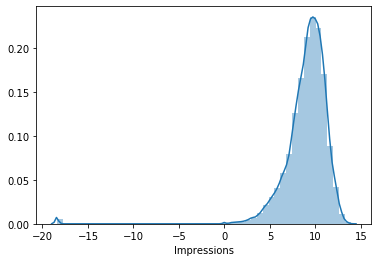

In [3]:
sns.distplot(np.log(df_train_Y['Impressions'] + 0.00000001))
plt.plot()

In [4]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['Impressions']:
    df_train_Y['Impressions_log'] = df_train_Y['Impressions'].apply(log)
    df_val_Y['Impressions_log'] = df_val_Y['Impressions'].apply(log)

### データ構造転換

In [5]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['Impressions_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['Impressions_log'])

d_val = xgb.DMatrix(df_val_X)

/Users/dushu/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/dushu/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化
- 

In [6]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=1000, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['Impressions'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
params = optimize()
params

Training with params:                                
{'alpha': 3.911981555142201e-06, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.5594106731237764e-06, 'lambda': 0.21184188296194129, 'learning_rate': 0.35000000000000003, 'max_depth': 8, 'min_child_weight': 0.16358823564271838, 'n_estimators': 660.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:5.83137	eval-rmse:5.97523             

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.

[1]	train-rmse:3.87802	eval-rmse:3.93398             

[2]	train-rmse:2.64192	eval-rmse:2.64258             

[3]	train-rmse:1.87878	eval-rmse:1.8147              

[4]	train-rmse:1.42606	eval-rmse:1.30547             

[5]	train-rmse:1.16113	eval-rmse:1.00755             

[6]	train-rmse:1.01394	eval-rmse:0.84981             

[7]	train-rmse:0.935427	eval-rmse:0.776674           

[8]	train-rmse:0.885904	eval-rmse:0.737615     

[1]	train-rmse:2.85447	eval-rmse:2.86472                                       

[2]	train-rmse:1.75634	eval-rmse:1.6908                                        

[3]	train-rmse:1.21948	eval-rmse:1.11132                                       

[4]	train-rmse:0.964085	eval-rmse:0.852241                                     

[5]	train-rmse:0.853701	eval-rmse:0.762825                                     

[6]	train-rmse:0.790151	eval-rmse:0.782071                                     

[7]	train-rmse:0.762351	eval-rmse:0.770775                                     

[8]	train-rmse:0.742548	eval-rmse:0.767191                                     

[9]	train-rmse:0.720571	eval-rmse:0.769728                                     

[10]	train-rmse:0.703963	eval-rmse:0.788727                                    

[11]	train-rmse:0.686793	eval-rmse:0.791785                                    

[12]	train-rmse:0.665745	eval-rmse:0.806105                                    

[13]	train-rmse:0.646397	eva

[67]	train-rmse:1.02107	eval-rmse:0.615295                                     

[68]	train-rmse:1.0193	eval-rmse:0.614241                                      

[69]	train-rmse:1.01773	eval-rmse:0.614213                                     

[70]	train-rmse:1.0149	eval-rmse:0.61282                                       

[71]	train-rmse:1.01314	eval-rmse:0.612606                                     

[72]	train-rmse:1.01173	eval-rmse:0.612583                                     

[73]	train-rmse:1.00858	eval-rmse:0.612391                                     

[74]	train-rmse:1.00668	eval-rmse:0.612415                                     

[75]	train-rmse:1.00344	eval-rmse:0.612274                                     

[76]	train-rmse:1.00046	eval-rmse:0.612698                                     

[77]	train-rmse:0.998094	eval-rmse:0.612456                                    

[78]	train-rmse:0.996813	eval-rmse:0.612791                                    

[79]	train-rmse:0.995231	eva

[7]	train-rmse:1.26444	eval-rmse:0.755862                                      

[8]	train-rmse:1.25771	eval-rmse:0.748874                                      

[9]	train-rmse:1.25306	eval-rmse:0.75279                                       

[10]	train-rmse:1.24279	eval-rmse:0.743693                                     

[11]	train-rmse:1.23586	eval-rmse:0.74559                                      

[12]	train-rmse:1.22486	eval-rmse:0.738904                                     

[13]	train-rmse:1.21157	eval-rmse:0.74322                                      

[14]	train-rmse:1.20229	eval-rmse:0.742593                                     

[15]	train-rmse:1.19818	eval-rmse:0.743668                                     

[16]	train-rmse:1.19097	eval-rmse:0.742969                                     

[17]	train-rmse:1.18452	eval-rmse:0.740184                                     

[18]	train-rmse:1.17296	eval-rmse:0.739951                                     

[19]	train-rmse:1.16548	eval

[28]	train-rmse:0.690603	eval-rmse:1.38134                                     

[29]	train-rmse:0.686549	eval-rmse:1.3819                                      

[30]	train-rmse:0.679997	eval-rmse:1.37715                                     

Stopping. Best iteration:                                                      
[10]	train-rmse:0.884785	eval-rmse:0.703919


loss: 2035706645.6328285                                                       
Training with params:                                                          
{'alpha': 0.0009285498936339461, 'colsample_bytree': 0.65, 'gamma': 0.0008368916255726159, 'lambda': 0.20285530414473552, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1.6645815480173283, 'n_estimators': 605.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:8.00719	eval-rmse:8.23206                                       

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval

[89]	train-rmse:1.14755	eval-rmse:0.637941                                     

[90]	train-rmse:1.1464	eval-rmse:0.637825                                      

[91]	train-rmse:1.14457	eval-rmse:0.637451                                     

[92]	train-rmse:1.1428	eval-rmse:0.637402                                      

[93]	train-rmse:1.14159	eval-rmse:0.637203                                     

Stopping. Best iteration:                                                      
[73]	train-rmse:1.17444	eval-rmse:0.636872


loss: 958745761.9909192                                                        
Training with params:                                                          
{'alpha': 4.178653127770903e-06, 'colsample_bytree': 0.65, 'gamma': 0.12021712214391522, 'lambda': 3.5743785818106244, 'learning_rate': 0.30000000000000004, 'max_depth': 6, 'min_child_weight': 4.597905551922923, 'n_estimators': 496.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:6.28376	eval-rm

[2]	train-rmse:3.25849	eval-rmse:3.23115                                        

[3]	train-rmse:2.43819	eval-rmse:2.33053                                        

[4]	train-rmse:1.90649	eval-rmse:1.71358                                        

[5]	train-rmse:1.57527	eval-rmse:1.29025                                        

[6]	train-rmse:1.37754	eval-rmse:1.0245                                         

[7]	train-rmse:1.26184	eval-rmse:0.850812                                       

[8]	train-rmse:1.19477	eval-rmse:0.755701                                       

[9]	train-rmse:1.14684	eval-rmse:0.699147                                       

[10]	train-rmse:1.11389	eval-rmse:0.668133                                      

[11]	train-rmse:1.094	eval-rmse:0.650306                                        

[12]	train-rmse:1.07359	eval-rmse:0.641976                                      

[13]	train-rmse:1.05388	eval-rmse:0.640173                                      

[14]	train-rmse:

[3]	train-rmse:3.76103	eval-rmse:3.81148                                        

[4]	train-rmse:3.06946	eval-rmse:3.08079                                        

[5]	train-rmse:2.52551	eval-rmse:2.49702                                        

[6]	train-rmse:2.09384	eval-rmse:2.04716                                        

[7]	train-rmse:1.76644	eval-rmse:1.68741                                        

[8]	train-rmse:1.516	eval-rmse:1.40758                                          

[9]	train-rmse:1.32503	eval-rmse:1.19687                                        

[10]	train-rmse:1.18097	eval-rmse:1.03437                                       

[11]	train-rmse:1.07576	eval-rmse:0.917472                                      

[12]	train-rmse:0.996931	eval-rmse:0.840494                                     

[13]	train-rmse:0.941851	eval-rmse:0.779644                                     

[14]	train-rmse:0.90007	eval-rmse:0.739169                                      

[15]	train-rmse:

[44]	train-rmse:0.904583	eval-rmse:0.644935                                     

[45]	train-rmse:0.899184	eval-rmse:0.644799                                     

[46]	train-rmse:0.895804	eval-rmse:0.645146                                     

[47]	train-rmse:0.891689	eval-rmse:0.645654                                     

[48]	train-rmse:0.88828	eval-rmse:0.64415                                       

[49]	train-rmse:0.885694	eval-rmse:0.644334                                     

[50]	train-rmse:0.883254	eval-rmse:0.643612                                     

[51]	train-rmse:0.878881	eval-rmse:0.643303                                     

[52]	train-rmse:0.876017	eval-rmse:0.642931                                     

Stopping. Best iteration:                                                       
[32]	train-rmse:0.958625	eval-rmse:0.642409


loss: 790052311.1156543                                                         
Training with params:                                 

[81]	train-rmse:1.78168	eval-rmse:1.37295                                       

[82]	train-rmse:1.76393	eval-rmse:1.34758                                       

[83]	train-rmse:1.74655	eval-rmse:1.32311                                       

[84]	train-rmse:1.72988	eval-rmse:1.29964                                       

[85]	train-rmse:1.71374	eval-rmse:1.27713                                       

[86]	train-rmse:1.69767	eval-rmse:1.25487                                       

[87]	train-rmse:1.68286	eval-rmse:1.23382                                       

[88]	train-rmse:1.66862	eval-rmse:1.2124                                        

[89]	train-rmse:1.65499	eval-rmse:1.19213                                       

[90]	train-rmse:1.64134	eval-rmse:1.17268                                       

[91]	train-rmse:1.62876	eval-rmse:1.15342                                       

[92]	train-rmse:1.61608	eval-rmse:1.13563                                       

[93]	train-rmse:

[180]	train-rmse:1.30457	eval-rmse:0.642961                                     

[181]	train-rmse:1.30421	eval-rmse:0.642537                                     

[182]	train-rmse:1.3035	eval-rmse:0.641218                                      

[183]	train-rmse:1.30311	eval-rmse:0.64029                                      

[184]	train-rmse:1.30241	eval-rmse:0.639612                                     

[185]	train-rmse:1.30082	eval-rmse:0.63919                                      

[186]	train-rmse:1.3002	eval-rmse:0.637687                                      

[187]	train-rmse:1.2996	eval-rmse:0.636572                                      

[188]	train-rmse:1.29897	eval-rmse:0.63595                                      

[189]	train-rmse:1.29855	eval-rmse:0.63562                                      

[190]	train-rmse:1.29804	eval-rmse:0.635392                                     

[191]	train-rmse:1.29776	eval-rmse:0.634983                                     

[192]	train-rmse

[279]	train-rmse:1.26362	eval-rmse:0.613606                                     

[280]	train-rmse:1.26339	eval-rmse:0.613484                                     

[281]	train-rmse:1.26298	eval-rmse:0.613268                                     

[282]	train-rmse:1.26247	eval-rmse:0.61332                                      

[283]	train-rmse:1.26211	eval-rmse:0.613479                                     

[284]	train-rmse:1.26179	eval-rmse:0.613271                                     

[285]	train-rmse:1.26144	eval-rmse:0.613055                                     

[286]	train-rmse:1.26126	eval-rmse:0.612817                                     

[287]	train-rmse:1.26083	eval-rmse:0.612501                                     

[288]	train-rmse:1.26065	eval-rmse:0.61252                                      

[289]	train-rmse:1.26028	eval-rmse:0.612046                                     

[290]	train-rmse:1.2599	eval-rmse:0.612044                                      

[291]	train-rmse

[378]	train-rmse:1.23784	eval-rmse:0.606804                                     

[379]	train-rmse:1.2377	eval-rmse:0.606835                                      

[380]	train-rmse:1.23738	eval-rmse:0.606834                                     

[381]	train-rmse:1.23698	eval-rmse:0.606671                                     

[382]	train-rmse:1.23666	eval-rmse:0.606635                                     

[383]	train-rmse:1.23649	eval-rmse:0.606515                                     

[384]	train-rmse:1.23623	eval-rmse:0.606608                                     

[385]	train-rmse:1.23614	eval-rmse:0.606605                                     

[386]	train-rmse:1.23582	eval-rmse:0.606402                                     

[387]	train-rmse:1.23564	eval-rmse:0.606253                                     

[388]	train-rmse:1.23556	eval-rmse:0.606276                                     

[389]	train-rmse:1.23517	eval-rmse:0.606279                                     

[390]	train-rmse

[477]	train-rmse:1.21671	eval-rmse:0.603141                                     

[478]	train-rmse:1.21662	eval-rmse:0.603209                                     

[479]	train-rmse:1.21633	eval-rmse:0.603221                                     

[480]	train-rmse:1.21626	eval-rmse:0.603247                                     

[481]	train-rmse:1.21616	eval-rmse:0.603238                                     

[482]	train-rmse:1.21593	eval-rmse:0.603231                                     

[483]	train-rmse:1.21572	eval-rmse:0.602884                                     

Stopping. Best iteration:                                                       
[463]	train-rmse:1.22036	eval-rmse:0.60285


loss: 926253985.0119358                                                         
Training with params:                                                           
{'alpha': 1.8181864826156506e-07, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.018804482725978143, 'lambda': 0.22115919742999088, 'l

[83]	train-rmse:1.16332	eval-rmse:0.612257                                      

[84]	train-rmse:1.16263	eval-rmse:0.613315                                      

[85]	train-rmse:1.16115	eval-rmse:0.613467                                      

[86]	train-rmse:1.15921	eval-rmse:0.613455                                      

[87]	train-rmse:1.15667	eval-rmse:0.613516                                      

[88]	train-rmse:1.15441	eval-rmse:0.613204                                      

[89]	train-rmse:1.15342	eval-rmse:0.612908                                      

[90]	train-rmse:1.15278	eval-rmse:0.612673                                      

[91]	train-rmse:1.15078	eval-rmse:0.612732                                      

[92]	train-rmse:1.14957	eval-rmse:0.612662                                      

[93]	train-rmse:1.14806	eval-rmse:0.6143                                        

[94]	train-rmse:1.14759	eval-rmse:0.614278                                      

[95]	train-rmse:

[74]	train-rmse:1.15177	eval-rmse:0.656737                                      

[75]	train-rmse:1.14881	eval-rmse:0.653097                                      

[76]	train-rmse:1.14603	eval-rmse:0.650178                                      

[77]	train-rmse:1.14362	eval-rmse:0.647237                                      

[78]	train-rmse:1.14012	eval-rmse:0.644419                                      

[79]	train-rmse:1.13703	eval-rmse:0.642121                                      

[80]	train-rmse:1.13403	eval-rmse:0.63963                                       

[81]	train-rmse:1.13174	eval-rmse:0.637784                                      

[82]	train-rmse:1.13001	eval-rmse:0.635954                                      

[83]	train-rmse:1.12794	eval-rmse:0.634561                                      

[84]	train-rmse:1.12587	eval-rmse:0.632315                                      

[85]	train-rmse:1.12304	eval-rmse:0.630465                                      

[86]	train-rmse:

[0]	train-rmse:4.55154	eval-rmse:4.61131                                        

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                        

[1]	train-rmse:2.4724	eval-rmse:2.39501                                         

[2]	train-rmse:1.53521	eval-rmse:1.34201                                        

[3]	train-rmse:1.16369	eval-rmse:0.89918                                        

[4]	train-rmse:1.03492	eval-rmse:0.743094                                       

[5]	train-rmse:0.974917	eval-rmse:0.724094                                      

[6]	train-rmse:0.937186	eval-rmse:0.70904                                       

[7]	train-rmse:0.913352	eval-rmse:0.7165                                        

[8]	train-rmse:0.896997	eval-rmse:0.716507                                      

[9]	train-rmse:0.874882	eval-rmse:0.720438                                      

[10]	train-

Will train until eval-rmse hasn't improved in 20 rounds.                        

[1]	train-rmse:3.35504	eval-rmse:3.37884                                        

[2]	train-rmse:2.16764	eval-rmse:2.11857                                        

[3]	train-rmse:1.5091	eval-rmse:1.40121                                         

[4]	train-rmse:1.16636	eval-rmse:1.02817                                        

[5]	train-rmse:0.992191	eval-rmse:0.843865                                      

[6]	train-rmse:0.910775	eval-rmse:0.768285                                      

[7]	train-rmse:0.865334	eval-rmse:0.736532                                      

[8]	train-rmse:0.830889	eval-rmse:0.728923                                      

[9]	train-rmse:0.812257	eval-rmse:0.724753                                      

[10]	train-rmse:0.791524	eval-rmse:0.726785                                     

[11]	train-rmse:0.785428	eval-rmse:0.726341                                     

[12]	train-rmse:

[0]	train-rmse:7.56579	eval-rmse:7.78042                                        

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                        

[1]	train-rmse:6.46112	eval-rmse:6.62914                                        

[2]	train-rmse:5.52542	eval-rmse:5.65186                                        

[3]	train-rmse:4.73455	eval-rmse:4.8236                                         

[4]	train-rmse:4.06806	eval-rmse:4.12578                                        

[5]	train-rmse:3.50597	eval-rmse:3.52945                                        

[6]	train-rmse:3.03474	eval-rmse:3.02281                                        

[7]	train-rmse:2.63927	eval-rmse:2.60068                                        

[8]	train-rmse:2.30878	eval-rmse:2.24303                                        

[9]	train-rmse:2.03654	eval-rmse:1.9446                                         

[10]	train-

[32]	train-rmse:1.2611	eval-rmse:0.633883                                       

[33]	train-rmse:1.25889	eval-rmse:0.633716                                      

[34]	train-rmse:1.25766	eval-rmse:0.633829                                      

[35]	train-rmse:1.25532	eval-rmse:0.632987                                      

[36]	train-rmse:1.25246	eval-rmse:0.632974                                      

[37]	train-rmse:1.25115	eval-rmse:0.633172                                      

[38]	train-rmse:1.24836	eval-rmse:0.63424                                       

[39]	train-rmse:1.24765	eval-rmse:0.635171                                      

[40]	train-rmse:1.2439	eval-rmse:0.63507                                        

[41]	train-rmse:1.23852	eval-rmse:0.635125                                      

[42]	train-rmse:1.23603	eval-rmse:0.635138                                      

[43]	train-rmse:1.23231	eval-rmse:0.632834                                      

[44]	train-rmse:

[42]	train-rmse:0.598839	eval-rmse:0.65102                                      

[43]	train-rmse:0.59721	eval-rmse:0.651092                                      

[44]	train-rmse:0.594554	eval-rmse:0.650632                                     

[45]	train-rmse:0.591789	eval-rmse:0.650546                                     

[46]	train-rmse:0.583671	eval-rmse:0.65027                                      

[47]	train-rmse:0.579056	eval-rmse:0.650323                                     

[48]	train-rmse:0.574513	eval-rmse:0.649765                                     

[49]	train-rmse:0.572782	eval-rmse:0.64992                                      

[50]	train-rmse:0.571172	eval-rmse:0.650612                                     

[51]	train-rmse:0.568236	eval-rmse:0.651526                                     

[52]	train-rmse:0.56701	eval-rmse:0.651359                                      

[53]	train-rmse:0.561925	eval-rmse:0.650666                                     

[54]	train-rmse:

[76]	train-rmse:0.55603	eval-rmse:0.639965                                      

[77]	train-rmse:0.553095	eval-rmse:0.640342                                     

[78]	train-rmse:0.549563	eval-rmse:0.640053                                     

[79]	train-rmse:0.548253	eval-rmse:0.640505                                     

[80]	train-rmse:0.547277	eval-rmse:0.64028                                      

[81]	train-rmse:0.545228	eval-rmse:0.640791                                     

[82]	train-rmse:0.544898	eval-rmse:0.640687                                     

[83]	train-rmse:0.543855	eval-rmse:0.640898                                     

[84]	train-rmse:0.541933	eval-rmse:0.641693                                     

[85]	train-rmse:0.540368	eval-rmse:0.641463                                     

[86]	train-rmse:0.537731	eval-rmse:0.641896                                     

[87]	train-rmse:0.535093	eval-rmse:0.643182                                     

Stopping. Best i

Stopping. Best iteration:                                                       
[57]	train-rmse:0.584197	eval-rmse:0.623473


loss: 826911750.0999774                                                         
Training with params:                                                           
{'alpha': 1.6299487091628476e-07, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.00040225033147821135, 'lambda': 0.006356306291053464, 'learning_rate': 0.025, 'max_depth': 9, 'min_child_weight': 0.7897465671204431, 'n_estimators': 708.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:8.65098	eval-rmse:8.90596                                        

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                        

[1]	train-rmse:8.43792	eval-rmse:8.68488                                        

[2]	train-rmse:8.2303	eval-rmse:8.47                                            

[3]	train-

[90]	train-rmse:1.19185	eval-rmse:1.12258                                       

[91]	train-rmse:1.17363	eval-rmse:1.10376                                       

[92]	train-rmse:1.15578	eval-rmse:1.08564                                       

[93]	train-rmse:1.13886	eval-rmse:1.06811                                       

[94]	train-rmse:1.12261	eval-rmse:1.05082                                       

[95]	train-rmse:1.10732	eval-rmse:1.03423                                       

[96]	train-rmse:1.09196	eval-rmse:1.02078                                       

[97]	train-rmse:1.07699	eval-rmse:1.00485                                       

[98]	train-rmse:1.06278	eval-rmse:0.990464                                      

[99]	train-rmse:1.04875	eval-rmse:0.976466                                      

[100]	train-rmse:1.03561	eval-rmse:0.962271                                     

[101]	train-rmse:1.02286	eval-rmse:0.948987                                     

[102]	train-rmse

[189]	train-rmse:0.645663	eval-rmse:0.623333                                    

[190]	train-rmse:0.644327	eval-rmse:0.6231                                      

[191]	train-rmse:0.643123	eval-rmse:0.622737                                    

[192]	train-rmse:0.642092	eval-rmse:0.622768                                    

[193]	train-rmse:0.640788	eval-rmse:0.622188                                    

[194]	train-rmse:0.639611	eval-rmse:0.622006                                    

[195]	train-rmse:0.638768	eval-rmse:0.621896                                    

[196]	train-rmse:0.637967	eval-rmse:0.621778                                    

[197]	train-rmse:0.637069	eval-rmse:0.621709                                    

[198]	train-rmse:0.635735	eval-rmse:0.621501                                    

[199]	train-rmse:0.634954	eval-rmse:0.621391                                    

[200]	train-rmse:0.63413	eval-rmse:0.620687                                     

[201]	train-rmse

[27]	train-rmse:0.622078	eval-rmse:0.675042                                      

[28]	train-rmse:0.617516	eval-rmse:0.672863                                      

[29]	train-rmse:0.611738	eval-rmse:0.674453                                      

[30]	train-rmse:0.605523	eval-rmse:0.674669                                      

[31]	train-rmse:0.599675	eval-rmse:0.675777                                      

[32]	train-rmse:0.596281	eval-rmse:0.676745                                      

[33]	train-rmse:0.590592	eval-rmse:0.679016                                      

[34]	train-rmse:0.588213	eval-rmse:0.679531                                      

[35]	train-rmse:0.582986	eval-rmse:0.681473                                      

[36]	train-rmse:0.580239	eval-rmse:0.679573                                      

[37]	train-rmse:0.57308	eval-rmse:0.680905                                       

[38]	train-rmse:0.570257	eval-rmse:0.681157                                      

[39]

[76]	train-rmse:0.617867	eval-rmse:0.63134                                       

[77]	train-rmse:0.615154	eval-rmse:0.631349                                      

[78]	train-rmse:0.613494	eval-rmse:0.631395                                      

[79]	train-rmse:0.611522	eval-rmse:0.631284                                      

[80]	train-rmse:0.608898	eval-rmse:0.634522                                      

[81]	train-rmse:0.607388	eval-rmse:0.634473                                      

[82]	train-rmse:0.605593	eval-rmse:0.63463                                       

[83]	train-rmse:0.602883	eval-rmse:0.634758                                      

[84]	train-rmse:0.600158	eval-rmse:0.635144                                      

[85]	train-rmse:0.599266	eval-rmse:0.635699                                      

[86]	train-rmse:0.59683	eval-rmse:0.636164                                       

[87]	train-rmse:0.595368	eval-rmse:0.638027                                      

[88]

[26]	train-rmse:1.10554	eval-rmse:0.6203                                        

[27]	train-rmse:1.10172	eval-rmse:0.620587                                      

[28]	train-rmse:1.0963	eval-rmse:0.631549                                       

[29]	train-rmse:1.0846	eval-rmse:0.631354                                       

[30]	train-rmse:1.07711	eval-rmse:0.633711                                      

[31]	train-rmse:1.07396	eval-rmse:0.633465                                      

[32]	train-rmse:1.07181	eval-rmse:0.632988                                      

[33]	train-rmse:1.06734	eval-rmse:0.632989                                      

[34]	train-rmse:1.06421	eval-rmse:0.632926                                      

[35]	train-rmse:1.05863	eval-rmse:0.635425                                      

[36]	train-rmse:1.05296	eval-rmse:0.635189                                      

[37]	train-rmse:1.04922	eval-rmse:0.636932                                      

[38]	train-rmse:

[69]	train-rmse:1.25221	eval-rmse:0.626403                                      

[70]	train-rmse:1.25156	eval-rmse:0.625838                                      

[71]	train-rmse:1.25031	eval-rmse:0.628218                                      

[72]	train-rmse:1.24946	eval-rmse:0.628814                                      

[73]	train-rmse:1.24727	eval-rmse:0.629103                                      

[74]	train-rmse:1.24623	eval-rmse:0.629228                                      

[75]	train-rmse:1.24516	eval-rmse:0.629201                                      

[76]	train-rmse:1.24382	eval-rmse:0.629584                                      

[77]	train-rmse:1.2426	eval-rmse:0.629882                                       

[78]	train-rmse:1.24157	eval-rmse:0.631096                                      

[79]	train-rmse:1.24047	eval-rmse:0.63101                                       

[80]	train-rmse:1.23903	eval-rmse:0.630771                                      

[81]	train-rmse:

[68]	train-rmse:0.887524	eval-rmse:0.679937                                     

[69]	train-rmse:0.881288	eval-rmse:0.674721                                     

[70]	train-rmse:0.875442	eval-rmse:0.666001                                     

[71]	train-rmse:0.868956	eval-rmse:0.661017                                     

[72]	train-rmse:0.864025	eval-rmse:0.656895                                     

[73]	train-rmse:0.859246	eval-rmse:0.653265                                     

[74]	train-rmse:0.854301	eval-rmse:0.648987                                     

[75]	train-rmse:0.850359	eval-rmse:0.645915                                     

[76]	train-rmse:0.846265	eval-rmse:0.64285                                      

[77]	train-rmse:0.840996	eval-rmse:0.64006                                      

[78]	train-rmse:0.836978	eval-rmse:0.637688                                     

[79]	train-rmse:0.833326	eval-rmse:0.63512                                      

[80]	train-rmse:

[20]	train-rmse:0.617244	eval-rmse:0.728849                                     

[21]	train-rmse:0.605698	eval-rmse:0.728356                                     

[22]	train-rmse:0.601258	eval-rmse:0.731246                                     

[23]	train-rmse:0.590973	eval-rmse:0.732679                                     

[24]	train-rmse:0.582642	eval-rmse:0.734146                                     

[25]	train-rmse:0.574899	eval-rmse:0.735571                                     

[26]	train-rmse:0.571185	eval-rmse:0.73651                                      

[27]	train-rmse:0.566634	eval-rmse:0.736707                                     

[28]	train-rmse:0.564119	eval-rmse:0.734915                                     

[29]	train-rmse:0.558631	eval-rmse:0.739101                                     

Stopping. Best iteration:                                                       
[9]	train-rmse:0.74391	eval-rmse:0.713623


loss: 910485755.7359765                                

[23]	train-rmse:0.72277	eval-rmse:0.698067                                      

[24]	train-rmse:0.708051	eval-rmse:0.688358                                     

[25]	train-rmse:0.698099	eval-rmse:0.682007                                     

[26]	train-rmse:0.686265	eval-rmse:0.677287                                     

[27]	train-rmse:0.67846	eval-rmse:0.673505                                      

[28]	train-rmse:0.669854	eval-rmse:0.671646                                     

[29]	train-rmse:0.662351	eval-rmse:0.670582                                     

[30]	train-rmse:0.657686	eval-rmse:0.667547                                     

[31]	train-rmse:0.651952	eval-rmse:0.66605                                      

[32]	train-rmse:0.647883	eval-rmse:0.665052                                     

[33]	train-rmse:0.641507	eval-rmse:0.66425                                      

[34]	train-rmse:0.635946	eval-rmse:0.665545                                     

[35]	train-rmse:

[0]	train-rmse:7.3691	eval-rmse:7.56172                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                        

[1]	train-rmse:6.14044	eval-rmse:6.26711                                        

[2]	train-rmse:5.13681	eval-rmse:5.1937                                         

[3]	train-rmse:4.32034	eval-rmse:4.31334                                        

[4]	train-rmse:3.65808	eval-rmse:3.59157                                        

[5]	train-rmse:3.12713	eval-rmse:3.0021                                         

[6]	train-rmse:2.70319	eval-rmse:2.51865                                        

[7]	train-rmse:2.37012	eval-rmse:2.12155                                        

[8]	train-rmse:2.1076	eval-rmse:1.79334                                         

[9]	train-rmse:1.90703	eval-rmse:1.53561                                        

[10]	train-

[1]	train-rmse:7.62102	eval-rmse:7.83148                                        

[2]	train-rmse:7.06712	eval-rmse:7.25641                                        

[3]	train-rmse:6.55563	eval-rmse:6.72384                                        

[4]	train-rmse:6.08426	eval-rmse:6.23215                                        

[5]	train-rmse:5.64845	eval-rmse:5.7747                                         

[6]	train-rmse:5.24638	eval-rmse:5.35395                                        

[7]	train-rmse:4.87604	eval-rmse:4.96569                                        

[8]	train-rmse:4.53484	eval-rmse:4.6061                                         

[9]	train-rmse:4.22122	eval-rmse:4.27763                                        

[10]	train-rmse:3.93172	eval-rmse:3.96571                                       

[11]	train-rmse:3.66493	eval-rmse:3.68156                                       

[12]	train-rmse:3.41934	eval-rmse:3.41751                                       

[13]	train-rmse:

[100]	train-rmse:0.865878	eval-rmse:0.611184                                    

[101]	train-rmse:0.864792	eval-rmse:0.611484                                    

[102]	train-rmse:0.863358	eval-rmse:0.611718                                    

[103]	train-rmse:0.86142	eval-rmse:0.611709                                     

[104]	train-rmse:0.860003	eval-rmse:0.611311                                    

[105]	train-rmse:0.857434	eval-rmse:0.611446                                    

Stopping. Best iteration:                                                       
[85]	train-rmse:0.895268	eval-rmse:0.610805


loss: 839169669.6684601                                                         
Training with params:                                                           
{'alpha': 0.10483085973814639, 'colsample_bytree': 0.8, 'gamma': 7.067935464579705e-07, 'lambda': 0.0005690091166084417, 'learning_rate': 0.225, 'max_depth': 6, 'min_child_weight': 1.051774295307924, 'n_estimators': 617

[28]	train-rmse:0.974586	eval-rmse:0.780952                                     

[29]	train-rmse:0.951027	eval-rmse:0.756118                                     

[30]	train-rmse:0.929746	eval-rmse:0.733332                                     

[31]	train-rmse:0.912648	eval-rmse:0.71575                                      

[32]	train-rmse:0.895772	eval-rmse:0.703152                                     

[33]	train-rmse:0.883361	eval-rmse:0.690172                                     

[34]	train-rmse:0.868699	eval-rmse:0.678947                                     

[35]	train-rmse:0.856806	eval-rmse:0.670665                                     

[36]	train-rmse:0.847128	eval-rmse:0.663858                                     

[37]	train-rmse:0.838366	eval-rmse:0.657841                                     

[38]	train-rmse:0.829305	eval-rmse:0.651621                                     

[39]	train-rmse:0.820571	eval-rmse:0.648032                                     

[40]	train-rmse:

[10]	train-rmse:1.99811	eval-rmse:1.70084                                       

[11]	train-rmse:1.8339	eval-rmse:1.4951                                         

[12]	train-rmse:1.70535	eval-rmse:1.32204                                       

[13]	train-rmse:1.60332	eval-rmse:1.18314                                       

[14]	train-rmse:1.52671	eval-rmse:1.07172                                       

[15]	train-rmse:1.46653	eval-rmse:0.976039                                      

[16]	train-rmse:1.41293	eval-rmse:0.898035                                      

[17]	train-rmse:1.37843	eval-rmse:0.836329                                      

[18]	train-rmse:1.34804	eval-rmse:0.790358                                      

[19]	train-rmse:1.32787	eval-rmse:0.757762                                      

[20]	train-rmse:1.31233	eval-rmse:0.731057                                      

[21]	train-rmse:1.29791	eval-rmse:0.708246                                      

[22]	train-rmse:

[27]	train-rmse:0.553894	eval-rmse:0.701591                                     

[28]	train-rmse:0.55076	eval-rmse:0.701209                                      

[29]	train-rmse:0.544	eval-rmse:0.701313                                        

[30]	train-rmse:0.536103	eval-rmse:0.70181                                      

[31]	train-rmse:0.533545	eval-rmse:0.702153                                     

Stopping. Best iteration:                                                       
[11]	train-rmse:0.68413	eval-rmse:0.683657


loss: 801928714.3381418                                                         
Training with params:                                                           
{'alpha': 1.7342705780478803e-05, 'colsample_bytree': 0.9, 'gamma': 6.409967355101851e-06, 'lambda': 1.4831530111981921e-06, 'learning_rate': 0.275, 'max_depth': 7, 'min_child_weight': 0.15101364616749272, 'n_estimators': 849.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:6.48377	eval-

[32]	train-rmse:1.999	eval-rmse:1.81412                                         

[33]	train-rmse:1.9315	eval-rmse:1.7369                                         

[34]	train-rmse:1.86846	eval-rmse:1.66362                                       

[35]	train-rmse:1.80932	eval-rmse:1.59328                                       

[36]	train-rmse:1.75453	eval-rmse:1.52806                                       

[37]	train-rmse:1.70299	eval-rmse:1.46682                                       

[38]	train-rmse:1.65579	eval-rmse:1.40801                                       

[39]	train-rmse:1.61113	eval-rmse:1.35309                                       

[40]	train-rmse:1.57068	eval-rmse:1.30239                                       

[41]	train-rmse:1.53235	eval-rmse:1.25422                                       

[42]	train-rmse:1.49616	eval-rmse:1.20853                                       

[43]	train-rmse:1.46293	eval-rmse:1.16661                                       

[44]	train-rmse:

[131]	train-rmse:0.963863	eval-rmse:0.609876                                    

[132]	train-rmse:0.962826	eval-rmse:0.609395                                    

[133]	train-rmse:0.962548	eval-rmse:0.609633                                    

[134]	train-rmse:0.960876	eval-rmse:0.609266                                    

[135]	train-rmse:0.959993	eval-rmse:0.608634                                    

[136]	train-rmse:0.959327	eval-rmse:0.608533                                    

[137]	train-rmse:0.958176	eval-rmse:0.6083                                      

[138]	train-rmse:0.956841	eval-rmse:0.608217                                    

[139]	train-rmse:0.955985	eval-rmse:0.607824                                    

[140]	train-rmse:0.954511	eval-rmse:0.608024                                    

[141]	train-rmse:0.952769	eval-rmse:0.607972                                    

[142]	train-rmse:0.952288	eval-rmse:0.607493                                    

[143]	train-rmse

[21]	train-rmse:1.49915	eval-rmse:1.13218                                       

[22]	train-rmse:1.44752	eval-rmse:1.05583                                       

[23]	train-rmse:1.4031	eval-rmse:0.991891                                       

[24]	train-rmse:1.36357	eval-rmse:0.934641                                      

[25]	train-rmse:1.32817	eval-rmse:0.885004                                      

[26]	train-rmse:1.29672	eval-rmse:0.842682                                      

[27]	train-rmse:1.27339	eval-rmse:0.806716                                      

[28]	train-rmse:1.24854	eval-rmse:0.776114                                      

[29]	train-rmse:1.22846	eval-rmse:0.750802                                      

[30]	train-rmse:1.21184	eval-rmse:0.729143                                      

[31]	train-rmse:1.199	eval-rmse:0.710785                                        

[32]	train-rmse:1.18787	eval-rmse:0.694922                                      

[33]	train-rmse:

[22]	train-rmse:1.23974	eval-rmse:0.658602                                      

[23]	train-rmse:1.23199	eval-rmse:0.655292                                      

[24]	train-rmse:1.22905	eval-rmse:0.65504                                       

[25]	train-rmse:1.22354	eval-rmse:0.651429                                      

[26]	train-rmse:1.21912	eval-rmse:0.651322                                      

[27]	train-rmse:1.21413	eval-rmse:0.648066                                      

[28]	train-rmse:1.20889	eval-rmse:0.646683                                      

[29]	train-rmse:1.20544	eval-rmse:0.647309                                      

[30]	train-rmse:1.20017	eval-rmse:0.647184                                      

[31]	train-rmse:1.19539	eval-rmse:0.646311                                      

[32]	train-rmse:1.18871	eval-rmse:0.644529                                      

[33]	train-rmse:1.18474	eval-rmse:0.644849                                      

[34]	train-rmse:

[12]	train-rmse:1.1092	eval-rmse:1.0359                                         

[13]	train-rmse:1.01746	eval-rmse:0.941643                                      

[14]	train-rmse:0.947548	eval-rmse:0.870091                                     

[15]	train-rmse:0.896066	eval-rmse:0.816737                                     

[16]	train-rmse:0.854276	eval-rmse:0.774988                                     

[17]	train-rmse:0.820288	eval-rmse:0.745374                                     

[18]	train-rmse:0.796423	eval-rmse:0.728521                                     

[19]	train-rmse:0.774988	eval-rmse:0.711498                                     

[20]	train-rmse:0.760625	eval-rmse:0.701833                                     

[21]	train-rmse:0.746414	eval-rmse:0.693663                                     

[22]	train-rmse:0.731489	eval-rmse:0.68572                                      

[23]	train-rmse:0.722423	eval-rmse:0.680236                                     

[24]	train-rmse:

[42]	train-rmse:1.24457	eval-rmse:0.617665                                      

[43]	train-rmse:1.24046	eval-rmse:0.617299                                      

[44]	train-rmse:1.23834	eval-rmse:0.619875                                      

[45]	train-rmse:1.23569	eval-rmse:0.618556                                      

[46]	train-rmse:1.2328	eval-rmse:0.618574                                       

[47]	train-rmse:1.23105	eval-rmse:0.618643                                      

[48]	train-rmse:1.23015	eval-rmse:0.618642                                      

[49]	train-rmse:1.22772	eval-rmse:0.61724                                       

[50]	train-rmse:1.22454	eval-rmse:0.617648                                      

[51]	train-rmse:1.22261	eval-rmse:0.615117                                      

[52]	train-rmse:1.22123	eval-rmse:0.613743                                      

[53]	train-rmse:1.21977	eval-rmse:0.615044                                      

[54]	train-rmse:

[53]	train-rmse:0.890954	eval-rmse:0.618876                                     

[54]	train-rmse:0.886542	eval-rmse:0.618893                                     

[55]	train-rmse:0.881812	eval-rmse:0.621649                                     

[56]	train-rmse:0.877929	eval-rmse:0.621289                                     

[57]	train-rmse:0.876115	eval-rmse:0.621043                                     

[58]	train-rmse:0.873017	eval-rmse:0.622109                                     

[59]	train-rmse:0.870208	eval-rmse:0.621721                                     

[60]	train-rmse:0.867024	eval-rmse:0.625053                                     

[61]	train-rmse:0.864426	eval-rmse:0.62442                                      

[62]	train-rmse:0.861747	eval-rmse:0.624415                                     

Stopping. Best iteration:                                                       
[42]	train-rmse:0.929493	eval-rmse:0.618475


loss: 834979894.4675658                              

[81]	train-rmse:1.50162	eval-rmse:1.33328                                       

[82]	train-rmse:1.47946	eval-rmse:1.30859                                       

[83]	train-rmse:1.45794	eval-rmse:1.28377                                       

[84]	train-rmse:1.43814	eval-rmse:1.25968                                       

[85]	train-rmse:1.41832	eval-rmse:1.23655                                       

[86]	train-rmse:1.39933	eval-rmse:1.21455                                       

[87]	train-rmse:1.381	eval-rmse:1.19294                                         

[88]	train-rmse:1.36313	eval-rmse:1.17225                                       

[89]	train-rmse:1.34585	eval-rmse:1.15159                                       

[90]	train-rmse:1.32967	eval-rmse:1.1326                                        

[91]	train-rmse:1.31383	eval-rmse:1.11336                                       

[92]	train-rmse:1.29798	eval-rmse:1.09514                                       

[93]	train-rmse:

[180]	train-rmse:0.870321	eval-rmse:0.619717                                    

[181]	train-rmse:0.869242	eval-rmse:0.619217                                    

[182]	train-rmse:0.868073	eval-rmse:0.618655                                    

[183]	train-rmse:0.86686	eval-rmse:0.618547                                     

[184]	train-rmse:0.865986	eval-rmse:0.618121                                    

[185]	train-rmse:0.865135	eval-rmse:0.617626                                    

[186]	train-rmse:0.864092	eval-rmse:0.617067                                    

[187]	train-rmse:0.862966	eval-rmse:0.61668                                     

[188]	train-rmse:0.861755	eval-rmse:0.61609                                     

[189]	train-rmse:0.861133	eval-rmse:0.615786                                    

[190]	train-rmse:0.86013	eval-rmse:0.615356                                     

[191]	train-rmse:0.859253	eval-rmse:0.615363                                    

[192]	train-rmse

[14]	train-rmse:1.46706	eval-rmse:1.41037                                       

[15]	train-rmse:1.33954	eval-rmse:1.27301                                       

[16]	train-rmse:1.23249	eval-rmse:1.15696                                       

[17]	train-rmse:1.14196	eval-rmse:1.064                                         

[18]	train-rmse:1.06523	eval-rmse:0.97835                                       

[19]	train-rmse:0.99933	eval-rmse:0.91025                                       

[20]	train-rmse:0.946242	eval-rmse:0.854007                                     

[21]	train-rmse:0.901925	eval-rmse:0.808776                                     

[22]	train-rmse:0.865354	eval-rmse:0.773849                                     

[23]	train-rmse:0.834448	eval-rmse:0.742959                                     

[24]	train-rmse:0.807931	eval-rmse:0.721996                                     

[25]	train-rmse:0.783517	eval-rmse:0.702586                                     

[26]	train-rmse:

[28]	train-rmse:1.1805	eval-rmse:0.644168                                       

[29]	train-rmse:1.1744	eval-rmse:0.646713                                       

[30]	train-rmse:1.16964	eval-rmse:0.645163                                      

[31]	train-rmse:1.16804	eval-rmse:0.643212                                      

[32]	train-rmse:1.16489	eval-rmse:0.641089                                      

[33]	train-rmse:1.16102	eval-rmse:0.644428                                      

[34]	train-rmse:1.15784	eval-rmse:0.645935                                      

[35]	train-rmse:1.1559	eval-rmse:0.644159                                       

[36]	train-rmse:1.15204	eval-rmse:0.645095                                      

[37]	train-rmse:1.14693	eval-rmse:0.646078                                      

[38]	train-rmse:1.14213	eval-rmse:0.647027                                      

[39]	train-rmse:1.13933	eval-rmse:0.645373                                      

[40]	train-rmse:

[65]	train-rmse:0.772403	eval-rmse:0.711636                                     

[66]	train-rmse:0.76359	eval-rmse:0.703611                                      

[67]	train-rmse:0.755065	eval-rmse:0.696258                                     

[68]	train-rmse:0.748098	eval-rmse:0.689906                                     

[69]	train-rmse:0.740554	eval-rmse:0.684869                                     

[70]	train-rmse:0.733725	eval-rmse:0.679614                                     

[71]	train-rmse:0.72656	eval-rmse:0.675263                                      

[72]	train-rmse:0.721359	eval-rmse:0.670537                                     

[73]	train-rmse:0.715815	eval-rmse:0.66627                                      

[74]	train-rmse:0.710535	eval-rmse:0.661741                                     

[75]	train-rmse:0.704039	eval-rmse:0.658615                                     

[76]	train-rmse:0.699019	eval-rmse:0.65567                                      

[77]	train-rmse:

[13]	train-rmse:3.22594	eval-rmse:3.16893                                       

[14]	train-rmse:3.02359	eval-rmse:2.94468                                       

[15]	train-rmse:2.83746	eval-rmse:2.73638                                       

[16]	train-rmse:2.66872	eval-rmse:2.55005                                       

[17]	train-rmse:2.5143	eval-rmse:2.37359                                        

[18]	train-rmse:2.37326	eval-rmse:2.21306                                       

[19]	train-rmse:2.24632	eval-rmse:2.06385                                       

[20]	train-rmse:2.13041	eval-rmse:1.92656                                       

[21]	train-rmse:2.02685	eval-rmse:1.80066                                       

[22]	train-rmse:1.93373	eval-rmse:1.68794                                       

[23]	train-rmse:1.84929	eval-rmse:1.58416                                       

[24]	train-rmse:1.7726	eval-rmse:1.48792                                        

[25]	train-rmse:

[112]	train-rmse:1.02245	eval-rmse:0.617438                                     

[113]	train-rmse:1.02145	eval-rmse:0.617386                                     

[114]	train-rmse:1.01935	eval-rmse:0.617361                                     

[115]	train-rmse:1.01809	eval-rmse:0.616856                                     

[116]	train-rmse:1.01598	eval-rmse:0.61687                                      

[117]	train-rmse:1.01467	eval-rmse:0.616595                                     

[118]	train-rmse:1.01295	eval-rmse:0.617082                                     

[119]	train-rmse:1.01077	eval-rmse:0.616949                                     

[120]	train-rmse:1.00968	eval-rmse:0.617154                                     

[121]	train-rmse:1.00896	eval-rmse:0.61674                                      

Stopping. Best iteration:                                                       
[101]	train-rmse:1.03794	eval-rmse:0.616505


loss: 903206729.3317966                              

[23]	train-rmse:0.64498	eval-rmse:0.669922                                      

[24]	train-rmse:0.635239	eval-rmse:0.670248                                     

[25]	train-rmse:0.625581	eval-rmse:0.67173                                      

[26]	train-rmse:0.62014	eval-rmse:0.671576                                      

[27]	train-rmse:0.613451	eval-rmse:0.671136                                     

[28]	train-rmse:0.611601	eval-rmse:0.672235                                     

[29]	train-rmse:0.609767	eval-rmse:0.67276                                      

[30]	train-rmse:0.601903	eval-rmse:0.672349                                     

[31]	train-rmse:0.599665	eval-rmse:0.67199                                      

[32]	train-rmse:0.593312	eval-rmse:0.673757                                     

[33]	train-rmse:0.58865	eval-rmse:0.673323                                      

[34]	train-rmse:0.585886	eval-rmse:0.674434                                     

[35]	train-rmse:

[5]	train-rmse:3.52767	eval-rmse:3.52917                                        

[6]	train-rmse:3.06024	eval-rmse:3.0279                                         

[7]	train-rmse:2.67016	eval-rmse:2.59845                                        

[8]	train-rmse:2.34894	eval-rmse:2.23754                                        

[9]	train-rmse:2.08422	eval-rmse:1.93856                                        

[10]	train-rmse:1.86673	eval-rmse:1.68391                                       

[11]	train-rmse:1.69164	eval-rmse:1.46868                                       

[12]	train-rmse:1.54979	eval-rmse:1.29507                                       

[13]	train-rmse:1.43822	eval-rmse:1.15629                                       

[14]	train-rmse:1.34874	eval-rmse:1.04475                                       

[15]	train-rmse:1.27833	eval-rmse:0.95207                                       

[16]	train-rmse:1.22314	eval-rmse:0.875481                                      

[17]	train-rmse:

[21]	train-rmse:0.810062	eval-rmse:0.651282                                     

[22]	train-rmse:0.801881	eval-rmse:0.650091                                     

[23]	train-rmse:0.79517	eval-rmse:0.651238                                      

[24]	train-rmse:0.790053	eval-rmse:0.649783                                     

[25]	train-rmse:0.785945	eval-rmse:0.649069                                     

[26]	train-rmse:0.782965	eval-rmse:0.65011                                      

[27]	train-rmse:0.778802	eval-rmse:0.649531                                     

[28]	train-rmse:0.775016	eval-rmse:0.650408                                     

[29]	train-rmse:0.769	eval-rmse:0.650423                                        

[30]	train-rmse:0.763992	eval-rmse:0.650663                                     

[31]	train-rmse:0.756286	eval-rmse:0.653187                                     

[32]	train-rmse:0.753466	eval-rmse:0.65214                                      

[33]	train-rmse:

[47]	train-rmse:0.942568	eval-rmse:0.664341                                     

[48]	train-rmse:0.93529	eval-rmse:0.658187                                      

[49]	train-rmse:0.929612	eval-rmse:0.653346                                     

[50]	train-rmse:0.922348	eval-rmse:0.648099                                     

[51]	train-rmse:0.915617	eval-rmse:0.643046                                     

[52]	train-rmse:0.911109	eval-rmse:0.640171                                     

[53]	train-rmse:0.907198	eval-rmse:0.636602                                     

[54]	train-rmse:0.902041	eval-rmse:0.63386                                      

[55]	train-rmse:0.898476	eval-rmse:0.63148                                      

[56]	train-rmse:0.893856	eval-rmse:0.629954                                     

[57]	train-rmse:0.889306	eval-rmse:0.627862                                     

[58]	train-rmse:0.885379	eval-rmse:0.625359                                     

[59]	train-rmse:

[28]	train-rmse:0.850454	eval-rmse:0.776097                                     

[29]	train-rmse:0.824554	eval-rmse:0.752512                                     

[30]	train-rmse:0.80136	eval-rmse:0.732477                                      

[31]	train-rmse:0.782723	eval-rmse:0.716567                                     

[32]	train-rmse:0.765011	eval-rmse:0.703764                                     

[33]	train-rmse:0.749266	eval-rmse:0.691918                                     

[34]	train-rmse:0.736066	eval-rmse:0.680566                                     

[35]	train-rmse:0.7248	eval-rmse:0.671114                                       

[36]	train-rmse:0.714956	eval-rmse:0.66464                                      

[37]	train-rmse:0.706569	eval-rmse:0.658942                                     

[38]	train-rmse:0.69712	eval-rmse:0.653824                                      

[39]	train-rmse:0.690254	eval-rmse:0.648907                                     

[40]	train-rmse:

[38]	train-rmse:0.664094	eval-rmse:0.639611                                       

[39]	train-rmse:0.657533	eval-rmse:0.637547                                       

[40]	train-rmse:0.652529	eval-rmse:0.636111                                       

[41]	train-rmse:0.647924	eval-rmse:0.636046                                       

[42]	train-rmse:0.641918	eval-rmse:0.636753                                       

[43]	train-rmse:0.638847	eval-rmse:0.635531                                       

[44]	train-rmse:0.635609	eval-rmse:0.63472                                        

[45]	train-rmse:0.633298	eval-rmse:0.634394                                       

[46]	train-rmse:0.631815	eval-rmse:0.632833                                       

[47]	train-rmse:0.629892	eval-rmse:0.633231                                       

[48]	train-rmse:0.625448	eval-rmse:0.633036                                       

[49]	train-rmse:0.622091	eval-rmse:0.633019                                 

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                          

[1]	train-rmse:6.82474	eval-rmse:7.00938                                          

[2]	train-rmse:5.99269	eval-rmse:6.14653                                          

[3]	train-rmse:5.26629	eval-rmse:5.391                                            

[4]	train-rmse:4.63467	eval-rmse:4.73101                                          

[5]	train-rmse:4.08471	eval-rmse:4.15449                                          

[6]	train-rmse:3.60488	eval-rmse:3.6488                                           

[7]	train-rmse:3.18624	eval-rmse:3.21115                                          

[8]	train-rmse:2.82291	eval-rmse:2.82596                                          

[9]	train-rmse:2.50923	eval-rmse:2.49746                                          

[10]	train-rmse:2.23701	eval-rmse:2.20753                                

[16]	train-rmse:1.22849	eval-rmse:1.1679                                          

[17]	train-rmse:1.13564	eval-rmse:1.07318                                         

[18]	train-rmse:1.0587	eval-rmse:0.991179                                         

[19]	train-rmse:0.993608	eval-rmse:0.927973                                       

[20]	train-rmse:0.938385	eval-rmse:0.871253                                       

[21]	train-rmse:0.895054	eval-rmse:0.827385                                       

[22]	train-rmse:0.85793	eval-rmse:0.79016                                         

[23]	train-rmse:0.826128	eval-rmse:0.760619                                       

[24]	train-rmse:0.799699	eval-rmse:0.736788                                       

[25]	train-rmse:0.775655	eval-rmse:0.719646                                       

[26]	train-rmse:0.757182	eval-rmse:0.704851                                       

[27]	train-rmse:0.741642	eval-rmse:0.693472                                 

[23]	train-rmse:0.685834	eval-rmse:0.659551                                       

[24]	train-rmse:0.675468	eval-rmse:0.658517                                       

[25]	train-rmse:0.665706	eval-rmse:0.655042                                       

[26]	train-rmse:0.659401	eval-rmse:0.653505                                       

[27]	train-rmse:0.655313	eval-rmse:0.654301                                       

[28]	train-rmse:0.651192	eval-rmse:0.653584                                       

[29]	train-rmse:0.648383	eval-rmse:0.6535                                         

[30]	train-rmse:0.643723	eval-rmse:0.652497                                       

[31]	train-rmse:0.638128	eval-rmse:0.652902                                       

[32]	train-rmse:0.633828	eval-rmse:0.651208                                       

[33]	train-rmse:0.62934	eval-rmse:0.65208                                         

[34]	train-rmse:0.626319	eval-rmse:0.652082                                 

[58]	train-rmse:0.605239	eval-rmse:0.640206                                       

[59]	train-rmse:0.602352	eval-rmse:0.6405                                         

[60]	train-rmse:0.599822	eval-rmse:0.640193                                       

[61]	train-rmse:0.598794	eval-rmse:0.640184                                       

[62]	train-rmse:0.594584	eval-rmse:0.639319                                       

[63]	train-rmse:0.593219	eval-rmse:0.639132                                       

[64]	train-rmse:0.589314	eval-rmse:0.639747                                       

[65]	train-rmse:0.587172	eval-rmse:0.639484                                       

[66]	train-rmse:0.585422	eval-rmse:0.639155                                       

[67]	train-rmse:0.584422	eval-rmse:0.639512                                       

[68]	train-rmse:0.582647	eval-rmse:0.639894                                       

[69]	train-rmse:0.581425	eval-rmse:0.639825                                 

[31]	train-rmse:1.17372	eval-rmse:0.614726                                        

[32]	train-rmse:1.16631	eval-rmse:0.614709                                        

[33]	train-rmse:1.16401	eval-rmse:0.614615                                        

[34]	train-rmse:1.15809	eval-rmse:0.609391                                        

[35]	train-rmse:1.15324	eval-rmse:0.609396                                        

[36]	train-rmse:1.15189	eval-rmse:0.609897                                        

[37]	train-rmse:1.15044	eval-rmse:0.609484                                        

[38]	train-rmse:1.14122	eval-rmse:0.611337                                        

[39]	train-rmse:1.13568	eval-rmse:0.611354                                        

[40]	train-rmse:1.13323	eval-rmse:0.61162                                         

[41]	train-rmse:1.13163	eval-rmse:0.61028                                         

[42]	train-rmse:1.12875	eval-rmse:0.613311                                  

[0]	train-rmse:8.43251	eval-rmse:8.68032                                          

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                          

[1]	train-rmse:8.01765	eval-rmse:8.24921                                          

[2]	train-rmse:7.62404	eval-rmse:7.84163                                          

[3]	train-rmse:7.25029	eval-rmse:7.4539                                           

[4]	train-rmse:6.89532	eval-rmse:7.08499                                          

[5]	train-rmse:6.55832	eval-rmse:6.73464                                          

[6]	train-rmse:6.23894	eval-rmse:6.40227                                          

[7]	train-rmse:5.93559	eval-rmse:6.08687                                          

[8]	train-rmse:5.64774	eval-rmse:5.78747                                          

[9]	train-rmse:5.37453	eval-rmse:5.50419                                 

[95]	train-rmse:0.656977	eval-rmse:0.621654                                       

[96]	train-rmse:0.655359	eval-rmse:0.620958                                       

[97]	train-rmse:0.652991	eval-rmse:0.62026                                        

[98]	train-rmse:0.650832	eval-rmse:0.619903                                       

[99]	train-rmse:0.649314	eval-rmse:0.619442                                       

[100]	train-rmse:0.647416	eval-rmse:0.619662                                      

[101]	train-rmse:0.645424	eval-rmse:0.619366                                      

[102]	train-rmse:0.644177	eval-rmse:0.619147                                      

[103]	train-rmse:0.642649	eval-rmse:0.61955                                       

[104]	train-rmse:0.641032	eval-rmse:0.619093                                      

[105]	train-rmse:0.639346	eval-rmse:0.618754                                      

[106]	train-rmse:0.637946	eval-rmse:0.618888                                

{'alpha': 1.3242181032276837e-05, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.0109363431331642, 'lambda': 0.006850542211468468, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1.1830219045506916, 'n_estimators': 794.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:7.15568	eval-rmse:7.33795                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:5.79659	eval-rmse:5.9006                                            

[2]	train-rmse:4.72303	eval-rmse:4.75019                                           

[3]	train-rmse:3.88172	eval-rmse:3.83573                                           

[4]	train-rmse:3.22427	eval-rmse:3.11231                                           

[5]	train-rmse:2.71985	eval-rmse:2.54178                                           

[6]	train-rmse:2.33606	eval-rmse:2.090

[91]	train-rmse:1.17634	eval-rmse:0.625762                                         

Stopping. Best iteration:                                                          
[71]	train-rmse:1.20128	eval-rmse:0.623797


loss: 940495311.2286824                                                            
Training with params:                                                              
{'alpha': 0.00046790167450624047, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.1258317318650234e-05, 'lambda': 4.053786539036794e-06, 'learning_rate': 0.07500000000000001, 'max_depth': 8, 'min_child_weight': 0.9264188818366385, 'n_estimators': 997.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:8.21563	eval-rmse:8.45396                                          

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                          

[1]	train-rmse:7.61119	eval-rmse:7.82654                      

[87]	train-rmse:0.692774	eval-rmse:0.622191                                       

[88]	train-rmse:0.69154	eval-rmse:0.622539                                        

[89]	train-rmse:0.690073	eval-rmse:0.621677                                       

[90]	train-rmse:0.687574	eval-rmse:0.62151                                        

[91]	train-rmse:0.685175	eval-rmse:0.621482                                       

[92]	train-rmse:0.683498	eval-rmse:0.621384                                       

[93]	train-rmse:0.680767	eval-rmse:0.621866                                       

[94]	train-rmse:0.678544	eval-rmse:0.621565                                       

Stopping. Best iteration:                                                         
[74]	train-rmse:0.71751	eval-rmse:0.620985


loss: 733171980.9114499                                                           
Training with params:                                                             
{'alpha': 0.00743871480081732, 'co

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                          

[1]	train-rmse:6.10882	eval-rmse:6.24918                                          

[2]	train-rmse:5.09015	eval-rmse:5.17187                                          

[3]	train-rmse:4.25616	eval-rmse:4.2976                                           

[4]	train-rmse:3.57971	eval-rmse:3.57778                                          

[5]	train-rmse:3.02905	eval-rmse:2.97881                                          

[6]	train-rmse:2.58632	eval-rmse:2.48936                                          

[7]	train-rmse:2.23238	eval-rmse:2.08793                                          

[8]	train-rmse:1.95242	eval-rmse:1.76228                                          

[9]	train-rmse:1.73521	eval-rmse:1.5022                                           

[10]	train-rmse:1.56348	eval-rmse:1.28738                                

[23]	train-rmse:4.92587	eval-rmse:5.02331                                         

[24]	train-rmse:4.80922	eval-rmse:4.90122                                         

[25]	train-rmse:4.6957	eval-rmse:4.78179                                          

[26]	train-rmse:4.58475	eval-rmse:4.66477                                         

[27]	train-rmse:4.47705	eval-rmse:4.55152                                         

[28]	train-rmse:4.37202	eval-rmse:4.44135                                         

[29]	train-rmse:4.26952	eval-rmse:4.33378                                         

[30]	train-rmse:4.17011	eval-rmse:4.22908                                         

[31]	train-rmse:4.07324	eval-rmse:4.12704                                         

[32]	train-rmse:3.97888	eval-rmse:4.02661                                         

[33]	train-rmse:3.88695	eval-rmse:3.92909                                         

[34]	train-rmse:3.79739	eval-rmse:3.83394                                   

[120]	train-rmse:1.02351	eval-rmse:0.762822                                       

[121]	train-rmse:1.0179	eval-rmse:0.756508                                        

[122]	train-rmse:1.01272	eval-rmse:0.75024                                        

[123]	train-rmse:1.00716	eval-rmse:0.74425                                        

[124]	train-rmse:1.00195	eval-rmse:0.738884                                       

[125]	train-rmse:0.996847	eval-rmse:0.733195                                      

[126]	train-rmse:0.991972	eval-rmse:0.727962                                      

[127]	train-rmse:0.987955	eval-rmse:0.723065                                      

[128]	train-rmse:0.984078	eval-rmse:0.718526                                      

[129]	train-rmse:0.979965	eval-rmse:0.713794                                      

[130]	train-rmse:0.97644	eval-rmse:0.709238                                       

[131]	train-rmse:0.9719	eval-rmse:0.70513                                   

[217]	train-rmse:0.830093	eval-rmse:0.605547                                      

[218]	train-rmse:0.82926	eval-rmse:0.605437                                       

[219]	train-rmse:0.828679	eval-rmse:0.605313                                      

[220]	train-rmse:0.827783	eval-rmse:0.605543                                      

[221]	train-rmse:0.827068	eval-rmse:0.605465                                      

[222]	train-rmse:0.826282	eval-rmse:0.605489                                      

[223]	train-rmse:0.825377	eval-rmse:0.605525                                      

[224]	train-rmse:0.825063	eval-rmse:0.605439                                      

[225]	train-rmse:0.824386	eval-rmse:0.605399                                      

[226]	train-rmse:0.824032	eval-rmse:0.605329                                      

[227]	train-rmse:0.822719	eval-rmse:0.605316                                      

[228]	train-rmse:0.822118	eval-rmse:0.605087                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                          

[1]	train-rmse:6.48509	eval-rmse:6.63594                                          

[2]	train-rmse:5.56339	eval-rmse:5.66081                                          

[3]	train-rmse:4.78718	eval-rmse:4.83675                                          

[4]	train-rmse:4.13619	eval-rmse:4.13722                                          

[5]	train-rmse:3.59085	eval-rmse:3.54241                                          

[6]	train-rmse:3.13891	eval-rmse:3.04508                                          

[7]	train-rmse:2.76363	eval-rmse:2.61576                                          

[8]	train-rmse:2.45455	eval-rmse:2.25755                                          

[9]	train-rmse:2.20093	eval-rmse:1.96646                                          

[10]	train-rmse:1.99834	eval-rmse:1.71382                                

[10]	train-rmse:0.748292	eval-rmse:0.704315                                       

[11]	train-rmse:0.731155	eval-rmse:0.705539                                       

[12]	train-rmse:0.710396	eval-rmse:0.704696                                       

[13]	train-rmse:0.696077	eval-rmse:0.703515                                       

[14]	train-rmse:0.68647	eval-rmse:0.71107                                         

[15]	train-rmse:0.682428	eval-rmse:0.712357                                       

[16]	train-rmse:0.673283	eval-rmse:0.86405                                        

[17]	train-rmse:0.667877	eval-rmse:0.862513                                       

[18]	train-rmse:0.659037	eval-rmse:0.863757                                       

[19]	train-rmse:0.650844	eval-rmse:0.863436                                       

[20]	train-rmse:0.643221	eval-rmse:0.863453                                       

[21]	train-rmse:0.639069	eval-rmse:0.863203                                 

[64]	train-rmse:1.19829	eval-rmse:0.716738                                        

[65]	train-rmse:1.193	eval-rmse:0.708722                                          

[66]	train-rmse:1.18761	eval-rmse:0.700931                                        

[67]	train-rmse:1.18269	eval-rmse:0.693403                                        

[68]	train-rmse:1.17752	eval-rmse:0.6872                                          

[69]	train-rmse:1.17299	eval-rmse:0.680457                                        

[70]	train-rmse:1.16843	eval-rmse:0.67497                                         

[71]	train-rmse:1.1646	eval-rmse:0.669915                                         

[72]	train-rmse:1.16111	eval-rmse:0.66584                                         

[73]	train-rmse:1.15784	eval-rmse:0.661916                                        

[74]	train-rmse:1.15412	eval-rmse:0.658253                                        

[75]	train-rmse:1.15097	eval-rmse:0.653156                                  

[14]	train-rmse:0.776318	eval-rmse:0.715533                                       

[15]	train-rmse:0.768498	eval-rmse:0.715482                                       

[16]	train-rmse:0.760843	eval-rmse:0.716456                                       

[17]	train-rmse:0.747397	eval-rmse:0.715434                                       

[18]	train-rmse:0.737421	eval-rmse:0.71368                                        

[19]	train-rmse:0.731617	eval-rmse:0.713671                                       

[20]	train-rmse:0.726818	eval-rmse:0.715063                                       

[21]	train-rmse:0.718265	eval-rmse:0.715429                                       

[22]	train-rmse:0.713741	eval-rmse:0.714975                                       

[23]	train-rmse:0.704592	eval-rmse:0.719641                                       

[24]	train-rmse:0.698531	eval-rmse:0.719952                                       

[25]	train-rmse:0.685541	eval-rmse:0.717902                                 

[7]	train-rmse:1.54177	eval-rmse:1.01392                                          

[8]	train-rmse:1.46243	eval-rmse:0.874617                                         

[9]	train-rmse:1.41669	eval-rmse:0.7853                                           

[10]	train-rmse:1.38738	eval-rmse:0.72542                                         

[11]	train-rmse:1.36209	eval-rmse:0.693327                                        

[12]	train-rmse:1.34627	eval-rmse:0.710606                                        

[13]	train-rmse:1.33933	eval-rmse:0.700931                                        

[14]	train-rmse:1.33106	eval-rmse:0.695431                                        

[15]	train-rmse:1.32503	eval-rmse:0.681804                                        

[16]	train-rmse:1.31897	eval-rmse:0.678317                                        

[17]	train-rmse:1.3166	eval-rmse:0.671087                                         

[18]	train-rmse:1.31392	eval-rmse:0.670355                                  

[36]	train-rmse:0.905044	eval-rmse:0.814158                                       

[37]	train-rmse:0.881822	eval-rmse:0.790309                                       

[38]	train-rmse:0.859702	eval-rmse:0.768598                                       

[39]	train-rmse:0.840167	eval-rmse:0.748499                                       

[40]	train-rmse:0.822312	eval-rmse:0.732377                                       

[41]	train-rmse:0.805961	eval-rmse:0.718125                                       

[42]	train-rmse:0.790257	eval-rmse:0.705127                                       

[43]	train-rmse:0.7769	eval-rmse:0.69361                                          

[44]	train-rmse:0.764947	eval-rmse:0.684748                                       

[45]	train-rmse:0.754134	eval-rmse:0.676436                                       

[46]	train-rmse:0.744479	eval-rmse:0.669616                                       

[47]	train-rmse:0.735739	eval-rmse:0.662999                                 

[33]	train-rmse:1.02066	eval-rmse:0.627464                                        

[34]	train-rmse:1.01165	eval-rmse:0.624219                                        

[35]	train-rmse:1.00549	eval-rmse:0.622656                                        

[36]	train-rmse:1.00066	eval-rmse:0.622494                                        

[37]	train-rmse:0.99865	eval-rmse:0.620956                                        

[38]	train-rmse:0.992081	eval-rmse:0.619651                                       

[39]	train-rmse:0.987241	eval-rmse:0.619488                                       

[40]	train-rmse:0.985163	eval-rmse:0.618496                                       

[41]	train-rmse:0.982704	eval-rmse:0.617729                                       

[42]	train-rmse:0.976556	eval-rmse:0.61748                                        

[43]	train-rmse:0.970412	eval-rmse:0.616664                                       

[44]	train-rmse:0.963906	eval-rmse:0.61615                                  

[24]	train-rmse:0.766221	eval-rmse:0.732608                                       

[25]	train-rmse:0.759899	eval-rmse:0.739739                                       

[26]	train-rmse:0.756699	eval-rmse:0.73989                                        

[27]	train-rmse:0.749776	eval-rmse:0.748722                                       

[28]	train-rmse:0.747391	eval-rmse:0.750335                                       

Stopping. Best iteration:                                                         
[8]	train-rmse:0.932912	eval-rmse:0.656487


loss: 1407324252.0330112                                                          
Training with params:                                                             
{'alpha': 0.009482634426336324, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.004427898728311142, 'lambda': 2.445101298425345e-06, 'learning_rate': 0.25, 'max_depth': 9, 'min_child_weight': 0.425076096816223, 'n_estimators': 782.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	t

[35]	train-rmse:1.18695	eval-rmse:0.638687                                        

[36]	train-rmse:1.18442	eval-rmse:0.638547                                        

[37]	train-rmse:1.18264	eval-rmse:0.640682                                        

[38]	train-rmse:1.1783	eval-rmse:0.64051                                          

[39]	train-rmse:1.17408	eval-rmse:0.637253                                        

[40]	train-rmse:1.16918	eval-rmse:0.637188                                        

[41]	train-rmse:1.16713	eval-rmse:0.635837                                        

[42]	train-rmse:1.16603	eval-rmse:0.635889                                        

[43]	train-rmse:1.16159	eval-rmse:0.637434                                        

[44]	train-rmse:1.1597	eval-rmse:0.63699                                          

[45]	train-rmse:1.15665	eval-rmse:0.636641                                        

[46]	train-rmse:1.15134	eval-rmse:0.636563                                  

[41]	train-rmse:1.01452	eval-rmse:0.626379                                        

[42]	train-rmse:1.0103	eval-rmse:0.626963                                         

[43]	train-rmse:1.00667	eval-rmse:0.627303                                        

[44]	train-rmse:1.00295	eval-rmse:0.630676                                        

[45]	train-rmse:0.999133	eval-rmse:0.630227                                       

[46]	train-rmse:0.99482	eval-rmse:0.630268                                        

[47]	train-rmse:0.988883	eval-rmse:0.631561                                       

[48]	train-rmse:0.983675	eval-rmse:0.633732                                       

[49]	train-rmse:0.980272	eval-rmse:0.634268                                       

[50]	train-rmse:0.977337	eval-rmse:0.630028                                       

[51]	train-rmse:0.975813	eval-rmse:0.632389                                       

[52]	train-rmse:0.972543	eval-rmse:0.631713                                 

[68]	train-rmse:0.715848	eval-rmse:0.621519                                       

[69]	train-rmse:0.713567	eval-rmse:0.62145                                        

[70]	train-rmse:0.712475	eval-rmse:0.620927                                       

[71]	train-rmse:0.710558	eval-rmse:0.62091                                        

[72]	train-rmse:0.70861	eval-rmse:0.621187                                        

[73]	train-rmse:0.706949	eval-rmse:0.621148                                       

[74]	train-rmse:0.704483	eval-rmse:0.621062                                       

[75]	train-rmse:0.702318	eval-rmse:0.621878                                       

[76]	train-rmse:0.701573	eval-rmse:0.62195                                        

[77]	train-rmse:0.700277	eval-rmse:0.621944                                       

[78]	train-rmse:0.69872	eval-rmse:0.622                                           

[79]	train-rmse:0.697556	eval-rmse:0.622309                                 

[74]	train-rmse:1.6204	eval-rmse:1.52577                                          

[75]	train-rmse:1.592	eval-rmse:1.49473                                           

[76]	train-rmse:1.56471	eval-rmse:1.4647                                          

[77]	train-rmse:1.53793	eval-rmse:1.43589                                         

[78]	train-rmse:1.51197	eval-rmse:1.40759                                         

[79]	train-rmse:1.48731	eval-rmse:1.37926                                         

[80]	train-rmse:1.46308	eval-rmse:1.35267                                         

[81]	train-rmse:1.43933	eval-rmse:1.32673                                         

[82]	train-rmse:1.41672	eval-rmse:1.30237                                         

[83]	train-rmse:1.3948	eval-rmse:1.2778                                           

[84]	train-rmse:1.37367	eval-rmse:1.25378                                         

[85]	train-rmse:1.35299	eval-rmse:1.23171                                   

[171]	train-rmse:0.769717	eval-rmse:0.625462                                      

[172]	train-rmse:0.768326	eval-rmse:0.624574                                      

[173]	train-rmse:0.766608	eval-rmse:0.623659                                      

[174]	train-rmse:0.765302	eval-rmse:0.62317                                       

[175]	train-rmse:0.764233	eval-rmse:0.622252                                      

[176]	train-rmse:0.762322	eval-rmse:0.621542                                      

[177]	train-rmse:0.760932	eval-rmse:0.620791                                      

[178]	train-rmse:0.759476	eval-rmse:0.620037                                      

[179]	train-rmse:0.757952	eval-rmse:0.619485                                      

[180]	train-rmse:0.756101	eval-rmse:0.618789                                      

[181]	train-rmse:0.755055	eval-rmse:0.618303                                      

[182]	train-rmse:0.753774	eval-rmse:0.617672                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:6.49596	eval-rmse:6.64339                                           

[2]	train-rmse:5.57923	eval-rmse:5.662                                             

[3]	train-rmse:4.80648	eval-rmse:4.84032                                           

[4]	train-rmse:4.15921	eval-rmse:4.14124                                           

[5]	train-rmse:3.61937	eval-rmse:3.548                                             

[6]	train-rmse:3.16886	eval-rmse:3.04874                                           

[7]	train-rmse:2.79763	eval-rmse:2.61748                                           

[8]	train-rmse:2.4941	eval-rmse:2.26472                                            

[9]	train-rmse:2.2478	eval-rmse:1.968                                              

[10]	train-rmse:2.0472	eval-rmse:1.72008                       

[95]	train-rmse:1.18989	eval-rmse:0.617335                                         

[96]	train-rmse:1.18886	eval-rmse:0.616885                                         

[97]	train-rmse:1.18759	eval-rmse:0.616888                                         

[98]	train-rmse:1.18678	eval-rmse:0.616121                                         

[99]	train-rmse:1.1865	eval-rmse:0.615686                                          

[100]	train-rmse:1.18566	eval-rmse:0.615031                                        

[101]	train-rmse:1.18149	eval-rmse:0.615438                                        

[102]	train-rmse:1.17965	eval-rmse:0.61501                                         

[103]	train-rmse:1.17792	eval-rmse:0.615005                                        

[104]	train-rmse:1.17717	eval-rmse:0.615011                                        

[105]	train-rmse:1.17611	eval-rmse:0.614973                                        

[106]	train-rmse:1.17494	eval-rmse:0.618329                      

[191]	train-rmse:1.10123	eval-rmse:0.608566                                        

[192]	train-rmse:1.09919	eval-rmse:0.608385                                        

[193]	train-rmse:1.09895	eval-rmse:0.608124                                        

[194]	train-rmse:1.09842	eval-rmse:0.608119                                        

[195]	train-rmse:1.09802	eval-rmse:0.608014                                        

[196]	train-rmse:1.09726	eval-rmse:0.607513                                        

[197]	train-rmse:1.09668	eval-rmse:0.607534                                        

[198]	train-rmse:1.09499	eval-rmse:0.607169                                        

[199]	train-rmse:1.09465	eval-rmse:0.607206                                        

[200]	train-rmse:1.09433	eval-rmse:0.607201                                        

[201]	train-rmse:1.09341	eval-rmse:0.607145                                        

[202]	train-rmse:1.09266	eval-rmse:0.607005                      

[49]	train-rmse:0.599918	eval-rmse:0.637112                                       

[50]	train-rmse:0.598755	eval-rmse:0.63699                                        

[51]	train-rmse:0.597834	eval-rmse:0.636558                                       

[52]	train-rmse:0.595385	eval-rmse:0.638015                                       

[53]	train-rmse:0.591967	eval-rmse:0.638662                                       

[54]	train-rmse:0.587454	eval-rmse:0.637577                                       

[55]	train-rmse:0.586743	eval-rmse:0.637516                                       

[56]	train-rmse:0.584092	eval-rmse:0.637498                                       

[57]	train-rmse:0.581968	eval-rmse:0.637818                                       

[58]	train-rmse:0.578623	eval-rmse:0.639315                                       

[59]	train-rmse:0.57564	eval-rmse:0.639647                                        

[60]	train-rmse:0.573017	eval-rmse:0.641455                                 

[31]	train-rmse:0.571023	eval-rmse:0.765054                                       

[32]	train-rmse:0.566708	eval-rmse:0.765588                                       

[33]	train-rmse:0.563237	eval-rmse:0.767383                                       

[34]	train-rmse:0.559634	eval-rmse:0.767439                                       

Stopping. Best iteration:                                                         
[14]	train-rmse:0.68773	eval-rmse:0.743386


loss: 813810958.9254775                                                           
Training with params:                                                             
{'alpha': 0.001105577588165199, 'colsample_bytree': 0.8500000000000001, 'gamma': 3.5595978389072484e-07, 'lambda': 0.12346897490055626, 'learning_rate': 0.17500000000000002, 'max_depth': 7, 'min_child_weight': 4.831234784850041, 'n_estimators': 931.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:7.35215	eval-rmse:7.55354                   

[25]	train-rmse:0.705156	eval-rmse:0.657169                                       

[26]	train-rmse:0.70127	eval-rmse:0.657846                                        

[27]	train-rmse:0.695478	eval-rmse:0.660493                                       

[28]	train-rmse:0.689552	eval-rmse:0.659366                                       

[29]	train-rmse:0.685796	eval-rmse:0.659586                                       

[30]	train-rmse:0.673975	eval-rmse:0.661485                                       

[31]	train-rmse:0.669306	eval-rmse:0.66608                                        

[32]	train-rmse:0.668172	eval-rmse:0.667135                                       

[33]	train-rmse:0.663499	eval-rmse:0.667806                                       

[34]	train-rmse:0.658996	eval-rmse:0.667383                                       

[35]	train-rmse:0.654887	eval-rmse:0.668191                                       

[36]	train-rmse:0.652092	eval-rmse:0.669403                                 

[20]	train-rmse:3.26043	eval-rmse:3.21151                                          

[21]	train-rmse:3.12307	eval-rmse:3.06163                                          

[22]	train-rmse:2.99367	eval-rmse:2.91738                                          

[23]	train-rmse:2.87122	eval-rmse:2.78133                                          

[24]	train-rmse:2.75521	eval-rmse:2.65135                                          

[25]	train-rmse:2.64638	eval-rmse:2.52944                                          

[26]	train-rmse:2.54336	eval-rmse:2.41193                                          

[27]	train-rmse:2.44723	eval-rmse:2.30162                                          

[28]	train-rmse:2.35754	eval-rmse:2.19883                                          

[29]	train-rmse:2.27241	eval-rmse:2.10103                                          

[30]	train-rmse:2.19202	eval-rmse:2.00711                                          

[31]	train-rmse:2.11723	eval-rmse:1.91925                        

[116]	train-rmse:1.0731	eval-rmse:0.614252                                         

[117]	train-rmse:1.07148	eval-rmse:0.613696                                        

[118]	train-rmse:1.07071	eval-rmse:0.613423                                        

[119]	train-rmse:1.0692	eval-rmse:0.612947                                         

[120]	train-rmse:1.06879	eval-rmse:0.613058                                        

[121]	train-rmse:1.068	eval-rmse:0.612745                                          

[122]	train-rmse:1.06618	eval-rmse:0.611943                                        

[123]	train-rmse:1.06423	eval-rmse:0.611843                                        

[124]	train-rmse:1.06385	eval-rmse:0.611945                                        

[125]	train-rmse:1.06229	eval-rmse:0.61197                                         

[126]	train-rmse:1.06022	eval-rmse:0.611941                                        

[127]	train-rmse:1.0589	eval-rmse:0.612253                       

[0]	train-rmse:8.21691	eval-rmse:8.45317                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:7.61331	eval-rmse:7.8265                                            

[2]	train-rmse:7.05562	eval-rmse:7.24786                                           

[3]	train-rmse:6.54059	eval-rmse:6.71018                                           

[4]	train-rmse:6.06487	eval-rmse:6.21326                                           

[5]	train-rmse:5.62559	eval-rmse:5.75355                                           

[6]	train-rmse:5.21997	eval-rmse:5.32776                                           

[7]	train-rmse:4.8461	eval-rmse:4.93493                                            

[8]	train-rmse:4.50015	eval-rmse:4.57426                                           

[9]	train-rmse:4.18262	eval-rmse:4.24591                       

[94]	train-rmse:0.692161	eval-rmse:0.619848                                        

[95]	train-rmse:0.691464	eval-rmse:0.619831                                        

[96]	train-rmse:0.689261	eval-rmse:0.619838                                        

[97]	train-rmse:0.687473	eval-rmse:0.619348                                        

[98]	train-rmse:0.686118	eval-rmse:0.618837                                        

[99]	train-rmse:0.684468	eval-rmse:0.619168                                        

[100]	train-rmse:0.683096	eval-rmse:0.619064                                       

[101]	train-rmse:0.681699	eval-rmse:0.619161                                       

[102]	train-rmse:0.680499	eval-rmse:0.618939                                       

[103]	train-rmse:0.678584	eval-rmse:0.618757                                       

[104]	train-rmse:0.676342	eval-rmse:0.61852                                        

[105]	train-rmse:0.675262	eval-rmse:0.618478                     

[55]	train-rmse:0.699505	eval-rmse:0.65011                                         

[56]	train-rmse:0.697186	eval-rmse:0.650204                                        

[57]	train-rmse:0.695698	eval-rmse:0.651064                                        

[58]	train-rmse:0.690954	eval-rmse:0.653082                                        

Stopping. Best iteration:                                                          
[38]	train-rmse:0.760735	eval-rmse:0.647426


loss: 837455916.5005727                                                            
Training with params:                                                              
{'alpha': 2.7380279181539806e-05, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.6692290923371838e-05, 'lambda': 7.740399738048047e-06, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1.0405646091556013, 'n_estimators': 666.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:8.01091	eval-rmse:8.23494                                    

[83]	train-rmse:1.25144	eval-rmse:0.617178                                         

[84]	train-rmse:1.24961	eval-rmse:0.616541                                         

[85]	train-rmse:1.249	eval-rmse:0.615816                                           

[86]	train-rmse:1.24808	eval-rmse:0.614968                                         

[87]	train-rmse:1.24709	eval-rmse:0.615539                                         

[88]	train-rmse:1.24609	eval-rmse:0.614283                                         

[89]	train-rmse:1.24525	eval-rmse:0.613485                                         

[90]	train-rmse:1.24452	eval-rmse:0.613139                                         

[91]	train-rmse:1.24406	eval-rmse:0.612415                                         

[92]	train-rmse:1.24346	eval-rmse:0.612344                                         

[93]	train-rmse:1.24233	eval-rmse:0.612151                                         

[94]	train-rmse:1.24085	eval-rmse:0.612152                       

loss: 921369739.0595866                                                            
Training with params:                                                              
{'alpha': 0.10441281298441325, 'colsample_bytree': 0.9, 'gamma': 0.009323611869593606, 'lambda': 2.4449943737100944e-05, 'learning_rate': 0.225, 'max_depth': 9, 'min_child_weight': 0.5461759160893259, 'n_estimators': 742.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:6.90964	eval-rmse:7.0952                                            

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:5.39865	eval-rmse:5.51882                                           

[2]	train-rmse:4.2355	eval-rmse:4.30069                                            

[3]	train-rmse:3.34351	eval-rmse:3.35819                                           

[4]	train-rmse:2.65906	eval-rmse:2.63

[40]	train-rmse:3.2711	eval-rmse:3.30795                                           

[41]	train-rmse:3.19558	eval-rmse:3.22967                                          

[42]	train-rmse:3.12224	eval-rmse:3.15257                                          

[43]	train-rmse:3.05064	eval-rmse:3.07689                                          

[44]	train-rmse:2.98137	eval-rmse:3.00423                                          

[45]	train-rmse:2.91364	eval-rmse:2.93372                                          

[46]	train-rmse:2.84809	eval-rmse:2.86443                                          

[47]	train-rmse:2.78411	eval-rmse:2.79675                                          

[48]	train-rmse:2.7216	eval-rmse:2.73124                                           

[49]	train-rmse:2.66066	eval-rmse:2.66728                                          

[50]	train-rmse:2.60132	eval-rmse:2.60469                                          

[51]	train-rmse:2.5436	eval-rmse:2.5432                          

[136]	train-rmse:0.784288	eval-rmse:0.68553                                        

[137]	train-rmse:0.781082	eval-rmse:0.681965                                       

[138]	train-rmse:0.77783	eval-rmse:0.678746                                        

[139]	train-rmse:0.774187	eval-rmse:0.67558                                        

[140]	train-rmse:0.770985	eval-rmse:0.673082                                       

[141]	train-rmse:0.767464	eval-rmse:0.669729                                       

[142]	train-rmse:0.763839	eval-rmse:0.666663                                       

[143]	train-rmse:0.760941	eval-rmse:0.664371                                       

[144]	train-rmse:0.75727	eval-rmse:0.661575                                        

[145]	train-rmse:0.754299	eval-rmse:0.658964                                       

[146]	train-rmse:0.751519	eval-rmse:0.656487                                       

[147]	train-rmse:0.748423	eval-rmse:0.655087                     

[232]	train-rmse:0.635453	eval-rmse:0.608618                                       

[233]	train-rmse:0.634797	eval-rmse:0.608767                                       

[234]	train-rmse:0.63365	eval-rmse:0.608824                                        

[235]	train-rmse:0.633083	eval-rmse:0.608581                                       

[236]	train-rmse:0.632577	eval-rmse:0.608606                                       

[237]	train-rmse:0.632142	eval-rmse:0.608762                                       

[238]	train-rmse:0.631218	eval-rmse:0.608551                                       

[239]	train-rmse:0.630626	eval-rmse:0.608694                                       

[240]	train-rmse:0.63022	eval-rmse:0.608562                                        

[241]	train-rmse:0.629669	eval-rmse:0.608379                                       

[242]	train-rmse:0.629053	eval-rmse:0.608473                                       

[243]	train-rmse:0.628594	eval-rmse:0.608415                     

[6]	train-rmse:2.19049	eval-rmse:2.05669                                            

[7]	train-rmse:1.8787	eval-rmse:1.69671                                             

[8]	train-rmse:1.64919	eval-rmse:1.41382                                            

[9]	train-rmse:1.48164	eval-rmse:1.20608                                            

[10]	train-rmse:1.35747	eval-rmse:1.04261                                           

[11]	train-rmse:1.26805	eval-rmse:0.927004                                          

[12]	train-rmse:1.20215	eval-rmse:0.837552                                          

[13]	train-rmse:1.15713	eval-rmse:0.776573                                          

[14]	train-rmse:1.12577	eval-rmse:0.729561                                          

[15]	train-rmse:1.10205	eval-rmse:0.697                                             

[16]	train-rmse:1.08184	eval-rmse:0.674902                                          

[17]	train-rmse:1.06512	eval-rmse:0.661152            

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:6.82435	eval-rmse:7.00754                                           

[2]	train-rmse:5.99173	eval-rmse:6.143                                             

[3]	train-rmse:5.26555	eval-rmse:5.3871                                            

[4]	train-rmse:4.63214	eval-rmse:4.72781                                           

[5]	train-rmse:4.07951	eval-rmse:4.15341                                           

[6]	train-rmse:3.59924	eval-rmse:3.6526                                            

[7]	train-rmse:3.18075	eval-rmse:3.21494                                           

[8]	train-rmse:2.81728	eval-rmse:2.83018                                           

[9]	train-rmse:2.50151	eval-rmse:2.50089                                           

[10]	train-rmse:2.23004	eval-rmse:2.21172                      

[21]	train-rmse:1.24624	eval-rmse:0.652766                                         

[22]	train-rmse:1.23978	eval-rmse:0.641411                                         

[23]	train-rmse:1.23418	eval-rmse:0.638141                                         

[24]	train-rmse:1.22555	eval-rmse:0.633451                                         

[25]	train-rmse:1.22146	eval-rmse:0.627055                                         

[26]	train-rmse:1.21677	eval-rmse:0.625208                                         

[27]	train-rmse:1.21309	eval-rmse:0.621573                                         

[28]	train-rmse:1.21135	eval-rmse:0.620532                                         

[29]	train-rmse:1.20611	eval-rmse:0.620285                                         

[30]	train-rmse:1.20182	eval-rmse:0.618805                                         

[31]	train-rmse:1.19855	eval-rmse:0.618907                                         

[32]	train-rmse:1.19734	eval-rmse:0.617295                       

[22]	train-rmse:0.755424	eval-rmse:0.705524                                        

[23]	train-rmse:0.738093	eval-rmse:0.694198                                        

[24]	train-rmse:0.723165	eval-rmse:0.685969                                        

[25]	train-rmse:0.708997	eval-rmse:0.678716                                        

[26]	train-rmse:0.69949	eval-rmse:0.673719                                         

[27]	train-rmse:0.690837	eval-rmse:0.669168                                        

[28]	train-rmse:0.682806	eval-rmse:0.66628                                         

[29]	train-rmse:0.676661	eval-rmse:0.664246                                        

[30]	train-rmse:0.672512	eval-rmse:0.662937                                        

[31]	train-rmse:0.668718	eval-rmse:0.660449                                        

[32]	train-rmse:0.663728	eval-rmse:0.662                                           

[33]	train-rmse:0.658348	eval-rmse:0.663043                      

[33]	train-rmse:1.35907	eval-rmse:0.932032                                         

[34]	train-rmse:1.33321	eval-rmse:0.896041                                         

[35]	train-rmse:1.31048	eval-rmse:0.86256                                          

[36]	train-rmse:1.29206	eval-rmse:0.833756                                         

[37]	train-rmse:1.27412	eval-rmse:0.808814                                         

[38]	train-rmse:1.25685	eval-rmse:0.787212                                         

[39]	train-rmse:1.24072	eval-rmse:0.766527                                         

[40]	train-rmse:1.2287	eval-rmse:0.749397                                          

[41]	train-rmse:1.21805	eval-rmse:0.732871                                         

[42]	train-rmse:1.20962	eval-rmse:0.719699                                         

[43]	train-rmse:1.20134	eval-rmse:0.706791                                         

[44]	train-rmse:1.19141	eval-rmse:0.695532                       

[129]	train-rmse:1.00572	eval-rmse:0.607753                                        

[130]	train-rmse:1.00318	eval-rmse:0.609283                                        

[131]	train-rmse:1.00271	eval-rmse:0.609382                                        

[132]	train-rmse:1.00011	eval-rmse:0.608999                                        

[133]	train-rmse:0.998983	eval-rmse:0.60894                                        

[134]	train-rmse:0.998492	eval-rmse:0.609135                                       

[135]	train-rmse:0.997605	eval-rmse:0.609641                                       

Stopping. Best iteration:                                                          
[115]	train-rmse:1.02893	eval-rmse:0.60676


loss: 838520874.1331996                                                            
Training with params:                                                              
{'alpha': 2.7018135505779707e-06, 'colsample_bytree': 0.9, 'gamma': 0.015422078839451873, 'lambda': 0.004693

[80]	train-rmse:0.797022	eval-rmse:0.627027                                        

[81]	train-rmse:0.793336	eval-rmse:0.624934                                        

[82]	train-rmse:0.789648	eval-rmse:0.623213                                        

[83]	train-rmse:0.786366	eval-rmse:0.621401                                        

[84]	train-rmse:0.783189	eval-rmse:0.619507                                        

[85]	train-rmse:0.780851	eval-rmse:0.617774                                        

[86]	train-rmse:0.777723	eval-rmse:0.61614                                         

[87]	train-rmse:0.775667	eval-rmse:0.615082                                        

[88]	train-rmse:0.77239	eval-rmse:0.614131                                         

[89]	train-rmse:0.769963	eval-rmse:0.611349                                        

[90]	train-rmse:0.76721	eval-rmse:0.610105                                         

[91]	train-rmse:0.763809	eval-rmse:0.608957                      

[19]	train-rmse:0.670863	eval-rmse:0.673219                                        

[20]	train-rmse:0.662278	eval-rmse:0.673599                                        

[21]	train-rmse:0.648472	eval-rmse:0.677816                                        

[22]	train-rmse:0.642942	eval-rmse:0.678527                                        

[23]	train-rmse:0.640051	eval-rmse:0.679039                                        

[24]	train-rmse:0.632149	eval-rmse:0.680477                                        

[25]	train-rmse:0.621154	eval-rmse:0.678231                                        

[26]	train-rmse:0.614444	eval-rmse:0.680815                                        

[27]	train-rmse:0.608911	eval-rmse:0.680127                                        

[28]	train-rmse:0.605243	eval-rmse:0.680052                                        

[29]	train-rmse:0.59891	eval-rmse:0.67948                                          

[30]	train-rmse:0.596191	eval-rmse:0.680233                      

[70]	train-rmse:1.26886	eval-rmse:0.619122                                         

[71]	train-rmse:1.26841	eval-rmse:0.618846                                         

[72]	train-rmse:1.26715	eval-rmse:0.618907                                         

[73]	train-rmse:1.26616	eval-rmse:0.619885                                         

[74]	train-rmse:1.26404	eval-rmse:0.619784                                         

[75]	train-rmse:1.26281	eval-rmse:0.619542                                         

[76]	train-rmse:1.2622	eval-rmse:0.619443                                          

[77]	train-rmse:1.26121	eval-rmse:0.619758                                         

[78]	train-rmse:1.25958	eval-rmse:0.619862                                         

[79]	train-rmse:1.25835	eval-rmse:0.620418                                         

[80]	train-rmse:1.25668	eval-rmse:0.620418                                         

[81]	train-rmse:1.25628	eval-rmse:0.62042                        

[34]	train-rmse:0.637002	eval-rmse:0.67594                                         

[35]	train-rmse:0.633745	eval-rmse:0.675636                                        

[36]	train-rmse:0.630446	eval-rmse:0.675877                                        

[37]	train-rmse:0.624995	eval-rmse:0.674788                                        

[38]	train-rmse:0.622768	eval-rmse:0.674906                                        

[39]	train-rmse:0.618532	eval-rmse:0.676646                                        

[40]	train-rmse:0.615594	eval-rmse:0.676452                                        

[41]	train-rmse:0.612178	eval-rmse:0.675911                                        

[42]	train-rmse:0.609184	eval-rmse:0.676066                                        

[43]	train-rmse:0.604949	eval-rmse:0.675934                                        

[44]	train-rmse:0.599854	eval-rmse:0.675452                                        

[45]	train-rmse:0.596551	eval-rmse:0.674944                      

[63]	train-rmse:0.877207	eval-rmse:0.603778                                        

[64]	train-rmse:0.874099	eval-rmse:0.604582                                        

[65]	train-rmse:0.872027	eval-rmse:0.606043                                        

[66]	train-rmse:0.870261	eval-rmse:0.606714                                        

[67]	train-rmse:0.869438	eval-rmse:0.606309                                        

[68]	train-rmse:0.864614	eval-rmse:0.608077                                        

[69]	train-rmse:0.863988	eval-rmse:0.608026                                        

[70]	train-rmse:0.862197	eval-rmse:0.607729                                        

[71]	train-rmse:0.859037	eval-rmse:0.607595                                        

Stopping. Best iteration:                                                          
[51]	train-rmse:0.923928	eval-rmse:0.600922


loss: 763309612.4964325                                                            
Training with params:

[32]	train-rmse:0.63518	eval-rmse:0.654927                                         

[33]	train-rmse:0.629764	eval-rmse:0.654351                                        

[34]	train-rmse:0.626192	eval-rmse:0.6546                                          

[35]	train-rmse:0.621846	eval-rmse:0.65666                                         

[36]	train-rmse:0.617687	eval-rmse:0.65718                                         

[37]	train-rmse:0.615249	eval-rmse:0.656634                                        

[38]	train-rmse:0.612618	eval-rmse:0.656576                                        

[39]	train-rmse:0.608208	eval-rmse:0.656371                                        

[40]	train-rmse:0.606068	eval-rmse:0.657716                                        

[41]	train-rmse:0.602923	eval-rmse:0.657461                                        

[42]	train-rmse:0.599658	eval-rmse:0.657079                                        

[43]	train-rmse:0.592742	eval-rmse:0.656649                      

[1]	train-rmse:5.39267	eval-rmse:5.52581                                           

[2]	train-rmse:4.2257	eval-rmse:4.30737                                            

[3]	train-rmse:3.33198	eval-rmse:3.37698                                           

[4]	train-rmse:2.64787	eval-rmse:2.66046                                           

[5]	train-rmse:2.12539	eval-rmse:2.10787                                           

[6]	train-rmse:1.73133	eval-rmse:1.69529                                           

[7]	train-rmse:1.44003	eval-rmse:1.38391                                           

[8]	train-rmse:1.22819	eval-rmse:1.15949                                           

[9]	train-rmse:1.07056	eval-rmse:0.99986                                           

[10]	train-rmse:0.958966	eval-rmse:0.896808                                        

[11]	train-rmse:0.880786	eval-rmse:0.823607                                        

[12]	train-rmse:0.830284	eval-rmse:0.771609                      

[6]	train-rmse:1.24415	eval-rmse:0.763781                                          

[7]	train-rmse:1.20244	eval-rmse:0.702584                                          

[8]	train-rmse:1.17634	eval-rmse:0.69114                                           

[9]	train-rmse:1.16215	eval-rmse:0.682558                                          

[10]	train-rmse:1.15234	eval-rmse:0.677577                                         

[11]	train-rmse:1.14376	eval-rmse:0.67226                                          

[12]	train-rmse:1.12923	eval-rmse:0.665315                                         

[13]	train-rmse:1.11265	eval-rmse:0.666938                                         

[14]	train-rmse:1.10188	eval-rmse:0.664729                                         

[15]	train-rmse:1.09344	eval-rmse:0.662627                                         

[16]	train-rmse:1.08111	eval-rmse:0.66105                                          

[17]	train-rmse:1.07585	eval-rmse:0.65589                        

[55]	train-rmse:0.619734	eval-rmse:0.633634                                        

[56]	train-rmse:0.61725	eval-rmse:0.6336                                           

[57]	train-rmse:0.616484	eval-rmse:0.63394                                         

[58]	train-rmse:0.613502	eval-rmse:0.633697                                        

[59]	train-rmse:0.609937	eval-rmse:0.634353                                        

[60]	train-rmse:0.607733	eval-rmse:0.635394                                        

[61]	train-rmse:0.604255	eval-rmse:0.635169                                        

[62]	train-rmse:0.600131	eval-rmse:0.634856                                        

[63]	train-rmse:0.598364	eval-rmse:0.634853                                        

[64]	train-rmse:0.596639	eval-rmse:0.634927                                        

[65]	train-rmse:0.593907	eval-rmse:0.635007                                        

[66]	train-rmse:0.592552	eval-rmse:0.634538                      

[65]	train-rmse:1.12703	eval-rmse:0.640409                                         

[66]	train-rmse:1.1253	eval-rmse:0.641181                                          

[67]	train-rmse:1.11653	eval-rmse:0.640701                                         

[68]	train-rmse:1.11463	eval-rmse:0.638952                                         

[69]	train-rmse:1.1131	eval-rmse:0.638918                                          

[70]	train-rmse:1.11106	eval-rmse:0.638995                                         

[71]	train-rmse:1.10951	eval-rmse:0.639409                                         

[72]	train-rmse:1.10769	eval-rmse:0.640141                                         

[73]	train-rmse:1.10559	eval-rmse:0.638867                                         

[74]	train-rmse:1.10312	eval-rmse:0.639821                                         

[75]	train-rmse:1.10139	eval-rmse:0.638878                                         

[76]	train-rmse:1.09993	eval-rmse:0.637371                       

[14]	train-rmse:6.13617	eval-rmse:6.28381                                          

[15]	train-rmse:5.98901	eval-rmse:6.12977                                          

[16]	train-rmse:5.8455	eval-rmse:5.98004                                           

[17]	train-rmse:5.70586	eval-rmse:5.83368                                          

[18]	train-rmse:5.56978	eval-rmse:5.69069                                          

[19]	train-rmse:5.43724	eval-rmse:5.55072                                          

[20]	train-rmse:5.3083	eval-rmse:5.41549                                           

[21]	train-rmse:5.18276	eval-rmse:5.2832                                           

[22]	train-rmse:5.06026	eval-rmse:5.15477                                          

[23]	train-rmse:4.94103	eval-rmse:5.02905                                          

[24]	train-rmse:4.82503	eval-rmse:4.90644                                          

[25]	train-rmse:4.71194	eval-rmse:4.78711                        

[110]	train-rmse:1.19867	eval-rmse:0.851299                                        

[111]	train-rmse:1.1916	eval-rmse:0.841069                                         

[112]	train-rmse:1.18512	eval-rmse:0.831494                                        

[113]	train-rmse:1.17877	eval-rmse:0.822121                                        

[114]	train-rmse:1.17238	eval-rmse:0.813295                                        

[115]	train-rmse:1.16646	eval-rmse:0.806056                                        

[116]	train-rmse:1.16054	eval-rmse:0.798023                                        

[117]	train-rmse:1.15516	eval-rmse:0.790153                                        

[118]	train-rmse:1.14945	eval-rmse:0.78319                                         

[119]	train-rmse:1.14348	eval-rmse:0.775869                                        

[120]	train-rmse:1.13847	eval-rmse:0.76895                                         

[121]	train-rmse:1.13335	eval-rmse:0.762368                      

[206]	train-rmse:0.971347	eval-rmse:0.607467                                       

[207]	train-rmse:0.970355	eval-rmse:0.607387                                       

[208]	train-rmse:0.96927	eval-rmse:0.607536                                        

[209]	train-rmse:0.968673	eval-rmse:0.607398                                       

[210]	train-rmse:0.967734	eval-rmse:0.606933                                       

[211]	train-rmse:0.96699	eval-rmse:0.606558                                        

[212]	train-rmse:0.966035	eval-rmse:0.606339                                       

[213]	train-rmse:0.964727	eval-rmse:0.606229                                       

[214]	train-rmse:0.964219	eval-rmse:0.60598                                        

[215]	train-rmse:0.963747	eval-rmse:0.605888                                       

[216]	train-rmse:0.962658	eval-rmse:0.605802                                       

[217]	train-rmse:0.961722	eval-rmse:0.605244                     

[16]	train-rmse:0.839557	eval-rmse:0.728387                                        

[17]	train-rmse:0.825772	eval-rmse:0.728985                                        

[18]	train-rmse:0.804766	eval-rmse:0.735952                                        

[19]	train-rmse:0.798262	eval-rmse:0.733005                                        

[20]	train-rmse:0.792558	eval-rmse:0.734046                                        

[21]	train-rmse:0.783492	eval-rmse:0.73739                                         

[22]	train-rmse:0.779071	eval-rmse:0.737396                                        

[23]	train-rmse:0.7742	eval-rmse:0.736438                                          

[24]	train-rmse:0.767408	eval-rmse:0.752157                                        

[25]	train-rmse:0.76314	eval-rmse:0.752966                                         

[26]	train-rmse:0.754381	eval-rmse:0.755898                                        

[27]	train-rmse:0.745676	eval-rmse:0.752659                      

[74]	train-rmse:0.785878	eval-rmse:0.643042                                        

[75]	train-rmse:0.780898	eval-rmse:0.63926                                         

[76]	train-rmse:0.775641	eval-rmse:0.636749                                        

[77]	train-rmse:0.770681	eval-rmse:0.634091                                        

[78]	train-rmse:0.766293	eval-rmse:0.631653                                        

[79]	train-rmse:0.763068	eval-rmse:0.629301                                        

[80]	train-rmse:0.759453	eval-rmse:0.626656                                        

[81]	train-rmse:0.75538	eval-rmse:0.624701                                         

[82]	train-rmse:0.751562	eval-rmse:0.623215                                        

[83]	train-rmse:0.748786	eval-rmse:0.621674                                        

[84]	train-rmse:0.74642	eval-rmse:0.619916                                         

[85]	train-rmse:0.74279	eval-rmse:0.618073                       

[29]	train-rmse:1.56695	eval-rmse:1.14518                                          

[30]	train-rmse:1.52857	eval-rmse:1.09129                                          

[31]	train-rmse:1.49587	eval-rmse:1.04195                                          

[32]	train-rmse:1.46422	eval-rmse:0.99382                                          

[33]	train-rmse:1.43602	eval-rmse:0.953709                                         

[34]	train-rmse:1.41279	eval-rmse:0.917972                                         

[35]	train-rmse:1.39172	eval-rmse:0.886354                                         

[36]	train-rmse:1.37186	eval-rmse:0.860309                                         

[37]	train-rmse:1.35602	eval-rmse:0.836733                                         

[38]	train-rmse:1.33977	eval-rmse:0.81459                                          

[39]	train-rmse:1.32818	eval-rmse:0.792969                                         

[40]	train-rmse:1.31486	eval-rmse:0.775545                       

loss: 948090834.6434016                                                            
Training with params:                                                              
{'alpha': 6.08826804776912e-05, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.0001900380734390249, 'lambda': 4.150391897189924e-05, 'learning_rate': 0.125, 'max_depth': 9, 'min_child_weight': 2.069432895586031, 'n_estimators': 768.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:7.7796	eval-rmse:8.00093                                            

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:6.82737	eval-rmse:7.01044                                           

[2]	train-rmse:5.99733	eval-rmse:6.14506                                           

[3]	train-rmse:5.27165	eval-rmse:5.38809                                           

[4]	train-rmse:4.63986	eval-rmse:4.7

[13]	train-rmse:1.22261	eval-rmse:1.15409                                          

[14]	train-rmse:1.11116	eval-rmse:1.04012                                          

[15]	train-rmse:1.02484	eval-rmse:0.945938                                         

[16]	train-rmse:0.952896	eval-rmse:0.87792                                         

[17]	train-rmse:0.896396	eval-rmse:0.821393                                        

[18]	train-rmse:0.850289	eval-rmse:0.778065                                        

[19]	train-rmse:0.815416	eval-rmse:0.742728                                        

[20]	train-rmse:0.784441	eval-rmse:0.717917                                        

[21]	train-rmse:0.758881	eval-rmse:0.699302                                        

[22]	train-rmse:0.740443	eval-rmse:0.685618                                        

[23]	train-rmse:0.725215	eval-rmse:0.675175                                        

[24]	train-rmse:0.709813	eval-rmse:0.66748                       

[35]	train-rmse:1.06511	eval-rmse:0.604709                                         

[36]	train-rmse:1.05812	eval-rmse:0.604694                                         

[37]	train-rmse:1.05392	eval-rmse:0.604952                                         

[38]	train-rmse:1.04937	eval-rmse:0.605513                                         

[39]	train-rmse:1.04632	eval-rmse:0.606401                                         

[40]	train-rmse:1.04259	eval-rmse:0.600398                                         

[41]	train-rmse:1.0368	eval-rmse:0.602614                                          

[42]	train-rmse:1.03296	eval-rmse:0.602667                                         

[43]	train-rmse:1.02523	eval-rmse:0.603453                                         

[44]	train-rmse:1.02427	eval-rmse:0.603268                                         

[45]	train-rmse:1.01925	eval-rmse:0.601584                                         

[46]	train-rmse:1.01855	eval-rmse:0.600413                       

[49]	train-rmse:0.616209	eval-rmse:0.65711                                         

Stopping. Best iteration:                                                          
[29]	train-rmse:0.71218	eval-rmse:0.639672


loss: 772883747.9439868                                                            
Training with params:                                                              
{'alpha': 0.2808792889088848, 'colsample_bytree': 0.8, 'gamma': 7.378791215218094e-06, 'lambda': 0.025791402237406575, 'learning_rate': 0.225, 'max_depth': 9, 'min_child_weight': 0.511878964795299, 'n_estimators': 919.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:6.90704	eval-rmse:7.09289                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:5.39105	eval-rmse:5.51893                                         

[30]	train-rmse:1.30222	eval-rmse:0.636766                                         

[31]	train-rmse:1.30035	eval-rmse:0.633863                                         

[32]	train-rmse:1.2981	eval-rmse:0.633993                                          

[33]	train-rmse:1.29567	eval-rmse:0.632151                                         

[34]	train-rmse:1.29448	eval-rmse:0.632064                                         

[35]	train-rmse:1.29243	eval-rmse:0.631781                                         

[36]	train-rmse:1.29075	eval-rmse:0.631744                                         

[37]	train-rmse:1.28958	eval-rmse:0.631667                                         

[38]	train-rmse:1.28741	eval-rmse:0.632037                                         

[39]	train-rmse:1.28686	eval-rmse:0.630277                                         

[40]	train-rmse:1.28583	eval-rmse:0.630296                                         

[41]	train-rmse:1.28403	eval-rmse:0.629302                       

[35]	train-rmse:0.630863	eval-rmse:0.660378                                        

[36]	train-rmse:0.628685	eval-rmse:0.660917                                        

[37]	train-rmse:0.623968	eval-rmse:0.660919                                        

[38]	train-rmse:0.622108	eval-rmse:0.661018                                        

[39]	train-rmse:0.619934	eval-rmse:0.66004                                         

[40]	train-rmse:0.617407	eval-rmse:0.660864                                        

[41]	train-rmse:0.614001	eval-rmse:0.661385                                        

[42]	train-rmse:0.611413	eval-rmse:0.66188                                         

[43]	train-rmse:0.607371	eval-rmse:0.66342                                         

[44]	train-rmse:0.603841	eval-rmse:0.663311                                        

[45]	train-rmse:0.600333	eval-rmse:0.662684                                        

[46]	train-rmse:0.597446	eval-rmse:0.661769                      

[31]	train-rmse:0.877205	eval-rmse:0.660695                                        

[32]	train-rmse:0.871679	eval-rmse:0.65987                                         

[33]	train-rmse:0.863676	eval-rmse:0.659653                                        

[34]	train-rmse:0.859858	eval-rmse:0.659645                                        

[35]	train-rmse:0.85387	eval-rmse:0.660907                                         

Stopping. Best iteration:                                                          
[15]	train-rmse:0.997467	eval-rmse:0.633925


loss: 780172511.306006                                                             
Training with params:                                                              
{'alpha': 0.07805540768440053, 'colsample_bytree': 0.9500000000000001, 'gamma': 4.137056991266074e-06, 'lambda': 6.742017766149702, 'learning_rate': 0.25, 'max_depth': 9, 'min_child_weight': 0.4594029832191202, 'n_estimators': 956.0, 'nthread': 4, 'seed': 71, 'subsample': 0.85

[33]	train-rmse:0.590347	eval-rmse:0.643887                                        

[34]	train-rmse:0.58762	eval-rmse:0.64445                                          

[35]	train-rmse:0.584711	eval-rmse:0.645122                                        

[36]	train-rmse:0.578814	eval-rmse:0.643683                                        

[37]	train-rmse:0.575352	eval-rmse:0.644159                                        

[38]	train-rmse:0.573679	eval-rmse:0.644746                                        

[39]	train-rmse:0.567461	eval-rmse:0.644768                                        

[40]	train-rmse:0.560302	eval-rmse:0.645076                                        

[41]	train-rmse:0.554439	eval-rmse:0.645428                                        

[42]	train-rmse:0.551304	eval-rmse:0.646976                                        

Stopping. Best iteration:                                                          
[22]	train-rmse:0.644431	eval-rmse:0.636122


loss: 755105827.7545

[9]	train-rmse:3.32467	eval-rmse:3.28466                                           

[10]	train-rmse:3.04225	eval-rmse:2.97469                                          

[11]	train-rmse:2.79211	eval-rmse:2.69446                                          

[12]	train-rmse:2.56984	eval-rmse:2.44211                                          

[13]	train-rmse:2.3747	eval-rmse:2.221                                             

[14]	train-rmse:2.20261	eval-rmse:2.0236                                           

[15]	train-rmse:2.05225	eval-rmse:1.8445                                           

[16]	train-rmse:1.92154	eval-rmse:1.68794                                          

[17]	train-rmse:1.8076	eval-rmse:1.54469                                           

[18]	train-rmse:1.70831	eval-rmse:1.42145                                          

[19]	train-rmse:1.62455	eval-rmse:1.30972                                          

[20]	train-rmse:1.55239	eval-rmse:1.21554                        

[16]	train-rmse:0.665273	eval-rmse:0.750065                                        

[17]	train-rmse:0.648206	eval-rmse:0.749811                                        

[18]	train-rmse:0.642271	eval-rmse:0.749286                                        

[19]	train-rmse:0.637481	eval-rmse:0.746144                                        

[20]	train-rmse:0.63288	eval-rmse:0.745926                                         

[21]	train-rmse:0.623785	eval-rmse:0.745756                                        

[22]	train-rmse:0.61936	eval-rmse:0.744942                                         

[23]	train-rmse:0.615676	eval-rmse:0.747006                                        

[24]	train-rmse:0.611862	eval-rmse:0.748603                                        

[25]	train-rmse:0.601398	eval-rmse:0.74968                                         

[26]	train-rmse:0.597579	eval-rmse:0.74972                                         

[27]	train-rmse:0.593343	eval-rmse:0.753528                      

[60]	train-rmse:0.582356	eval-rmse:0.632587                                        

[61]	train-rmse:0.58054	eval-rmse:0.632404                                         

[62]	train-rmse:0.57951	eval-rmse:0.63296                                          

[63]	train-rmse:0.577637	eval-rmse:0.632656                                        

[64]	train-rmse:0.574992	eval-rmse:0.632627                                        

[65]	train-rmse:0.570212	eval-rmse:0.632769                                        

[66]	train-rmse:0.568693	eval-rmse:0.63307                                         

[67]	train-rmse:0.567275	eval-rmse:0.633126                                        

[68]	train-rmse:0.565649	eval-rmse:0.63433                                         

[69]	train-rmse:0.563583	eval-rmse:0.636138                                        

[70]	train-rmse:0.560953	eval-rmse:0.636257                                        

[71]	train-rmse:0.559593	eval-rmse:0.636398                      

[7]	train-rmse:2.58811	eval-rmse:2.58508                                           

[8]	train-rmse:2.25031	eval-rmse:2.22589                                           

[9]	train-rmse:1.96678	eval-rmse:1.92878                                           

[10]	train-rmse:1.73008	eval-rmse:1.68004                                          

[11]	train-rmse:1.53546	eval-rmse:1.47015                                          

[12]	train-rmse:1.37253	eval-rmse:1.29599                                          

[13]	train-rmse:1.24318	eval-rmse:1.15752                                          

[14]	train-rmse:1.13663	eval-rmse:1.04468                                          

[15]	train-rmse:1.05	eval-rmse:0.952493                                            

[16]	train-rmse:0.9812	eval-rmse:0.8783                                            

[17]	train-rmse:0.925385	eval-rmse:0.820084                                        

[18]	train-rmse:0.879599	eval-rmse:0.779016                      

[32]	train-rmse:0.613106	eval-rmse:0.675041                                        

[33]	train-rmse:0.606416	eval-rmse:0.67372                                         

[34]	train-rmse:0.598863	eval-rmse:0.674699                                        

[35]	train-rmse:0.596164	eval-rmse:0.675181                                        

[36]	train-rmse:0.59077	eval-rmse:0.676168                                         

[37]	train-rmse:0.589416	eval-rmse:0.675981                                        

[38]	train-rmse:0.58642	eval-rmse:0.678245                                         

[39]	train-rmse:0.584351	eval-rmse:0.679072                                        

[40]	train-rmse:0.58221	eval-rmse:0.677999                                         

[41]	train-rmse:0.576475	eval-rmse:0.67819                                         

[42]	train-rmse:0.571677	eval-rmse:0.679412                                        

[43]	train-rmse:0.568227	eval-rmse:0.679429                      

[12]	train-rmse:1.37019	eval-rmse:1.29011                                          

[13]	train-rmse:1.23761	eval-rmse:1.14895                                          

[14]	train-rmse:1.13133	eval-rmse:1.03717                                          

[15]	train-rmse:1.04489	eval-rmse:0.947287                                         

[16]	train-rmse:0.976322	eval-rmse:0.877449                                        

[17]	train-rmse:0.92105	eval-rmse:0.824202                                         

[18]	train-rmse:0.877653	eval-rmse:0.779474                                        

[19]	train-rmse:0.841625	eval-rmse:0.745903                                        

[20]	train-rmse:0.813701	eval-rmse:0.721033                                        

[21]	train-rmse:0.789959	eval-rmse:0.702315                                        

[22]	train-rmse:0.772577	eval-rmse:0.688068                                        

[23]	train-rmse:0.753813	eval-rmse:0.680477                      

[36]	train-rmse:0.900653	eval-rmse:0.828258                                        

[37]	train-rmse:0.874724	eval-rmse:0.803565                                        

[38]	train-rmse:0.852215	eval-rmse:0.782147                                        

[39]	train-rmse:0.831447	eval-rmse:0.76249                                         

[40]	train-rmse:0.813105	eval-rmse:0.745631                                        

[41]	train-rmse:0.796366	eval-rmse:0.729846                                        

[42]	train-rmse:0.781609	eval-rmse:0.716832                                        

[43]	train-rmse:0.768504	eval-rmse:0.705972                                        

[44]	train-rmse:0.757168	eval-rmse:0.695584                                        

[45]	train-rmse:0.745436	eval-rmse:0.68674                                         

[46]	train-rmse:0.736235	eval-rmse:0.678684                                        

[47]	train-rmse:0.726292	eval-rmse:0.672379                      

[5]	train-rmse:4.8	eval-rmse:4.90661                                               

[6]	train-rmse:4.34225	eval-rmse:4.43017                                           

[7]	train-rmse:3.93226	eval-rmse:4.00348                                           

[8]	train-rmse:3.56348	eval-rmse:3.61736                                           

[9]	train-rmse:3.23485	eval-rmse:3.27527                                           

[10]	train-rmse:2.94034	eval-rmse:2.96498                                          

[11]	train-rmse:2.67649	eval-rmse:2.68157                                          

[12]	train-rmse:2.44095	eval-rmse:2.43147                                          

[13]	train-rmse:2.23277	eval-rmse:2.21017                                          

[14]	train-rmse:2.04552	eval-rmse:2.00977                                          

[15]	train-rmse:1.88031	eval-rmse:1.8304                                           

[16]	train-rmse:1.73276	eval-rmse:1.67229                        

[20]	train-rmse:1.00424	eval-rmse:0.85606                                          

[21]	train-rmse:0.961143	eval-rmse:0.807538                                        

[22]	train-rmse:0.923571	eval-rmse:0.768934                                        

[23]	train-rmse:0.890527	eval-rmse:0.734915                                        

[24]	train-rmse:0.864674	eval-rmse:0.710323                                        

[25]	train-rmse:0.841528	eval-rmse:0.691073                                        

[26]	train-rmse:0.822267	eval-rmse:0.675594                                        

[27]	train-rmse:0.806168	eval-rmse:0.664033                                        

[28]	train-rmse:0.793564	eval-rmse:0.654724                                        

[29]	train-rmse:0.780531	eval-rmse:0.646666                                        

[30]	train-rmse:0.769925	eval-rmse:0.640723                                        

[31]	train-rmse:0.76094	eval-rmse:0.6368                         

[21]	train-rmse:0.779139	eval-rmse:0.646934                                        

[22]	train-rmse:0.772953	eval-rmse:0.644498                                        

[23]	train-rmse:0.763862	eval-rmse:0.643537                                        

[24]	train-rmse:0.75934	eval-rmse:0.643628                                         

[25]	train-rmse:0.753937	eval-rmse:0.643212                                        

[26]	train-rmse:0.746647	eval-rmse:0.643113                                        

[27]	train-rmse:0.739116	eval-rmse:0.645174                                        

[28]	train-rmse:0.732497	eval-rmse:0.645117                                        

[29]	train-rmse:0.725405	eval-rmse:0.646022                                        

[30]	train-rmse:0.720631	eval-rmse:0.646925                                        

[31]	train-rmse:0.715566	eval-rmse:0.646938                                        

[32]	train-rmse:0.711637	eval-rmse:0.64949                       

[61]	train-rmse:1.26622	eval-rmse:0.62735                                          

[62]	train-rmse:1.26495	eval-rmse:0.626318                                         

[63]	train-rmse:1.264	eval-rmse:0.625533                                           

[64]	train-rmse:1.26332	eval-rmse:0.626831                                         

[65]	train-rmse:1.26205	eval-rmse:0.626796                                         

[66]	train-rmse:1.26138	eval-rmse:0.625822                                         

[67]	train-rmse:1.26067	eval-rmse:0.625598                                         

[68]	train-rmse:1.25702	eval-rmse:0.625476                                         

[69]	train-rmse:1.25639	eval-rmse:0.624552                                         

[70]	train-rmse:1.25602	eval-rmse:0.624445                                         

[71]	train-rmse:1.25464	eval-rmse:0.624                                            

[72]	train-rmse:1.25303	eval-rmse:0.624136                       

[12]	train-rmse:4.6349	eval-rmse:4.73401                                           

[13]	train-rmse:4.4134	eval-rmse:4.50471                                           

[14]	train-rmse:4.20305	eval-rmse:4.28535                                          

[15]	train-rmse:4.00322	eval-rmse:4.07707                                          

[16]	train-rmse:3.81404	eval-rmse:3.88022                                          

[17]	train-rmse:3.63464	eval-rmse:3.69438                                          

[18]	train-rmse:3.46501	eval-rmse:3.51642                                          

[19]	train-rmse:3.30375	eval-rmse:3.34825                                          

[20]	train-rmse:3.15076	eval-rmse:3.18742                                          

[21]	train-rmse:3.00596	eval-rmse:3.03794                                          

[22]	train-rmse:2.86887	eval-rmse:2.89351                                          

[23]	train-rmse:2.73921	eval-rmse:2.75878                        

[108]	train-rmse:0.621482	eval-rmse:0.627613                                       

[109]	train-rmse:0.62061	eval-rmse:0.627483                                        

[110]	train-rmse:0.619012	eval-rmse:0.627285                                       

[111]	train-rmse:0.617183	eval-rmse:0.627087                                       

[112]	train-rmse:0.615401	eval-rmse:0.627028                                       

[113]	train-rmse:0.613521	eval-rmse:0.626724                                       

[114]	train-rmse:0.611998	eval-rmse:0.626781                                       

[115]	train-rmse:0.611	eval-rmse:0.6265                                            

[116]	train-rmse:0.609232	eval-rmse:0.6261                                         

[117]	train-rmse:0.608193	eval-rmse:0.625378                                       

[118]	train-rmse:0.606862	eval-rmse:0.625594                                       

[119]	train-rmse:0.605453	eval-rmse:0.625721                     

Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:5.39683	eval-rmse:5.52499                                           

[2]	train-rmse:4.23204	eval-rmse:4.30983                                           

[3]	train-rmse:3.33801	eval-rmse:3.37452                                           

[4]	train-rmse:2.65451	eval-rmse:2.66006                                           

[5]	train-rmse:2.13453	eval-rmse:2.10228                                           

[6]	train-rmse:1.74276	eval-rmse:1.68513                                           

[7]	train-rmse:1.45148	eval-rmse:1.37146                                           

[8]	train-rmse:1.2417	eval-rmse:1.13674                                            

[9]	train-rmse:1.08827	eval-rmse:0.974136                                          

[10]	train-rmse:0.978853	eval-rmse:0.8591                                          

[11]	train-rmse:0.904172	eval-rmse:0.778671                      

[44]	train-rmse:1.04798	eval-rmse:0.692445                                         

[45]	train-rmse:1.03939	eval-rmse:0.683488                                         

[46]	train-rmse:1.0315	eval-rmse:0.67409                                           

[47]	train-rmse:1.02467	eval-rmse:0.665818                                         

[48]	train-rmse:1.01753	eval-rmse:0.659067                                         

[49]	train-rmse:1.01049	eval-rmse:0.653011                                         

[50]	train-rmse:1.00482	eval-rmse:0.647146                                         

[51]	train-rmse:0.99993	eval-rmse:0.642632                                         

[52]	train-rmse:0.994609	eval-rmse:0.638428                                        

[53]	train-rmse:0.990171	eval-rmse:0.633486                                        

[54]	train-rmse:0.986451	eval-rmse:0.629739                                        

[55]	train-rmse:0.981732	eval-rmse:0.627177                      

[27]	train-rmse:0.879414	eval-rmse:0.801858                                        

[28]	train-rmse:0.848081	eval-rmse:0.773922                                        

[29]	train-rmse:0.823097	eval-rmse:0.749836                                        

[30]	train-rmse:0.801127	eval-rmse:0.729826                                        

[31]	train-rmse:0.783135	eval-rmse:0.712569                                        

[32]	train-rmse:0.765875	eval-rmse:0.697747                                        

[33]	train-rmse:0.750599	eval-rmse:0.686671                                        

[34]	train-rmse:0.738327	eval-rmse:0.676867                                        

[35]	train-rmse:0.725858	eval-rmse:0.667896                                        

[36]	train-rmse:0.715089	eval-rmse:0.662042                                        

[37]	train-rmse:0.705228	eval-rmse:0.656315                                        

[38]	train-rmse:0.694831	eval-rmse:0.650889                      

[35]	train-rmse:1.20931	eval-rmse:0.624004                                         

[36]	train-rmse:1.20397	eval-rmse:0.62046                                          

[37]	train-rmse:1.20192	eval-rmse:0.618789                                         

[38]	train-rmse:1.19799	eval-rmse:0.618587                                         

[39]	train-rmse:1.19722	eval-rmse:0.616505                                         

[40]	train-rmse:1.19473	eval-rmse:0.616638                                         

[41]	train-rmse:1.19383	eval-rmse:0.616862                                         

[42]	train-rmse:1.19052	eval-rmse:0.616811                                         

[43]	train-rmse:1.18678	eval-rmse:0.617663                                         

[44]	train-rmse:1.18306	eval-rmse:0.617717                                         

[45]	train-rmse:1.17989	eval-rmse:0.617662                                         

[46]	train-rmse:1.17632	eval-rmse:0.618682                       

[30]	train-rmse:0.629518	eval-rmse:0.661263                                        

[31]	train-rmse:0.626062	eval-rmse:0.66108                                         

[32]	train-rmse:0.622417	eval-rmse:0.662402                                        

[33]	train-rmse:0.616859	eval-rmse:0.663696                                        

[34]	train-rmse:0.611474	eval-rmse:0.665991                                        

[35]	train-rmse:0.608396	eval-rmse:0.666196                                        

[36]	train-rmse:0.602122	eval-rmse:0.665956                                        

[37]	train-rmse:0.599936	eval-rmse:0.665422                                        

[38]	train-rmse:0.591022	eval-rmse:0.665237                                        

[39]	train-rmse:0.590108	eval-rmse:0.66533                                         

[40]	train-rmse:0.58874	eval-rmse:0.665179                                         

[41]	train-rmse:0.580243	eval-rmse:0.665552                      

[26]	train-rmse:0.804696	eval-rmse:0.648679                                        

[27]	train-rmse:0.794115	eval-rmse:0.644313                                        

[28]	train-rmse:0.786796	eval-rmse:0.640663                                        

[29]	train-rmse:0.78215	eval-rmse:0.638637                                         

[30]	train-rmse:0.77548	eval-rmse:0.635907                                         

[31]	train-rmse:0.770346	eval-rmse:0.634327                                        

[32]	train-rmse:0.763578	eval-rmse:0.633586                                        

[33]	train-rmse:0.757971	eval-rmse:0.633986                                        

[34]	train-rmse:0.753511	eval-rmse:0.631751                                        

[35]	train-rmse:0.74991	eval-rmse:0.631335                                         

[36]	train-rmse:0.745468	eval-rmse:0.631616                                        

[37]	train-rmse:0.74213	eval-rmse:0.631234                       

[3]	train-rmse:4.3205	eval-rmse:4.31432                                            

[4]	train-rmse:3.65751	eval-rmse:3.59341                                           

[5]	train-rmse:3.12733	eval-rmse:3.0037                                            

[6]	train-rmse:2.70201	eval-rmse:2.51301                                           

[7]	train-rmse:2.36859	eval-rmse:2.11543                                           

[8]	train-rmse:2.10958	eval-rmse:1.79151                                           

[9]	train-rmse:1.91088	eval-rmse:1.53521                                           

[10]	train-rmse:1.76064	eval-rmse:1.32531                                          

[11]	train-rmse:1.64599	eval-rmse:1.16327                                          

[12]	train-rmse:1.56236	eval-rmse:1.03398                                          

[13]	train-rmse:1.49872	eval-rmse:0.937192                                         

[14]	train-rmse:1.4553	eval-rmse:0.85936                         

[2]	train-rmse:5.99238	eval-rmse:6.14632                                         

[3]	train-rmse:5.26606	eval-rmse:5.38978                                         

[4]	train-rmse:4.63273	eval-rmse:4.7327                                          

[5]	train-rmse:4.08087	eval-rmse:4.15437                                         

[6]	train-rmse:3.60153	eval-rmse:3.64823                                         

[7]	train-rmse:3.18276	eval-rmse:3.21366                                         

[8]	train-rmse:2.81816	eval-rmse:2.83228                                         

[9]	train-rmse:2.50326	eval-rmse:2.5034                                          

[10]	train-rmse:2.23104	eval-rmse:2.21623                                        

[11]	train-rmse:1.99554	eval-rmse:1.96299                                        

[12]	train-rmse:1.79182	eval-rmse:1.74475                                        

[13]	train-rmse:1.61925	eval-rmse:1.56009                                        

[14]

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:8.02156	eval-rmse:8.25248                                           

[2]	train-rmse:7.62986	eval-rmse:7.84567                                           

[3]	train-rmse:7.25814	eval-rmse:7.45953                                           

[4]	train-rmse:6.90582	eval-rmse:7.09205                                           

[5]	train-rmse:6.57081	eval-rmse:6.74293                                           

[6]	train-rmse:6.25324	eval-rmse:6.40986                                           

[7]	train-rmse:5.95157	eval-rmse:6.09396                                           

[8]	train-rmse:5.66547	eval-rmse:5.79474                                           

[9]	train-rmse:5.39473	eval-rmse:5.51272                                           

[10]	train-rmse:5.13771	eval-rmse:5.24127                      

[95]	train-rmse:0.88164	eval-rmse:0.618545                                         

[96]	train-rmse:0.88041	eval-rmse:0.617998                                         

[97]	train-rmse:0.877661	eval-rmse:0.618832                                        

[98]	train-rmse:0.875866	eval-rmse:0.61816                                         

[99]	train-rmse:0.87324	eval-rmse:0.617851                                         

[100]	train-rmse:0.872019	eval-rmse:0.617399                                       

[101]	train-rmse:0.869929	eval-rmse:0.617129                                       

[102]	train-rmse:0.867142	eval-rmse:0.617085                                       

[103]	train-rmse:0.865856	eval-rmse:0.616806                                       

[104]	train-rmse:0.863526	eval-rmse:0.616603                                       

[105]	train-rmse:0.861658	eval-rmse:0.615677                                       

[106]	train-rmse:0.860331	eval-rmse:0.615439                     

[52]	train-rmse:1.00858	eval-rmse:0.605897                                         

[53]	train-rmse:1.0075	eval-rmse:0.606444                                          

[54]	train-rmse:1.00256	eval-rmse:0.606713                                         

[55]	train-rmse:0.999469	eval-rmse:0.606089                                        

[56]	train-rmse:0.996765	eval-rmse:0.605627                                        

[57]	train-rmse:0.994968	eval-rmse:0.605509                                        

[58]	train-rmse:0.994017	eval-rmse:0.605262                                        

[59]	train-rmse:0.99012	eval-rmse:0.603087                                         

[60]	train-rmse:0.989363	eval-rmse:0.603493                                        

[61]	train-rmse:0.988495	eval-rmse:0.603409                                        

[62]	train-rmse:0.985559	eval-rmse:0.604785                                        

[63]	train-rmse:0.98419	eval-rmse:0.604124                       

[38]	train-rmse:0.559012	eval-rmse:0.680828                                        

[39]	train-rmse:0.55812	eval-rmse:0.680751                                         

[40]	train-rmse:0.556603	eval-rmse:0.681706                                        

[41]	train-rmse:0.552217	eval-rmse:0.683297                                        

[42]	train-rmse:0.545026	eval-rmse:0.684004                                        

[43]	train-rmse:0.543102	eval-rmse:0.684116                                        

[44]	train-rmse:0.542395	eval-rmse:0.683975                                        

[45]	train-rmse:0.540274	eval-rmse:0.684661                                        

[46]	train-rmse:0.535551	eval-rmse:0.684624                                        

[47]	train-rmse:0.531328	eval-rmse:0.684702                                        

[48]	train-rmse:0.527091	eval-rmse:0.684492                                        

Stopping. Best iteration:                                        

[76]	train-rmse:0.623393	eval-rmse:0.6148                                          

[77]	train-rmse:0.621512	eval-rmse:0.614822                                        

[78]	train-rmse:0.619427	eval-rmse:0.614442                                        

[79]	train-rmse:0.617683	eval-rmse:0.614379                                        

[80]	train-rmse:0.614361	eval-rmse:0.615462                                        

[81]	train-rmse:0.613703	eval-rmse:0.615099                                        

[82]	train-rmse:0.610892	eval-rmse:0.615637                                        

[83]	train-rmse:0.609117	eval-rmse:0.615749                                        

[84]	train-rmse:0.606778	eval-rmse:0.616029                                        

[85]	train-rmse:0.606271	eval-rmse:0.616319                                        

[86]	train-rmse:0.605274	eval-rmse:0.61671                                         

[87]	train-rmse:0.603569	eval-rmse:0.617016                      

[63]	train-rmse:2.20491	eval-rmse:1.964                                            

[64]	train-rmse:2.17034	eval-rmse:1.92273                                          

[65]	train-rmse:2.13673	eval-rmse:1.88142                                          

[66]	train-rmse:2.10428	eval-rmse:1.84164                                          

[67]	train-rmse:2.07265	eval-rmse:1.80379                                          

[68]	train-rmse:2.04187	eval-rmse:1.76637                                          

[69]	train-rmse:2.01282	eval-rmse:1.72961                                          

[70]	train-rmse:1.98461	eval-rmse:1.69331                                          

[71]	train-rmse:1.95672	eval-rmse:1.65879                                          

[72]	train-rmse:1.92993	eval-rmse:1.62471                                          

[73]	train-rmse:1.90485	eval-rmse:1.59129                                          

[74]	train-rmse:1.88037	eval-rmse:1.55909                        

[159]	train-rmse:1.25293	eval-rmse:0.675402                                        

[160]	train-rmse:1.25165	eval-rmse:0.673848                                        

[161]	train-rmse:1.25046	eval-rmse:0.672706                                        

[162]	train-rmse:1.24938	eval-rmse:0.671099                                        

[163]	train-rmse:1.24822	eval-rmse:0.669946                                        

[164]	train-rmse:1.24723	eval-rmse:0.668378                                        

[165]	train-rmse:1.24631	eval-rmse:0.666686                                        

[166]	train-rmse:1.24515	eval-rmse:0.665826                                        

[167]	train-rmse:1.24436	eval-rmse:0.664575                                        

[168]	train-rmse:1.24358	eval-rmse:0.663079                                        

[169]	train-rmse:1.24195	eval-rmse:0.66195                                         

[170]	train-rmse:1.24119	eval-rmse:0.660939                      

[255]	train-rmse:1.19072	eval-rmse:0.633347                                        

[256]	train-rmse:1.19031	eval-rmse:0.633134                                        

[257]	train-rmse:1.19008	eval-rmse:0.633208                                        

[258]	train-rmse:1.18958	eval-rmse:0.63295                                         

[259]	train-rmse:1.18872	eval-rmse:0.632944                                        

[260]	train-rmse:1.18839	eval-rmse:0.632964                                        

[261]	train-rmse:1.18742	eval-rmse:0.632619                                        

[262]	train-rmse:1.18685	eval-rmse:0.632403                                        

[263]	train-rmse:1.18674	eval-rmse:0.632422                                        

[264]	train-rmse:1.18659	eval-rmse:0.632317                                        

[265]	train-rmse:1.18606	eval-rmse:0.632075                                        

[266]	train-rmse:1.18586	eval-rmse:0.631933                      

[32]	train-rmse:1.04339	eval-rmse:0.633777                                         

[33]	train-rmse:1.03779	eval-rmse:0.635476                                         

[34]	train-rmse:1.03545	eval-rmse:0.63506                                          

[35]	train-rmse:1.03455	eval-rmse:0.635484                                         

[36]	train-rmse:1.03062	eval-rmse:0.635477                                         

[37]	train-rmse:1.02917	eval-rmse:0.634858                                         

[38]	train-rmse:1.02481	eval-rmse:0.634718                                         

[39]	train-rmse:1.02275	eval-rmse:0.635499                                         

[40]	train-rmse:1.02059	eval-rmse:0.635168                                         

[41]	train-rmse:1.01439	eval-rmse:0.634493                                         

[42]	train-rmse:1.0109	eval-rmse:0.634768                                          

[43]	train-rmse:1.00777	eval-rmse:0.634727                       

[73]	train-rmse:0.563991	eval-rmse:0.64654                                         

[74]	train-rmse:0.559217	eval-rmse:0.647951                                        

[75]	train-rmse:0.557912	eval-rmse:0.647306                                        

[76]	train-rmse:0.555992	eval-rmse:0.647948                                        

[77]	train-rmse:0.553651	eval-rmse:0.648116                                        

[78]	train-rmse:0.548511	eval-rmse:0.647747                                        

[79]	train-rmse:0.54663	eval-rmse:0.648557                                         

[80]	train-rmse:0.544944	eval-rmse:0.648549                                        

[81]	train-rmse:0.54401	eval-rmse:0.648346                                         

[82]	train-rmse:0.542027	eval-rmse:0.648622                                        

[83]	train-rmse:0.540899	eval-rmse:0.649825                                        

[84]	train-rmse:0.538156	eval-rmse:0.650766                      

[16]	train-rmse:0.855281	eval-rmse:0.769325                                        

[17]	train-rmse:0.822448	eval-rmse:0.739135                                        

[18]	train-rmse:0.800663	eval-rmse:0.716842                                        

[19]	train-rmse:0.780391	eval-rmse:0.70116                                         

[20]	train-rmse:0.762353	eval-rmse:0.692667                                        

[21]	train-rmse:0.744744	eval-rmse:0.685217                                        

[22]	train-rmse:0.734416	eval-rmse:0.681427                                        

[23]	train-rmse:0.724208	eval-rmse:0.678032                                        

[24]	train-rmse:0.717768	eval-rmse:0.676341                                        

[25]	train-rmse:0.709915	eval-rmse:0.677435                                        

[26]	train-rmse:0.700473	eval-rmse:0.674845                                        

[27]	train-rmse:0.692508	eval-rmse:0.67151                       

[53]	train-rmse:1.31047	eval-rmse:0.627633                                         

[54]	train-rmse:1.30969	eval-rmse:0.626859                                         

[55]	train-rmse:1.30819	eval-rmse:0.625578                                         

[56]	train-rmse:1.30127	eval-rmse:0.624749                                         

[57]	train-rmse:1.29989	eval-rmse:0.624803                                         

[58]	train-rmse:1.29934	eval-rmse:0.624531                                         

[59]	train-rmse:1.2982	eval-rmse:0.623604                                          

[60]	train-rmse:1.2976	eval-rmse:0.622267                                          

[61]	train-rmse:1.29639	eval-rmse:0.621236                                         

[62]	train-rmse:1.2952	eval-rmse:0.620012                                          

[63]	train-rmse:1.29425	eval-rmse:0.618182                                         

[64]	train-rmse:1.29373	eval-rmse:0.616219                       

[7]	train-rmse:2.6176	eval-rmse:2.60773                                            

[8]	train-rmse:2.28254	eval-rmse:2.24892                                           

[9]	train-rmse:2.00365	eval-rmse:1.94973                                           

[10]	train-rmse:1.77247	eval-rmse:1.6991                                           

[11]	train-rmse:1.5806	eval-rmse:1.48809                                           

[12]	train-rmse:1.4198	eval-rmse:1.31528                                           

[13]	train-rmse:1.29121	eval-rmse:1.17234                                          

[14]	train-rmse:1.18429	eval-rmse:1.06322                                          

[15]	train-rmse:1.09927	eval-rmse:0.966701                                         

[16]	train-rmse:1.03256	eval-rmse:0.893137                                         

[17]	train-rmse:0.975842	eval-rmse:0.830659                                        

[18]	train-rmse:0.931046	eval-rmse:0.783592                      

[12]	train-rmse:3.41005	eval-rmse:3.39947                                          

[13]	train-rmse:3.18566	eval-rmse:3.15938                                          

[14]	train-rmse:2.97891	eval-rmse:2.93585                                          

[15]	train-rmse:2.79035	eval-rmse:2.7297                                           

[16]	train-rmse:2.61816	eval-rmse:2.54025                                          

[17]	train-rmse:2.46053	eval-rmse:2.36544                                          

[18]	train-rmse:2.31646	eval-rmse:2.2026                                           

[19]	train-rmse:2.18484	eval-rmse:2.05398                                          

[20]	train-rmse:2.06475	eval-rmse:1.91576                                          

[21]	train-rmse:1.956	eval-rmse:1.78581                                            

[22]	train-rmse:1.85719	eval-rmse:1.67198                                          

[23]	train-rmse:1.76891	eval-rmse:1.57003                        

[108]	train-rmse:0.875898	eval-rmse:0.608115                                       

[109]	train-rmse:0.873382	eval-rmse:0.608383                                       

[110]	train-rmse:0.871796	eval-rmse:0.608296                                       

[111]	train-rmse:0.869702	eval-rmse:0.608366                                       

[112]	train-rmse:0.867003	eval-rmse:0.608446                                       

[113]	train-rmse:0.865411	eval-rmse:0.608044                                       

[114]	train-rmse:0.864692	eval-rmse:0.607693                                       

[115]	train-rmse:0.863162	eval-rmse:0.608388                                       

[116]	train-rmse:0.862733	eval-rmse:0.608425                                       

[117]	train-rmse:0.860959	eval-rmse:0.607604                                       

[118]	train-rmse:0.859152	eval-rmse:0.607962                                       

[119]	train-rmse:0.857563	eval-rmse:0.607865                     

Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:6.08825	eval-rmse:6.24108                                           

[2]	train-rmse:5.05422	eval-rmse:5.16577                                           

[3]	train-rmse:4.20599	eval-rmse:4.27998                                           

[4]	train-rmse:3.50961	eval-rmse:3.55487                                           

[5]	train-rmse:2.94242	eval-rmse:2.96617                                           

[6]	train-rmse:2.47803	eval-rmse:2.48797                                           

[7]	train-rmse:2.10412	eval-rmse:2.08711                                           

[8]	train-rmse:1.8018	eval-rmse:1.76659                                            

[9]	train-rmse:1.56016	eval-rmse:1.51183                                           

[10]	train-rmse:1.36461	eval-rmse:1.30373                                          

[11]	train-rmse:1.21284	eval-rmse:1.13718                        

[38]	train-rmse:0.596011	eval-rmse:0.672228                                        

[39]	train-rmse:0.594867	eval-rmse:0.670665                                        

[40]	train-rmse:0.592417	eval-rmse:0.670001                                        

[41]	train-rmse:0.587042	eval-rmse:0.671489                                        

[42]	train-rmse:0.580826	eval-rmse:0.669558                                        

[43]	train-rmse:0.578508	eval-rmse:0.669293                                        

[44]	train-rmse:0.57698	eval-rmse:0.669412                                         

[45]	train-rmse:0.575005	eval-rmse:0.669698                                        

[46]	train-rmse:0.56822	eval-rmse:0.670989                                         

[47]	train-rmse:0.563482	eval-rmse:0.671756                                        

[48]	train-rmse:0.560858	eval-rmse:0.672679                                        

[49]	train-rmse:0.556371	eval-rmse:0.672227                      

[28]	train-rmse:1.13363	eval-rmse:0.633155                                       

[29]	train-rmse:1.12764	eval-rmse:0.630267                                       

[30]	train-rmse:1.11855	eval-rmse:0.629913                                       

[31]	train-rmse:1.11702	eval-rmse:0.628594                                       

[32]	train-rmse:1.1136	eval-rmse:0.630287                                        

[33]	train-rmse:1.1103	eval-rmse:0.629198                                        

[34]	train-rmse:1.10528	eval-rmse:0.627482                                       

[35]	train-rmse:1.09844	eval-rmse:0.627083                                       

[36]	train-rmse:1.096	eval-rmse:0.626653                                         

[37]	train-rmse:1.09271	eval-rmse:0.625703                                       

[38]	train-rmse:1.08728	eval-rmse:0.624463                                       

[39]	train-rmse:1.08428	eval-rmse:0.623958                                       

[40]

[0]	train-rmse:8.43361	eval-rmse:8.67967                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:8.01955	eval-rmse:8.24982                                         

[2]	train-rmse:7.62677	eval-rmse:7.84211                                         

[3]	train-rmse:7.25397	eval-rmse:7.45498                                         

[4]	train-rmse:6.90006	eval-rmse:7.08753                                         

[5]	train-rmse:6.564	eval-rmse:6.73836                                           

[6]	train-rmse:6.24541	eval-rmse:6.4075                                          

[7]	train-rmse:5.9431	eval-rmse:6.09194                                          

[8]	train-rmse:5.65567	eval-rmse:5.79237                                         

[9]	train-rmse:5.38308	eval-rmse:5.50916                                         



[96]	train-rmse:0.75328	eval-rmse:0.61639                                        

[97]	train-rmse:0.751172	eval-rmse:0.615897                                      

[98]	train-rmse:0.74913	eval-rmse:0.616363                                       

[99]	train-rmse:0.747157	eval-rmse:0.616259                                      

[100]	train-rmse:0.745491	eval-rmse:0.615923                                     

[101]	train-rmse:0.743739	eval-rmse:0.615814                                     

[102]	train-rmse:0.742154	eval-rmse:0.61549                                      

[103]	train-rmse:0.739685	eval-rmse:0.615716                                     

[104]	train-rmse:0.73801	eval-rmse:0.615559                                      

[105]	train-rmse:0.736101	eval-rmse:0.614815                                     

[106]	train-rmse:0.735059	eval-rmse:0.614897                                     

[107]	train-rmse:0.733485	eval-rmse:0.614811                                     

[108

[41]	train-rmse:0.578613	eval-rmse:0.715219                                        

[42]	train-rmse:0.574727	eval-rmse:0.714526                                        

Stopping. Best iteration:                                                          
[22]	train-rmse:0.648195	eval-rmse:0.702317


loss: 866816586.3538988                                                            
Training with params:                                                              
{'alpha': 8.620325642460207e-05, 'colsample_bytree': 0.9500000000000001, 'gamma': 4.3044560222524895e-06, 'lambda': 0.001376209898956958, 'learning_rate': 0.025, 'max_depth': 3, 'min_child_weight': 0.3100515804416016, 'n_estimators': 413.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:8.65443	eval-rmse:8.90802                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.    

[85]	train-rmse:1.71272	eval-rmse:1.27501                                          

[86]	train-rmse:1.69701	eval-rmse:1.25336                                          

[87]	train-rmse:1.68185	eval-rmse:1.2315                                           

[88]	train-rmse:1.66729	eval-rmse:1.21091                                          

[89]	train-rmse:1.65349	eval-rmse:1.19036                                          

[90]	train-rmse:1.64035	eval-rmse:1.17109                                          

[91]	train-rmse:1.62782	eval-rmse:1.15206                                          

[92]	train-rmse:1.61545	eval-rmse:1.13403                                          

[93]	train-rmse:1.60355	eval-rmse:1.11638                                          

[94]	train-rmse:1.59222	eval-rmse:1.09907                                          

[95]	train-rmse:1.58138	eval-rmse:1.08262                                          

[96]	train-rmse:1.57119	eval-rmse:1.06603                        

[181]	train-rmse:1.30631	eval-rmse:0.641911                                        

[182]	train-rmse:1.30418	eval-rmse:0.641424                                        

[183]	train-rmse:1.30339	eval-rmse:0.640506                                        

[184]	train-rmse:1.30293	eval-rmse:0.639656                                        

[185]	train-rmse:1.30199	eval-rmse:0.639185                                        

[186]	train-rmse:1.30152	eval-rmse:0.638321                                        

[187]	train-rmse:1.3006	eval-rmse:0.637849                                         

[188]	train-rmse:1.30015	eval-rmse:0.637256                                        

[189]	train-rmse:1.29968	eval-rmse:0.636658                                        

[190]	train-rmse:1.29892	eval-rmse:0.636228                                        

[191]	train-rmse:1.29834	eval-rmse:0.63559                                         

[192]	train-rmse:1.29791	eval-rmse:0.635136                      

[277]	train-rmse:1.2605	eval-rmse:0.617003                                         

[278]	train-rmse:1.26032	eval-rmse:0.616778                                        

[279]	train-rmse:1.25998	eval-rmse:0.616772                                        

[280]	train-rmse:1.25964	eval-rmse:0.616861                                        

[281]	train-rmse:1.25948	eval-rmse:0.616694                                        

[282]	train-rmse:1.25916	eval-rmse:0.616687                                        

[283]	train-rmse:1.25884	eval-rmse:0.616283                                        

[284]	train-rmse:1.25826	eval-rmse:0.616274                                        

[285]	train-rmse:1.2579	eval-rmse:0.616267                                         

[286]	train-rmse:1.25749	eval-rmse:0.616252                                        

[287]	train-rmse:1.25713	eval-rmse:0.616269                                        

[288]	train-rmse:1.25663	eval-rmse:0.616122                      

[373]	train-rmse:1.23136	eval-rmse:0.608101                                        

[374]	train-rmse:1.23111	eval-rmse:0.608109                                        

[375]	train-rmse:1.23078	eval-rmse:0.608193                                        

[376]	train-rmse:1.2305	eval-rmse:0.608018                                         

[377]	train-rmse:1.22987	eval-rmse:0.608026                                        

[378]	train-rmse:1.22941	eval-rmse:0.608025                                        

[379]	train-rmse:1.22917	eval-rmse:0.608023                                        

[380]	train-rmse:1.22888	eval-rmse:0.608176                                        

[381]	train-rmse:1.22864	eval-rmse:0.608219                                        

[382]	train-rmse:1.22833	eval-rmse:0.608219                                        

[383]	train-rmse:1.2281	eval-rmse:0.608362                                         

[384]	train-rmse:1.22784	eval-rmse:0.608584                      

[469]	train-rmse:1.20598	eval-rmse:0.605515                                        

[470]	train-rmse:1.20558	eval-rmse:0.605465                                        

[471]	train-rmse:1.20513	eval-rmse:0.60546                                         

[472]	train-rmse:1.20502	eval-rmse:0.605271                                        

[473]	train-rmse:1.20475	eval-rmse:0.605191                                        

[474]	train-rmse:1.20445	eval-rmse:0.605076                                        

[475]	train-rmse:1.20434	eval-rmse:0.605044                                        

[476]	train-rmse:1.20419	eval-rmse:0.605044                                        

[477]	train-rmse:1.20391	eval-rmse:0.60502                                         

[478]	train-rmse:1.20356	eval-rmse:0.60499                                         

[479]	train-rmse:1.20326	eval-rmse:0.605007                                        

[480]	train-rmse:1.20307	eval-rmse:0.605046                      

[2]	train-rmse:5.53729	eval-rmse:5.65287                                           

[3]	train-rmse:4.7513	eval-rmse:4.82784                                            

[4]	train-rmse:4.08859	eval-rmse:4.12924                                           

[5]	train-rmse:3.53294	eval-rmse:3.53206                                           

[6]	train-rmse:3.06607	eval-rmse:3.02387                                           

[7]	train-rmse:2.67761	eval-rmse:2.59873                                           

[8]	train-rmse:2.35526	eval-rmse:2.23417                                           

[9]	train-rmse:2.09038	eval-rmse:1.93635                                           

[10]	train-rmse:1.87453	eval-rmse:1.68647                                          

[11]	train-rmse:1.70178	eval-rmse:1.47295                                          

[12]	train-rmse:1.56041	eval-rmse:1.29645                                          

[13]	train-rmse:1.45037	eval-rmse:1.15601                        

[28]	train-rmse:0.875631	eval-rmse:0.786151                                      

[29]	train-rmse:0.852003	eval-rmse:0.762293                                      

[30]	train-rmse:0.828822	eval-rmse:0.743395                                      

[31]	train-rmse:0.80855	eval-rmse:0.725334                                       

[32]	train-rmse:0.789862	eval-rmse:0.709782                                      

[33]	train-rmse:0.775787	eval-rmse:0.697249                                      

[34]	train-rmse:0.761674	eval-rmse:0.687388                                      

[35]	train-rmse:0.748986	eval-rmse:0.678081                                      

[36]	train-rmse:0.739437	eval-rmse:0.671982                                      

[37]	train-rmse:0.730745	eval-rmse:0.666353                                      

[38]	train-rmse:0.721922	eval-rmse:0.660842                                      

[39]	train-rmse:0.714108	eval-rmse:0.656066                                      

[40]

loss: 823690252.9667481                                                          
Training with params:                                                            
{'alpha': 2.585880909376458e-06, 'colsample_bytree': 0.8500000000000001, 'gamma': 3.766199549625052e-08, 'lambda': 0.0004548153258616447, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 0.6588209244610183, 'n_estimators': 700.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:7.12457	eval-rmse:7.32337                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:5.73121	eval-rmse:5.87459                                         

[2]	train-rmse:4.62257	eval-rmse:4.72456                                         

[3]	train-rmse:3.74257	eval-rmse:3.80698                                         

[4]	train-rmse:3.04359	eval-rmse:3.0

[28]	train-rmse:1.61085	eval-rmse:1.2045                                         

[29]	train-rmse:1.5666	eval-rmse:1.1454                                          

[30]	train-rmse:1.52825	eval-rmse:1.09152                                        

[31]	train-rmse:1.49555	eval-rmse:1.04215                                        

[32]	train-rmse:1.4639	eval-rmse:0.99403                                         

[33]	train-rmse:1.43578	eval-rmse:0.953915                                       

[34]	train-rmse:1.4125	eval-rmse:0.918043                                        

[35]	train-rmse:1.39135	eval-rmse:0.886423                                       

[36]	train-rmse:1.37144	eval-rmse:0.86037                                        

[37]	train-rmse:1.35559	eval-rmse:0.83678                                        

[38]	train-rmse:1.34138	eval-rmse:0.814079                                       

[39]	train-rmse:1.3296	eval-rmse:0.793812                                        

[40]

[126]	train-rmse:1.13087	eval-rmse:0.620591                                      

[127]	train-rmse:1.12923	eval-rmse:0.620362                                      

[128]	train-rmse:1.12799	eval-rmse:0.620389                                      

[129]	train-rmse:1.12672	eval-rmse:0.620605                                      

[130]	train-rmse:1.12473	eval-rmse:0.6206                                        

[131]	train-rmse:1.12357	eval-rmse:0.620323                                      

[132]	train-rmse:1.12245	eval-rmse:0.620291                                      

[133]	train-rmse:1.11748	eval-rmse:0.62022                                       

[134]	train-rmse:1.11689	eval-rmse:0.621183                                      

[135]	train-rmse:1.11513	eval-rmse:0.621277                                      

[136]	train-rmse:1.11469	eval-rmse:0.621209                                      

[137]	train-rmse:1.11362	eval-rmse:0.621216                                      

[138

[5]	train-rmse:3.06112	eval-rmse:2.96953                                         

[6]	train-rmse:2.62644	eval-rmse:2.47718                                         

[7]	train-rmse:2.2785	eval-rmse:2.0713                                           

[8]	train-rmse:2.00715	eval-rmse:1.74908                                         

[9]	train-rmse:1.79402	eval-rmse:1.49589                                         

[10]	train-rmse:1.63455	eval-rmse:1.29222                                        

[11]	train-rmse:1.51451	eval-rmse:1.1234                                         

[12]	train-rmse:1.41706	eval-rmse:0.991836                                       

[13]	train-rmse:1.3489	eval-rmse:0.895779                                        

[14]	train-rmse:1.29714	eval-rmse:0.824337                                       

[15]	train-rmse:1.2585	eval-rmse:0.768851                                        

[16]	train-rmse:1.23117	eval-rmse:0.730152                                       

[17]

Stopping. Best iteration:                                                        
[82]	train-rmse:0.931276	eval-rmse:0.617783


loss: 821257854.2695962                                                          
Training with params:                                                            
{'alpha': 5.290829436526427e-06, 'colsample_bytree': 0.9500000000000001, 'gamma': 2.7245868456639726e-05, 'lambda': 0.16062385896005218, 'learning_rate': 0.225, 'max_depth': 9, 'min_child_weight': 1.1709757575270556, 'n_estimators': 935.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:6.90816	eval-rmse:7.09468                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:5.39391	eval-rmse:5.51964                                         

[2]	train-rmse:4.22772	eval-rmse:4.30039                                 

[35]	train-rmse:0.659142	eval-rmse:0.655255                                      

[36]	train-rmse:0.6536	eval-rmse:0.65425                                         

[37]	train-rmse:0.647129	eval-rmse:0.653617                                      

[38]	train-rmse:0.642168	eval-rmse:0.652518                                      

[39]	train-rmse:0.639248	eval-rmse:0.653037                                      

[40]	train-rmse:0.636434	eval-rmse:0.652461                                      

[41]	train-rmse:0.632955	eval-rmse:0.653234                                      

[42]	train-rmse:0.629732	eval-rmse:0.65415                                       

[43]	train-rmse:0.623945	eval-rmse:0.654923                                      

[44]	train-rmse:0.620857	eval-rmse:0.65369                                       

[45]	train-rmse:0.617236	eval-rmse:0.654048                                      

[46]	train-rmse:0.611893	eval-rmse:0.655943                                      

[47]

[63]	train-rmse:1.2883	eval-rmse:0.621781                                        

[64]	train-rmse:1.28542	eval-rmse:0.621888                                       

[65]	train-rmse:1.28442	eval-rmse:0.618683                                       

[66]	train-rmse:1.28291	eval-rmse:0.61905                                        

[67]	train-rmse:1.28213	eval-rmse:0.619097                                       

[68]	train-rmse:1.28039	eval-rmse:0.619238                                       

[69]	train-rmse:1.27834	eval-rmse:0.619277                                       

[70]	train-rmse:1.27585	eval-rmse:0.618356                                       

[71]	train-rmse:1.27511	eval-rmse:0.619334                                       

[72]	train-rmse:1.27441	eval-rmse:0.619316                                       

[73]	train-rmse:1.27331	eval-rmse:0.619066                                       

[74]	train-rmse:1.27241	eval-rmse:0.618415                                       

[75]

[36]	train-rmse:0.718865	eval-rmse:0.630909                                      

[37]	train-rmse:0.712108	eval-rmse:0.630338                                      

[38]	train-rmse:0.710135	eval-rmse:0.630879                                      

[39]	train-rmse:0.706829	eval-rmse:0.630484                                      

[40]	train-rmse:0.703994	eval-rmse:0.630136                                      

[41]	train-rmse:0.699439	eval-rmse:0.630661                                      

[42]	train-rmse:0.693312	eval-rmse:0.630825                                      

[43]	train-rmse:0.690364	eval-rmse:0.632178                                      

[44]	train-rmse:0.688931	eval-rmse:0.631286                                      

[45]	train-rmse:0.68718	eval-rmse:0.631155                                       

[46]	train-rmse:0.683737	eval-rmse:0.631662                                      

[47]	train-rmse:0.681967	eval-rmse:0.632285                                      

[48]

[1]	train-rmse:8.01722	eval-rmse:8.24984                                         

[2]	train-rmse:7.62384	eval-rmse:7.84021                                         

[3]	train-rmse:7.24983	eval-rmse:7.45231                                         

[4]	train-rmse:6.89463	eval-rmse:7.08436                                         

[5]	train-rmse:6.55779	eval-rmse:6.73496                                         

[6]	train-rmse:6.23756	eval-rmse:6.40231                                         

[7]	train-rmse:5.93387	eval-rmse:6.08617                                         

[8]	train-rmse:5.64544	eval-rmse:5.78651                                         

[9]	train-rmse:5.37218	eval-rmse:5.50293                                         

[10]	train-rmse:5.11247	eval-rmse:5.23277                                        

[11]	train-rmse:4.86588	eval-rmse:4.97625                                        

[12]	train-rmse:4.63225	eval-rmse:4.7319                                         

[13]

[99]	train-rmse:0.628244	eval-rmse:0.613661                                      

[100]	train-rmse:0.62651	eval-rmse:0.613391                                      

[101]	train-rmse:0.624647	eval-rmse:0.613372                                     

[102]	train-rmse:0.623376	eval-rmse:0.613757                                     

[103]	train-rmse:0.621088	eval-rmse:0.613497                                     

[104]	train-rmse:0.618662	eval-rmse:0.613229                                     

[105]	train-rmse:0.616918	eval-rmse:0.614001                                     

[106]	train-rmse:0.616012	eval-rmse:0.613845                                     

[107]	train-rmse:0.613744	eval-rmse:0.613904                                     

[108]	train-rmse:0.611363	eval-rmse:0.613307                                     

[109]	train-rmse:0.610697	eval-rmse:0.613196                                     

[110]	train-rmse:0.608796	eval-rmse:0.614085                                     

[111

[41]	train-rmse:0.906441	eval-rmse:0.622904                                      

[42]	train-rmse:0.899768	eval-rmse:0.62291                                       

[43]	train-rmse:0.893105	eval-rmse:0.623877                                      

[44]	train-rmse:0.884598	eval-rmse:0.624088                                      

[45]	train-rmse:0.881419	eval-rmse:0.63524                                       

[46]	train-rmse:0.875958	eval-rmse:0.637244                                      

[47]	train-rmse:0.872654	eval-rmse:0.636516                                      

[48]	train-rmse:0.864558	eval-rmse:0.635944                                      

[49]	train-rmse:0.8617	eval-rmse:0.635819                                        

[50]	train-rmse:0.858068	eval-rmse:0.636355                                      

[51]	train-rmse:0.851718	eval-rmse:0.635706                                      

[52]	train-rmse:0.85111	eval-rmse:0.635956                                       

[53]

[0]	train-rmse:8.21471	eval-rmse:8.45125                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:7.609	eval-rmse:7.82168                                           

[2]	train-rmse:7.04998	eval-rmse:7.24048                                         

[3]	train-rmse:6.53419	eval-rmse:6.70502                                         

[4]	train-rmse:6.0571	eval-rmse:6.20749                                          

[5]	train-rmse:5.61712	eval-rmse:5.74814                                         

[6]	train-rmse:5.21017	eval-rmse:5.32464                                         

[7]	train-rmse:4.8345	eval-rmse:4.93357                                          

[8]	train-rmse:4.48745	eval-rmse:4.57167                                         

[9]	train-rmse:4.16744	eval-rmse:4.23796                                         



[96]	train-rmse:0.61166	eval-rmse:0.623324                                       

[97]	train-rmse:0.609801	eval-rmse:0.623146                                      

Stopping. Best iteration:                                                        
[77]	train-rmse:0.645981	eval-rmse:0.620974


loss: 773930680.1960667                                                          
Training with params:                                                            
{'alpha': 0.01953922132444113, 'colsample_bytree': 0.9, 'gamma': 0.00021045326523509627, 'lambda': 0.004524156854227338, 'learning_rate': 0.25, 'max_depth': 9, 'min_child_weight': 0.19596451049206218, 'n_estimators': 839.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:6.68754	eval-rmse:6.87079                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:5.0591

[41]	train-rmse:1.17786	eval-rmse:0.664727                                       

[42]	train-rmse:1.17146	eval-rmse:0.659237                                       

[43]	train-rmse:1.17062	eval-rmse:0.659741                                       

[44]	train-rmse:1.16491	eval-rmse:0.658307                                       

[45]	train-rmse:1.16064	eval-rmse:0.66013                                        

[46]	train-rmse:1.15369	eval-rmse:0.660393                                       

[47]	train-rmse:1.15228	eval-rmse:0.661044                                       

[48]	train-rmse:1.14865	eval-rmse:0.661693                                       

[49]	train-rmse:1.14646	eval-rmse:0.663106                                       

[50]	train-rmse:1.14286	eval-rmse:0.660776                                       

[51]	train-rmse:1.12794	eval-rmse:0.65977                                        

[52]	train-rmse:1.1261	eval-rmse:0.660547                                        

[53]

[48]	train-rmse:0.980315	eval-rmse:0.629372                                      

[49]	train-rmse:0.979606	eval-rmse:0.628881                                      

[50]	train-rmse:0.976126	eval-rmse:0.627367                                      

Stopping. Best iteration:                                                        
[30]	train-rmse:1.0635	eval-rmse:0.619361


loss: 833030466.5216383                                                          
Training with params:                                                            
{'alpha': 0.03464110764206898, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.0011213213762683734, 'lambda': 0.015904016840399892, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 9.116168551041078, 'n_estimators': 247.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:7.99866	eval-rmse:8.22658                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train u

[0]	train-rmse:6.48047	eval-rmse:6.64476                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:4.76051	eval-rmse:4.84797                                         

[2]	train-rmse:3.53076	eval-rmse:3.53702                                         

[3]	train-rmse:2.65918	eval-rmse:2.61238                                         

[4]	train-rmse:2.05013	eval-rmse:1.95957                                         

[5]	train-rmse:1.63353	eval-rmse:1.49313                                         

[6]	train-rmse:1.35104	eval-rmse:1.16842                                         

[7]	train-rmse:1.17155	eval-rmse:0.957691                                        

[8]	train-rmse:1.05905	eval-rmse:0.824387                                        

[9]	train-rmse:0.993985	eval-rmse:0.738373                                       



[52]	train-rmse:2.47376	eval-rmse:2.48327                                        

[53]	train-rmse:2.41863	eval-rmse:2.426                                          

[54]	train-rmse:2.36531	eval-rmse:2.37054                                        

[55]	train-rmse:2.31332	eval-rmse:2.31592                                        

[56]	train-rmse:2.2629	eval-rmse:2.26277                                         

[57]	train-rmse:2.21412	eval-rmse:2.21154                                        

[58]	train-rmse:2.16663	eval-rmse:2.16174                                        

[59]	train-rmse:2.11989	eval-rmse:2.11267                                        

[60]	train-rmse:2.07491	eval-rmse:2.06609                                        

[61]	train-rmse:2.03132	eval-rmse:2.01953                                        

[62]	train-rmse:1.98895	eval-rmse:1.97414                                        

[63]	train-rmse:1.9472	eval-rmse:1.9304                                          

[64]

[150]	train-rmse:0.703698	eval-rmse:0.654798                                     

[151]	train-rmse:0.700368	eval-rmse:0.652662                                     

[152]	train-rmse:0.697611	eval-rmse:0.650805                                     

[153]	train-rmse:0.695247	eval-rmse:0.649314                                     

[154]	train-rmse:0.692427	eval-rmse:0.647634                                     

[155]	train-rmse:0.689792	eval-rmse:0.645972                                     

[156]	train-rmse:0.687599	eval-rmse:0.644731                                     

[157]	train-rmse:0.684662	eval-rmse:0.643425                                     

[158]	train-rmse:0.682716	eval-rmse:0.642273                                     

[159]	train-rmse:0.679947	eval-rmse:0.640937                                     

[160]	train-rmse:0.678061	eval-rmse:0.639521                                     

[161]	train-rmse:0.675874	eval-rmse:0.638048                                     

[162

[248]	train-rmse:0.587345	eval-rmse:0.615072                                     

[249]	train-rmse:0.586663	eval-rmse:0.614981                                     

[250]	train-rmse:0.586068	eval-rmse:0.614963                                     

[251]	train-rmse:0.585515	eval-rmse:0.614879                                     

[252]	train-rmse:0.584375	eval-rmse:0.614959                                     

[253]	train-rmse:0.583559	eval-rmse:0.614909                                     

[254]	train-rmse:0.58318	eval-rmse:0.614885                                      

[255]	train-rmse:0.582895	eval-rmse:0.614614                                     

[256]	train-rmse:0.582585	eval-rmse:0.614598                                     

[257]	train-rmse:0.581794	eval-rmse:0.614571                                     

[258]	train-rmse:0.581072	eval-rmse:0.614467                                     

[259]	train-rmse:0.580749	eval-rmse:0.614552                                     

[260

[5]	train-rmse:2.71985	eval-rmse:2.54178                                         

[6]	train-rmse:2.33605	eval-rmse:2.09004                                         

[7]	train-rmse:2.05164	eval-rmse:1.72457                                         

[8]	train-rmse:1.84087	eval-rmse:1.44351                                         

[9]	train-rmse:1.68854	eval-rmse:1.22586                                         

[10]	train-rmse:1.58106	eval-rmse:1.06733                                        

[11]	train-rmse:1.50538	eval-rmse:0.949144                                       

[12]	train-rmse:1.45341	eval-rmse:0.860881                                       

[13]	train-rmse:1.41768	eval-rmse:0.798654                                       

[14]	train-rmse:1.39125	eval-rmse:0.753169                                       

[15]	train-rmse:1.37052	eval-rmse:0.722002                                       

[16]	train-rmse:1.35727	eval-rmse:0.69764                                        

[17]

[25]	train-rmse:0.582857	eval-rmse:0.696126                                      

[26]	train-rmse:0.578485	eval-rmse:0.696485                                      

[27]	train-rmse:0.570858	eval-rmse:0.694746                                      

[28]	train-rmse:0.564816	eval-rmse:0.695441                                      

[29]	train-rmse:0.557995	eval-rmse:0.695034                                      

[30]	train-rmse:0.555012	eval-rmse:0.696991                                      

[31]	train-rmse:0.552062	eval-rmse:0.6987                                        

[32]	train-rmse:0.544359	eval-rmse:0.699844                                      

[33]	train-rmse:0.539693	eval-rmse:0.701404                                      

Stopping. Best iteration:                                                        
[13]	train-rmse:0.679461	eval-rmse:0.683174


loss: 878768576.8842317                                                          
Training with params:                      

[42]	train-rmse:0.732526	eval-rmse:0.639354                                      

[43]	train-rmse:0.729814	eval-rmse:0.639076                                      

[44]	train-rmse:0.727588	eval-rmse:0.638151                                      

[45]	train-rmse:0.722022	eval-rmse:0.638391                                      

[46]	train-rmse:0.719449	eval-rmse:0.638417                                      

[47]	train-rmse:0.715288	eval-rmse:0.639771                                      

[48]	train-rmse:0.711721	eval-rmse:0.639666                                      

[49]	train-rmse:0.70999	eval-rmse:0.639227                                       

[50]	train-rmse:0.70769	eval-rmse:0.638166                                       

[51]	train-rmse:0.704415	eval-rmse:0.638744                                      

[52]	train-rmse:0.703882	eval-rmse:0.638735                                      

[53]	train-rmse:0.700918	eval-rmse:0.639397                                      

[54]

[1]	train-rmse:6.45513	eval-rmse:6.62048                                         

[2]	train-rmse:5.51727	eval-rmse:5.64292                                         

[3]	train-rmse:4.72427	eval-rmse:4.81135                                         

[4]	train-rmse:4.05366	eval-rmse:4.10968                                         

[5]	train-rmse:3.48838	eval-rmse:3.51147                                         

[6]	train-rmse:3.01019	eval-rmse:3.00843                                         

[7]	train-rmse:2.60919	eval-rmse:2.58281                                         

[8]	train-rmse:2.27345	eval-rmse:2.21948                                         

[9]	train-rmse:1.99629	eval-rmse:1.91999                                         

[10]	train-rmse:1.76623	eval-rmse:1.66945                                        

[11]	train-rmse:1.57507	eval-rmse:1.45877                                        

[12]	train-rmse:1.41863	eval-rmse:1.28493                                        

[13]

[15]	train-rmse:1.19949	eval-rmse:0.629443                                       

[16]	train-rmse:1.19215	eval-rmse:0.630213                                       

[17]	train-rmse:1.1871	eval-rmse:0.631698                                        

[18]	train-rmse:1.17094	eval-rmse:0.633549                                       

[19]	train-rmse:1.16104	eval-rmse:0.634871                                       

[20]	train-rmse:1.15094	eval-rmse:0.632546                                       

[21]	train-rmse:1.14874	eval-rmse:0.633102                                       

[22]	train-rmse:1.14458	eval-rmse:0.632685                                       

[23]	train-rmse:1.14102	eval-rmse:0.63446                                        

[24]	train-rmse:1.13937	eval-rmse:0.631407                                       

[25]	train-rmse:1.12782	eval-rmse:0.631501                                       

[26]	train-rmse:1.1217	eval-rmse:0.631404                                        

[27]

[12]	train-rmse:1.40003	eval-rmse:1.01614                                        

[13]	train-rmse:1.33262	eval-rmse:0.914949                                       

[14]	train-rmse:1.28247	eval-rmse:0.842772                                       

[15]	train-rmse:1.24552	eval-rmse:0.781907                                       

[16]	train-rmse:1.21542	eval-rmse:0.744211                                       

[17]	train-rmse:1.1932	eval-rmse:0.713879                                        

[18]	train-rmse:1.17789	eval-rmse:0.691406                                       

[19]	train-rmse:1.15935	eval-rmse:0.675125                                       

[20]	train-rmse:1.15125	eval-rmse:0.662318                                       

[21]	train-rmse:1.13833	eval-rmse:0.653359                                       

[22]	train-rmse:1.13206	eval-rmse:0.648754                                       

[23]	train-rmse:1.12151	eval-rmse:0.644786                                       

[24]

[44]	train-rmse:1.26907	eval-rmse:1.12367                                        

[45]	train-rmse:1.23611	eval-rmse:1.0868                                         

[46]	train-rmse:1.20423	eval-rmse:1.0517                                         

[47]	train-rmse:1.17481	eval-rmse:1.01902                                        

[48]	train-rmse:1.14721	eval-rmse:0.987654                                       

[49]	train-rmse:1.12133	eval-rmse:0.95952                                        

[50]	train-rmse:1.09836	eval-rmse:0.931804                                       

[51]	train-rmse:1.07572	eval-rmse:0.906343                                       

[52]	train-rmse:1.05425	eval-rmse:0.884257                                       

[53]	train-rmse:1.03403	eval-rmse:0.863034                                       

[54]	train-rmse:1.01682	eval-rmse:0.84284                                        

[55]	train-rmse:1.00056	eval-rmse:0.824469                                       

[56]

[142]	train-rmse:0.694536	eval-rmse:0.614789                                     

[143]	train-rmse:0.693766	eval-rmse:0.614613                                     

[144]	train-rmse:0.692811	eval-rmse:0.614688                                     

[145]	train-rmse:0.691552	eval-rmse:0.614958                                     

[146]	train-rmse:0.690854	eval-rmse:0.614887                                     

[147]	train-rmse:0.690161	eval-rmse:0.615025                                     

[148]	train-rmse:0.688594	eval-rmse:0.614714                                     

[149]	train-rmse:0.687619	eval-rmse:0.614733                                     

[150]	train-rmse:0.68718	eval-rmse:0.614731                                      

[151]	train-rmse:0.686373	eval-rmse:0.614725                                     

[152]	train-rmse:0.684952	eval-rmse:0.614741                                     

[153]	train-rmse:0.684081	eval-rmse:0.614706                                     

[154

[38]	train-rmse:3.46104	eval-rmse:3.47148                                        

[39]	train-rmse:3.38253	eval-rmse:3.38848                                        

[40]	train-rmse:3.30634	eval-rmse:3.30763                                        

[41]	train-rmse:3.23221	eval-rmse:3.22924                                        

[42]	train-rmse:3.16008	eval-rmse:3.15279                                        

[43]	train-rmse:3.09017	eval-rmse:3.07871                                        

[44]	train-rmse:3.02187	eval-rmse:3.00591                                        

[45]	train-rmse:2.95594	eval-rmse:2.93521                                        

[46]	train-rmse:2.89173	eval-rmse:2.86593                                        

[47]	train-rmse:2.82849	eval-rmse:2.7977                                         

[48]	train-rmse:2.76709	eval-rmse:2.73124                                        

[49]	train-rmse:2.70761	eval-rmse:2.66754                                        

[50]

[136]	train-rmse:0.940398	eval-rmse:0.678037                                     

[137]	train-rmse:0.937204	eval-rmse:0.675087                                     

[138]	train-rmse:0.934501	eval-rmse:0.671988                                     

[139]	train-rmse:0.931561	eval-rmse:0.668764                                     

[140]	train-rmse:0.928369	eval-rmse:0.665967                                     

[141]	train-rmse:0.925452	eval-rmse:0.663038                                     

[142]	train-rmse:0.92248	eval-rmse:0.660624                                      

[143]	train-rmse:0.920049	eval-rmse:0.658017                                     

[144]	train-rmse:0.917328	eval-rmse:0.654941                                     

[145]	train-rmse:0.914585	eval-rmse:0.652504                                     

[146]	train-rmse:0.91181	eval-rmse:0.649775                                      

[147]	train-rmse:0.909066	eval-rmse:0.64768                                      

[148

[234]	train-rmse:0.808313	eval-rmse:0.600671                                     

[235]	train-rmse:0.807445	eval-rmse:0.599116                                     

[236]	train-rmse:0.806521	eval-rmse:0.599152                                     

[237]	train-rmse:0.80595	eval-rmse:0.600099                                      

[238]	train-rmse:0.805199	eval-rmse:0.600371                                     

[239]	train-rmse:0.804442	eval-rmse:0.600247                                     

[240]	train-rmse:0.803756	eval-rmse:0.600236                                     

[241]	train-rmse:0.80327	eval-rmse:0.600187                                      

[242]	train-rmse:0.80227	eval-rmse:0.60016                                       

[243]	train-rmse:0.801584	eval-rmse:0.600538                                     

[244]	train-rmse:0.800984	eval-rmse:0.600441                                     

[245]	train-rmse:0.800362	eval-rmse:0.600031                                     

[246

[67]	train-rmse:0.843871	eval-rmse:0.692739                                      

[68]	train-rmse:0.837329	eval-rmse:0.686568                                      

[69]	train-rmse:0.830596	eval-rmse:0.680883                                      

[70]	train-rmse:0.824288	eval-rmse:0.675744                                      

[71]	train-rmse:0.817247	eval-rmse:0.670042                                      

[72]	train-rmse:0.81145	eval-rmse:0.665941                                       

[73]	train-rmse:0.806704	eval-rmse:0.66174                                       

[74]	train-rmse:0.800355	eval-rmse:0.657471                                      

[75]	train-rmse:0.794585	eval-rmse:0.653202                                      

[76]	train-rmse:0.789672	eval-rmse:0.650393                                      

[77]	train-rmse:0.783419	eval-rmse:0.647428                                      

[78]	train-rmse:0.779629	eval-rmse:0.644419                                      

[79]

[0]	train-rmse:8.65444	eval-rmse:8.90794                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:8.445	eval-rmse:8.68901                                           

[2]	train-rmse:8.24137	eval-rmse:8.47359                                         

[3]	train-rmse:8.04262	eval-rmse:8.26563                                         

[4]	train-rmse:7.849	eval-rmse:8.06262                                           

[5]	train-rmse:7.6604	eval-rmse:7.86482                                          

[6]	train-rmse:7.47665	eval-rmse:7.67212                                         

[7]	train-rmse:7.29794	eval-rmse:7.48209                                         

[8]	train-rmse:7.12358	eval-rmse:7.29863                                         

[9]	train-rmse:6.95426	eval-rmse:7.11929                                         



[96]	train-rmse:1.57806	eval-rmse:1.0595                                         

[97]	train-rmse:1.56811	eval-rmse:1.044                                          

[98]	train-rmse:1.55828	eval-rmse:1.02939                                        

[99]	train-rmse:1.54908	eval-rmse:1.01496                                        

[100]	train-rmse:1.54048	eval-rmse:1.00023                                       

[101]	train-rmse:1.53212	eval-rmse:0.986724                                      

[102]	train-rmse:1.52412	eval-rmse:0.973691                                      

[103]	train-rmse:1.51653	eval-rmse:0.960664                                      

[104]	train-rmse:1.50892	eval-rmse:0.948369                                      

[105]	train-rmse:1.50159	eval-rmse:0.937116                                      

[106]	train-rmse:1.49475	eval-rmse:0.925214                                      

[107]	train-rmse:1.48759	eval-rmse:0.914245                                      

[108

[194]	train-rmse:1.31025	eval-rmse:0.631633                                      

[195]	train-rmse:1.30999	eval-rmse:0.631263                                      

[196]	train-rmse:1.3096	eval-rmse:0.630611                                       

[197]	train-rmse:1.3092	eval-rmse:0.630361                                       

[198]	train-rmse:1.30897	eval-rmse:0.629997                                      

[199]	train-rmse:1.30848	eval-rmse:0.628908                                      

[200]	train-rmse:1.30803	eval-rmse:0.628494                                      

[201]	train-rmse:1.30728	eval-rmse:0.628149                                      

[202]	train-rmse:1.30678	eval-rmse:0.627771                                      

[203]	train-rmse:1.30649	eval-rmse:0.62721                                       

[204]	train-rmse:1.30598	eval-rmse:0.627016                                      

[205]	train-rmse:1.3057	eval-rmse:0.626841                                       

[206

[292]	train-rmse:1.27882	eval-rmse:0.613874                                      

[293]	train-rmse:1.27872	eval-rmse:0.613728                                      

[294]	train-rmse:1.27856	eval-rmse:0.61373                                       

[295]	train-rmse:1.27803	eval-rmse:0.613515                                      

[296]	train-rmse:1.27781	eval-rmse:0.613513                                      

[297]	train-rmse:1.27732	eval-rmse:0.613628                                      

[298]	train-rmse:1.27706	eval-rmse:0.613786                                      

[299]	train-rmse:1.27697	eval-rmse:0.613765                                      

[300]	train-rmse:1.27675	eval-rmse:0.612908                                      

[301]	train-rmse:1.27625	eval-rmse:0.612635                                      

[302]	train-rmse:1.27599	eval-rmse:0.612481                                      

[303]	train-rmse:1.27587	eval-rmse:0.61243                                       

[304

[390]	train-rmse:1.25552	eval-rmse:0.605704                                      

[391]	train-rmse:1.2553	eval-rmse:0.605841                                       

[392]	train-rmse:1.25496	eval-rmse:0.606063                                      

[393]	train-rmse:1.25491	eval-rmse:0.606214                                      

[394]	train-rmse:1.25483	eval-rmse:0.606111                                      

[395]	train-rmse:1.25465	eval-rmse:0.606371                                      

[396]	train-rmse:1.25445	eval-rmse:0.606298                                      

[397]	train-rmse:1.25428	eval-rmse:0.60635                                       

[398]	train-rmse:1.25415	eval-rmse:0.606291                                      

[399]	train-rmse:1.25367	eval-rmse:0.606315                                      

[400]	train-rmse:1.25327	eval-rmse:0.606314                                      

Stopping. Best iteration:                                                        
[380]

[78]	train-rmse:0.717912	eval-rmse:0.617752                                      

[79]	train-rmse:0.715662	eval-rmse:0.617254                                      

[80]	train-rmse:0.714413	eval-rmse:0.616836                                      

[81]	train-rmse:0.713754	eval-rmse:0.616615                                      

[82]	train-rmse:0.711788	eval-rmse:0.616381                                      

[83]	train-rmse:0.709999	eval-rmse:0.616195                                      

[84]	train-rmse:0.70885	eval-rmse:0.615746                                       

[85]	train-rmse:0.706983	eval-rmse:0.615399                                      

[86]	train-rmse:0.704887	eval-rmse:0.6161                                        

[87]	train-rmse:0.702776	eval-rmse:0.615963                                      

[88]	train-rmse:0.701637	eval-rmse:0.616322                                      

[89]	train-rmse:0.699974	eval-rmse:0.615915                                      

[90]

[55]	train-rmse:1.20372	eval-rmse:0.827086                                       

[56]	train-rmse:1.19112	eval-rmse:0.810304                                       

[57]	train-rmse:1.17858	eval-rmse:0.794301                                       

[58]	train-rmse:1.16805	eval-rmse:0.779713                                       

[59]	train-rmse:1.15877	eval-rmse:0.766599                                       

[60]	train-rmse:1.14972	eval-rmse:0.754857                                       

[61]	train-rmse:1.14082	eval-rmse:0.74298                                        

[62]	train-rmse:1.13168	eval-rmse:0.732293                                       

[63]	train-rmse:1.12388	eval-rmse:0.722794                                       

[64]	train-rmse:1.11647	eval-rmse:0.71497                                        

[65]	train-rmse:1.10819	eval-rmse:0.705983                                       

[66]	train-rmse:1.10162	eval-rmse:0.69873                                        

[67]

[153]	train-rmse:0.933524	eval-rmse:0.604556                                     

[154]	train-rmse:0.933109	eval-rmse:0.604705                                     

[155]	train-rmse:0.931694	eval-rmse:0.604678                                     

[156]	train-rmse:0.930755	eval-rmse:0.604744                                     

[157]	train-rmse:0.928841	eval-rmse:0.604636                                     

[158]	train-rmse:0.92734	eval-rmse:0.604348                                      

[159]	train-rmse:0.926687	eval-rmse:0.604702                                     

[160]	train-rmse:0.925531	eval-rmse:0.604816                                     

[161]	train-rmse:0.925345	eval-rmse:0.604496                                     

[162]	train-rmse:0.924502	eval-rmse:0.604086                                     

[163]	train-rmse:0.922964	eval-rmse:0.60399                                      

[164]	train-rmse:0.922287	eval-rmse:0.604074                                     

[165

[41]	train-rmse:1.37535	eval-rmse:1.24056                                        

[42]	train-rmse:1.33402	eval-rmse:1.19451                                        

[43]	train-rmse:1.29576	eval-rmse:1.15338                                        

[44]	train-rmse:1.26072	eval-rmse:1.11218                                        

[45]	train-rmse:1.22796	eval-rmse:1.07419                                        

[46]	train-rmse:1.19565	eval-rmse:1.04019                                        

[47]	train-rmse:1.16584	eval-rmse:1.0072                                         

[48]	train-rmse:1.13914	eval-rmse:0.976339                                       

[49]	train-rmse:1.11314	eval-rmse:0.94692                                        

[50]	train-rmse:1.08965	eval-rmse:0.920885                                       

[51]	train-rmse:1.06689	eval-rmse:0.895199                                       

[52]	train-rmse:1.04544	eval-rmse:0.871531                                       

[53]

[139]	train-rmse:0.694033	eval-rmse:0.604043                                     

[140]	train-rmse:0.693481	eval-rmse:0.603815                                     

[141]	train-rmse:0.692548	eval-rmse:0.604075                                     

[142]	train-rmse:0.691263	eval-rmse:0.604262                                     

[143]	train-rmse:0.690623	eval-rmse:0.604339                                     

[144]	train-rmse:0.690023	eval-rmse:0.604393                                     

[145]	train-rmse:0.689304	eval-rmse:0.605285                                     

[146]	train-rmse:0.688308	eval-rmse:0.605214                                     

[147]	train-rmse:0.687719	eval-rmse:0.605435                                     

[148]	train-rmse:0.686389	eval-rmse:0.605636                                     

[149]	train-rmse:0.685438	eval-rmse:0.605711                                     

[150]	train-rmse:0.685009	eval-rmse:0.605572                                     

[151

[13]	train-rmse:3.13952	eval-rmse:3.13344                                        

[14]	train-rmse:2.92786	eval-rmse:2.91097                                        

[15]	train-rmse:2.73365	eval-rmse:2.70394                                        

[16]	train-rmse:2.5547	eval-rmse:2.51474                                         

[17]	train-rmse:2.39055	eval-rmse:2.34031                                        

[18]	train-rmse:2.24045	eval-rmse:2.17829                                        

[19]	train-rmse:2.10241	eval-rmse:2.02987                                        

[20]	train-rmse:1.97736	eval-rmse:1.89851                                        

[21]	train-rmse:1.86324	eval-rmse:1.77318                                        

[22]	train-rmse:1.75881	eval-rmse:1.65871                                        

[23]	train-rmse:1.66413	eval-rmse:1.55445                                        

[24]	train-rmse:1.57699	eval-rmse:1.45986                                        

[25]

[0]	train-rmse:8.00729	eval-rmse:8.23273                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:7.23394	eval-rmse:7.42377                                         

[2]	train-rmse:6.54161	eval-rmse:6.68911                                         

[3]	train-rmse:5.92147	eval-rmse:6.03137                                         

[4]	train-rmse:5.36605	eval-rmse:5.43711                                         

[5]	train-rmse:4.86843	eval-rmse:4.90507                                         

[6]	train-rmse:4.42484	eval-rmse:4.42484                                         

[7]	train-rmse:4.02915	eval-rmse:3.99106                                         

[8]	train-rmse:3.67613	eval-rmse:3.60839                                         

[9]	train-rmse:3.36353	eval-rmse:3.27018                                         



[96]	train-rmse:1.16425	eval-rmse:0.617075                                       

[97]	train-rmse:1.16185	eval-rmse:0.616469                                       

[98]	train-rmse:1.16006	eval-rmse:0.616501                                       

[99]	train-rmse:1.15973	eval-rmse:0.616749                                       

[100]	train-rmse:1.15925	eval-rmse:0.616058                                      

[101]	train-rmse:1.15786	eval-rmse:0.615913                                      

[102]	train-rmse:1.15656	eval-rmse:0.615993                                      

[103]	train-rmse:1.15514	eval-rmse:0.61629                                       

[104]	train-rmse:1.15359	eval-rmse:0.616711                                      

[105]	train-rmse:1.15272	eval-rmse:0.616854                                      

[106]	train-rmse:1.15218	eval-rmse:0.616816                                      

[107]	train-rmse:1.14996	eval-rmse:0.616662                                      

[108

[4]	train-rmse:1.39758	eval-rmse:1.28566                                         

[5]	train-rmse:1.13114	eval-rmse:0.998777                                        

[6]	train-rmse:0.98594	eval-rmse:0.848567                                        

[7]	train-rmse:0.904386	eval-rmse:0.769222                                       

[8]	train-rmse:0.852209	eval-rmse:0.73341                                        

[9]	train-rmse:0.826326	eval-rmse:0.721264                                       

[10]	train-rmse:0.802744	eval-rmse:0.70989                                       

[11]	train-rmse:0.784936	eval-rmse:0.701311                                      

[12]	train-rmse:0.772078	eval-rmse:0.69905                                       

[13]	train-rmse:0.763927	eval-rmse:0.697721                                      

[14]	train-rmse:0.752114	eval-rmse:0.698017                                      

[15]	train-rmse:0.741058	eval-rmse:0.697413                                      

[16]

[57]	train-rmse:2.26905	eval-rmse:2.20347                                        

[58]	train-rmse:2.22216	eval-rmse:2.15329                                        

[59]	train-rmse:2.17706	eval-rmse:2.10442                                        

[60]	train-rmse:2.13345	eval-rmse:2.05709                                        

[61]	train-rmse:2.09084	eval-rmse:2.012                                          

[62]	train-rmse:2.04933	eval-rmse:1.96706                                        

[63]	train-rmse:2.00914	eval-rmse:1.92368                                        

[64]	train-rmse:1.9698	eval-rmse:1.88084                                         

[65]	train-rmse:1.9318	eval-rmse:1.83943                                         

[66]	train-rmse:1.89482	eval-rmse:1.79939                                        

[67]	train-rmse:1.85871	eval-rmse:1.76022                                        

[68]	train-rmse:1.82401	eval-rmse:1.72114                                        

[69]

[155]	train-rmse:0.828531	eval-rmse:0.638588                                     

[156]	train-rmse:0.826699	eval-rmse:0.637242                                     

[157]	train-rmse:0.82412	eval-rmse:0.63569                                       

[158]	train-rmse:0.821772	eval-rmse:0.634203                                     

[159]	train-rmse:0.819383	eval-rmse:0.633024                                     

[160]	train-rmse:0.817306	eval-rmse:0.631625                                     

[161]	train-rmse:0.815275	eval-rmse:0.630507                                     

[162]	train-rmse:0.813154	eval-rmse:0.629144                                     

[163]	train-rmse:0.811032	eval-rmse:0.627932                                     

[164]	train-rmse:0.809543	eval-rmse:0.626699                                     

[165]	train-rmse:0.807596	eval-rmse:0.625546                                     

[166]	train-rmse:0.806133	eval-rmse:0.624766                                     

[167

[253]	train-rmse:0.726901	eval-rmse:0.603858                                     

[254]	train-rmse:0.725958	eval-rmse:0.603758                                     

[255]	train-rmse:0.725494	eval-rmse:0.603701                                     

[256]	train-rmse:0.724945	eval-rmse:0.603416                                     

[257]	train-rmse:0.724644	eval-rmse:0.603454                                     

[258]	train-rmse:0.723602	eval-rmse:0.603686                                     

[259]	train-rmse:0.722926	eval-rmse:0.603972                                     

[260]	train-rmse:0.722483	eval-rmse:0.603904                                     

[261]	train-rmse:0.721991	eval-rmse:0.603836                                     

[262]	train-rmse:0.721412	eval-rmse:0.603772                                     

[263]	train-rmse:0.720768	eval-rmse:0.603914                                     

[264]	train-rmse:0.720303	eval-rmse:0.603881                                     

[265

[65]	train-rmse:0.841402	eval-rmse:0.606911                                      

[66]	train-rmse:0.839136	eval-rmse:0.607179                                      

[67]	train-rmse:0.836371	eval-rmse:0.60714                                       

[68]	train-rmse:0.834441	eval-rmse:0.606519                                      

[69]	train-rmse:0.832764	eval-rmse:0.607144                                      

[70]	train-rmse:0.829965	eval-rmse:0.60718                                       

[71]	train-rmse:0.827026	eval-rmse:0.607568                                      

[72]	train-rmse:0.826418	eval-rmse:0.607442                                      

[73]	train-rmse:0.825293	eval-rmse:0.607693                                      

[74]	train-rmse:0.822827	eval-rmse:0.607622                                      

[75]	train-rmse:0.818946	eval-rmse:0.606293                                      

[76]	train-rmse:0.818109	eval-rmse:0.606576                                      

[77]

[58]	train-rmse:1.32096	eval-rmse:0.643354                                       

[59]	train-rmse:1.31928	eval-rmse:0.641773                                       

[60]	train-rmse:1.31792	eval-rmse:0.640805                                       

[61]	train-rmse:1.31619	eval-rmse:0.63849                                        

[62]	train-rmse:1.31463	eval-rmse:0.635892                                       

[63]	train-rmse:1.31312	eval-rmse:0.635075                                       

[64]	train-rmse:1.31202	eval-rmse:0.634549                                       

[65]	train-rmse:1.31064	eval-rmse:0.633353                                       

[66]	train-rmse:1.30908	eval-rmse:0.632581                                       

[67]	train-rmse:1.30746	eval-rmse:0.631791                                       

[68]	train-rmse:1.30642	eval-rmse:0.631562                                       

[69]	train-rmse:1.30532	eval-rmse:0.629655                                       

[70]

[156]	train-rmse:1.23844	eval-rmse:0.611122                                      

[157]	train-rmse:1.23781	eval-rmse:0.611147                                      

[158]	train-rmse:1.23707	eval-rmse:0.611205                                      

[159]	train-rmse:1.23666	eval-rmse:0.611278                                      

[160]	train-rmse:1.23641	eval-rmse:0.611141                                      

[161]	train-rmse:1.23598	eval-rmse:0.611143                                      

[162]	train-rmse:1.23549	eval-rmse:0.610155                                      

[163]	train-rmse:1.2353	eval-rmse:0.61015                                        

[164]	train-rmse:1.2351	eval-rmse:0.610155                                       

[165]	train-rmse:1.23431	eval-rmse:0.610375                                      

Stopping. Best iteration:                                                        
[145]	train-rmse:1.24578	eval-rmse:0.609778


loss: 939288334.5879741                   

loss: 759920011.5102811                                                          
Training with params:                                                            
{'alpha': 0.0007485186699231868, 'colsample_bytree': 0.8, 'gamma': 3.265746027002299e-05, 'lambda': 0.39469384044002875, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 2.7657996609174478, 'n_estimators': 574.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:8.43563	eval-rmse:8.68037                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:8.02386	eval-rmse:8.25147                                         

[2]	train-rmse:7.63386	eval-rmse:7.84079                                         

[3]	train-rmse:7.26321	eval-rmse:7.45533                                         

[4]	train-rmse:6.9114	eval-rmse:7.08887                            

[91]	train-rmse:1.00701	eval-rmse:0.61388                                        

[92]	train-rmse:1.00434	eval-rmse:0.612786                                       

[93]	train-rmse:1.00124	eval-rmse:0.612337                                       

[94]	train-rmse:0.998482	eval-rmse:0.611507                                      

[95]	train-rmse:0.996491	eval-rmse:0.610861                                      

[96]	train-rmse:0.994793	eval-rmse:0.610088                                      

[97]	train-rmse:0.992888	eval-rmse:0.609024                                      

[98]	train-rmse:0.991237	eval-rmse:0.608411                                      

[99]	train-rmse:0.990223	eval-rmse:0.608633                                      

[100]	train-rmse:0.988111	eval-rmse:0.607817                                     

[101]	train-rmse:0.985301	eval-rmse:0.6079                                       

[102]	train-rmse:0.984542	eval-rmse:0.607299                                     

[103

[54]	train-rmse:2.39955	eval-rmse:2.36948                                        

[55]	train-rmse:2.3483	eval-rmse:2.31406                                         

[56]	train-rmse:2.29853	eval-rmse:2.26166                                        

[57]	train-rmse:2.25023	eval-rmse:2.21016                                        

[58]	train-rmse:2.20327	eval-rmse:2.15985                                        

[59]	train-rmse:2.15761	eval-rmse:2.11071                                        

[60]	train-rmse:2.11326	eval-rmse:2.0633                                         

[61]	train-rmse:2.06988	eval-rmse:2.0175                                         

[62]	train-rmse:2.02803	eval-rmse:1.97219                                        

[63]	train-rmse:1.98744	eval-rmse:1.92826                                        

[64]	train-rmse:1.94763	eval-rmse:1.88645                                        

[65]	train-rmse:1.90936	eval-rmse:1.84514                                        

[66]

[152]	train-rmse:0.787146	eval-rmse:0.64635                                      

[153]	train-rmse:0.784976	eval-rmse:0.644571                                     

[154]	train-rmse:0.782261	eval-rmse:0.642668                                     

[155]	train-rmse:0.779918	eval-rmse:0.641638                                     

[156]	train-rmse:0.77777	eval-rmse:0.640176                                      

[157]	train-rmse:0.775301	eval-rmse:0.638865                                     

[158]	train-rmse:0.772966	eval-rmse:0.637537                                     

[159]	train-rmse:0.771055	eval-rmse:0.636154                                     

[160]	train-rmse:0.769459	eval-rmse:0.634679                                     

[161]	train-rmse:0.767906	eval-rmse:0.633768                                     

[162]	train-rmse:0.765808	eval-rmse:0.632609                                     

[163]	train-rmse:0.763694	eval-rmse:0.631012                                     

[164

[250]	train-rmse:0.678715	eval-rmse:0.608339                                     

Stopping. Best iteration:                                                        
[230]	train-rmse:0.691466	eval-rmse:0.607293


loss: 764458872.9799632                                                          
Training with params:                                                            
{'alpha': 0.00045304790481252936, 'colsample_bytree': 0.8, 'gamma': 3.983505459601426e-06, 'lambda': 0.0030890175397097932, 'learning_rate': 0.07500000000000001, 'max_depth': 7, 'min_child_weight': 5.021592427311789, 'n_estimators': 871.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:8.21756	eval-rmse:8.45345                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:7.61513	eval-rmse:7.82737                                         

[2]	

[88]	train-rmse:0.860291	eval-rmse:0.601626                                      

[89]	train-rmse:0.858153	eval-rmse:0.601373                                      

[90]	train-rmse:0.854693	eval-rmse:0.600837                                      

[91]	train-rmse:0.852221	eval-rmse:0.601346                                      

[92]	train-rmse:0.850029	eval-rmse:0.601797                                      

[93]	train-rmse:0.848677	eval-rmse:0.60178                                       

[94]	train-rmse:0.847426	eval-rmse:0.601765                                      

[95]	train-rmse:0.845092	eval-rmse:0.601956                                      

[96]	train-rmse:0.844261	eval-rmse:0.602446                                      

[97]	train-rmse:0.842991	eval-rmse:0.601885                                      

[98]	train-rmse:0.842134	eval-rmse:0.601851                                      

[99]	train-rmse:0.839208	eval-rmse:0.602332                                      

[100

[26]	train-rmse:1.20517	eval-rmse:0.640162                                       

[27]	train-rmse:1.20027	eval-rmse:0.640084                                       

[28]	train-rmse:1.19864	eval-rmse:0.643587                                       

[29]	train-rmse:1.18729	eval-rmse:0.642095                                       

[30]	train-rmse:1.18538	eval-rmse:0.64209                                        

[31]	train-rmse:1.18188	eval-rmse:0.638942                                       

[32]	train-rmse:1.18024	eval-rmse:0.636489                                       

[33]	train-rmse:1.17088	eval-rmse:0.63664                                        

[34]	train-rmse:1.16643	eval-rmse:0.638817                                       

[35]	train-rmse:1.15972	eval-rmse:0.639946                                       

[36]	train-rmse:1.15551	eval-rmse:0.64006                                        

[37]	train-rmse:1.15318	eval-rmse:0.640144                                       

[38]

{'alpha': 1.3911110384614162e-06, 'colsample_bytree': 0.6000000000000001, 'gamma': 1.1459194843218887e-06, 'lambda': 0.000299327680088751, 'learning_rate': 0.225, 'max_depth': 5, 'min_child_weight': 6.526333870261154, 'n_estimators': 905.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:6.92808	eval-rmse:7.10812                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:5.43875	eval-rmse:5.54402                                         

[2]	train-rmse:4.29767	eval-rmse:4.32066                                         

[3]	train-rmse:3.42992	eval-rmse:3.38482                                         

[4]	train-rmse:2.77838	eval-rmse:2.66159                                         

[5]	train-rmse:2.29461	eval-rmse:2.10614                                         

[6]	train-rmse:1.94168	eval-rmse:1.69313       

[43]	train-rmse:0.663749	eval-rmse:0.628443                                      

[44]	train-rmse:0.661588	eval-rmse:0.627239                                      

[45]	train-rmse:0.660177	eval-rmse:0.627489                                      

[46]	train-rmse:0.656524	eval-rmse:0.627466                                      

[47]	train-rmse:0.652107	eval-rmse:0.627734                                      

[48]	train-rmse:0.65013	eval-rmse:0.627262                                       

[49]	train-rmse:0.647929	eval-rmse:0.627409                                      

[50]	train-rmse:0.642701	eval-rmse:0.627222                                      

[51]	train-rmse:0.641377	eval-rmse:0.627288                                      

[52]	train-rmse:0.640023	eval-rmse:0.627278                                      

[53]	train-rmse:0.63552	eval-rmse:0.627705                                       

[54]	train-rmse:0.632577	eval-rmse:0.626897                                      

[55]

[52]	train-rmse:0.803287	eval-rmse:0.616765                                      

[53]	train-rmse:0.801891	eval-rmse:0.616473                                      

[54]	train-rmse:0.800195	eval-rmse:0.615254                                      

[55]	train-rmse:0.798391	eval-rmse:0.615728                                      

[56]	train-rmse:0.795776	eval-rmse:0.615635                                      

[57]	train-rmse:0.794963	eval-rmse:0.61549                                       

[58]	train-rmse:0.79253	eval-rmse:0.616665                                       

[59]	train-rmse:0.789481	eval-rmse:0.616487                                      

[60]	train-rmse:0.787878	eval-rmse:0.616552                                      

[61]	train-rmse:0.785833	eval-rmse:0.617817                                      

[62]	train-rmse:0.781466	eval-rmse:0.61688                                       

[63]	train-rmse:0.779349	eval-rmse:0.616807                                      

[64]

[66]	train-rmse:1.22399	eval-rmse:0.616393                                       

[67]	train-rmse:1.22246	eval-rmse:0.616482                                       

[68]	train-rmse:1.22063	eval-rmse:0.616479                                       

[69]	train-rmse:1.21964	eval-rmse:0.61584                                        

[70]	train-rmse:1.21815	eval-rmse:0.614819                                       

[71]	train-rmse:1.21633	eval-rmse:0.614724                                       

[72]	train-rmse:1.2155	eval-rmse:0.614966                                        

[73]	train-rmse:1.21312	eval-rmse:0.615593                                       

[74]	train-rmse:1.21111	eval-rmse:0.615672                                       

[75]	train-rmse:1.2081	eval-rmse:0.615832                                        

[76]	train-rmse:1.20633	eval-rmse:0.615745                                       

[77]	train-rmse:1.20462	eval-rmse:0.614643                                       

[78]

[15]	train-rmse:1.29132	eval-rmse:0.943587                                       

[16]	train-rmse:1.2368	eval-rmse:0.871752                                        

[17]	train-rmse:1.19491	eval-rmse:0.809972                                       

[18]	train-rmse:1.16216	eval-rmse:0.766771                                       

[19]	train-rmse:1.1343	eval-rmse:0.735599                                        

[20]	train-rmse:1.11406	eval-rmse:0.708279                                       

[21]	train-rmse:1.09801	eval-rmse:0.68841                                        

[22]	train-rmse:1.08518	eval-rmse:0.674259                                       

[23]	train-rmse:1.07057	eval-rmse:0.661053                                       

[24]	train-rmse:1.06356	eval-rmse:0.651228                                       

[25]	train-rmse:1.05341	eval-rmse:0.642899                                       

[26]	train-rmse:1.04469	eval-rmse:0.63995                                        

[27]

[41]	train-rmse:0.7305	eval-rmse:0.621179                                        

[42]	train-rmse:0.725427	eval-rmse:0.61943                                       

[43]	train-rmse:0.722148	eval-rmse:0.619703                                      

[44]	train-rmse:0.719036	eval-rmse:0.618578                                      

[45]	train-rmse:0.716443	eval-rmse:0.617929                                      

[46]	train-rmse:0.712399	eval-rmse:0.617523                                      

[47]	train-rmse:0.708996	eval-rmse:0.617975                                      

[48]	train-rmse:0.70417	eval-rmse:0.617899                                       

[49]	train-rmse:0.701975	eval-rmse:0.617822                                      

[50]	train-rmse:0.69636	eval-rmse:0.616753                                       

[51]	train-rmse:0.694057	eval-rmse:0.617131                                      

[52]	train-rmse:0.692446	eval-rmse:0.617237                                      

[53]

[53]	train-rmse:1.15148	eval-rmse:0.853774                                       

[54]	train-rmse:1.13535	eval-rmse:0.83404                                        

[55]	train-rmse:1.11994	eval-rmse:0.815388                                       

[56]	train-rmse:1.10604	eval-rmse:0.798396                                       

[57]	train-rmse:1.09251	eval-rmse:0.782553                                       

[58]	train-rmse:1.08043	eval-rmse:0.767856                                       

[59]	train-rmse:1.06941	eval-rmse:0.753842                                       

[60]	train-rmse:1.05947	eval-rmse:0.741141                                       

[61]	train-rmse:1.04954	eval-rmse:0.729098                                       

[62]	train-rmse:1.04115	eval-rmse:0.718821                                       

[63]	train-rmse:1.03283	eval-rmse:0.70871                                        

[64]	train-rmse:1.02517	eval-rmse:0.699781                                       

[65]

[151]	train-rmse:0.839359	eval-rmse:0.602487                                     

[152]	train-rmse:0.838423	eval-rmse:0.602302                                     

Stopping. Best iteration:                                                        
[132]	train-rmse:0.859205	eval-rmse:0.601804


loss: 783651601.3760986                                                          
100%|██████████| 250/250 [3:52:57<00:00, 55.91s/it, best loss: 684561784.8227013]


{'alpha': 7.141182316783423e-05,
 'colsample_bytree': 0.6000000000000001,
 'eta': 0.05,
 'gamma': 9.915802487125703e-06,
 'lambda': 0.011870790181583973,
 'max_depth': 6,
 'min_child_weight': 7.686339082012547,
 'n_estimators': 810.0,
 'subsample': 0.8500000000000001}

### xgboost モデルの作成

In [7]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

params = {'alpha': 5.594336988093193e-07, 
 'colsample_bytree': 0.8, 
 'gamma': 1.054536490143208e-06, 
 'lambda': 5.1072270471402946e-05, 
 'learning_rate': 0.025, 
 'max_depth': 3, 
 'min_child_weight': 0.16625575152559305, 
 'n_estimators': 976.0, 
 'nthread': 4, 
 'seed': 71, 
 'subsample': 0.6000000000000001}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=1000, 
          evals=evals,
          early_stopping_rounds=20,
          evals_result=evals_result)

[0]	train-rmse:8.65442	eval-rmse:8.90795
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:8.44508	eval-rmse:8.68919
[2]	train-rmse:8.24128	eval-rmse:8.47345
[3]	train-rmse:8.04256	eval-rmse:8.26523
[4]	train-rmse:7.84905	eval-rmse:8.06225
[5]	train-rmse:7.66031	eval-rmse:7.86419
[6]	train-rmse:7.47672	eval-rmse:7.67127
[7]	train-rmse:7.2978	eval-rmse:7.48313
[8]	train-rmse:7.12344	eval-rmse:7.30008
[9]	train-rmse:6.95372	eval-rmse:7.12128
[10]	train-rmse:6.78838	eval-rmse:6.94701
[11]	train-rmse:6.62762	eval-rmse:6.77579
[12]	train-rmse:6.47074	eval-rmse:6.60772
[13]	train-rmse:6.31814	eval-rmse:6.44675
[14]	train-rmse:6.16908	eval-rmse:6.28893
[15]	train-rmse:6.02397	eval-rmse:6.13496
[16]	train-rmse:5.88269	eval-rmse:5.98556
[17]	train-rmse:5.74518	eval-rmse:5.83963
[18]	train-rmse:5.61149	eval-rmse:5.69775
[19]	train-rmse:5.48108	eval-rmse:5.55914
[20]	train-rmse:5.35417	eval

[189]	train-rmse:1.30016	eval-rmse:0.63793
[190]	train-rmse:1.29952	eval-rmse:0.637597
[191]	train-rmse:1.299	eval-rmse:0.636775
[192]	train-rmse:1.29856	eval-rmse:0.636164
[193]	train-rmse:1.29828	eval-rmse:0.635757
[194]	train-rmse:1.29754	eval-rmse:0.635347
[195]	train-rmse:1.29712	eval-rmse:0.634652
[196]	train-rmse:1.29658	eval-rmse:0.634137
[197]	train-rmse:1.2961	eval-rmse:0.63379
[198]	train-rmse:1.29566	eval-rmse:0.633296
[199]	train-rmse:1.29526	eval-rmse:0.633103
[200]	train-rmse:1.294	eval-rmse:0.632657
[201]	train-rmse:1.29333	eval-rmse:0.632467
[202]	train-rmse:1.29262	eval-rmse:0.632167
[203]	train-rmse:1.29206	eval-rmse:0.631941
[204]	train-rmse:1.2908	eval-rmse:0.631766
[205]	train-rmse:1.29039	eval-rmse:0.631536
[206]	train-rmse:1.29007	eval-rmse:0.631377
[207]	train-rmse:1.28976	eval-rmse:0.631308
[208]	train-rmse:1.2895	eval-rmse:0.631204
[209]	train-rmse:1.2893	eval-rmse:0.630924
[210]	train-rmse:1.28899	eval-rmse:0.630735
[211]	train-rmse:1.28839	eval-rmse:0.63100

[377]	train-rmse:1.23148	eval-rmse:0.612892
[378]	train-rmse:1.23109	eval-rmse:0.612937
[379]	train-rmse:1.23077	eval-rmse:0.612935
[380]	train-rmse:1.23048	eval-rmse:0.612818
[381]	train-rmse:1.23016	eval-rmse:0.613459
[382]	train-rmse:1.22973	eval-rmse:0.613462
[383]	train-rmse:1.22948	eval-rmse:0.613422
[384]	train-rmse:1.22916	eval-rmse:0.613422
[385]	train-rmse:1.22893	eval-rmse:0.613497
[386]	train-rmse:1.22866	eval-rmse:0.613414
[387]	train-rmse:1.22843	eval-rmse:0.613417
[388]	train-rmse:1.22815	eval-rmse:0.613417
[389]	train-rmse:1.22769	eval-rmse:0.613423
[390]	train-rmse:1.22752	eval-rmse:0.613423
[391]	train-rmse:1.2274	eval-rmse:0.613484
[392]	train-rmse:1.22717	eval-rmse:0.613228
Stopping. Best iteration:
[372]	train-rmse:1.23297	eval-rmse:0.612808



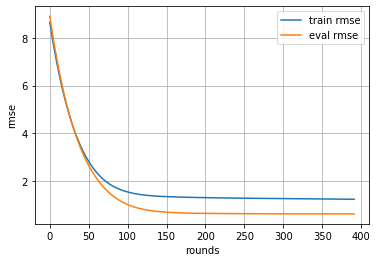

In [8]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

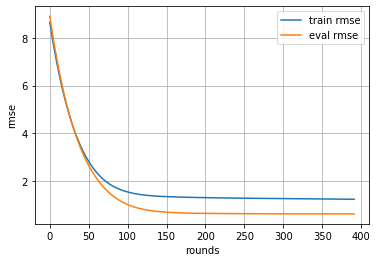

In [9]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

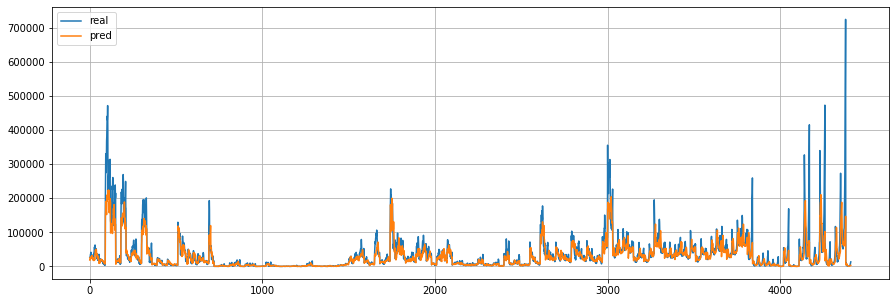

In [10]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Impressions'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

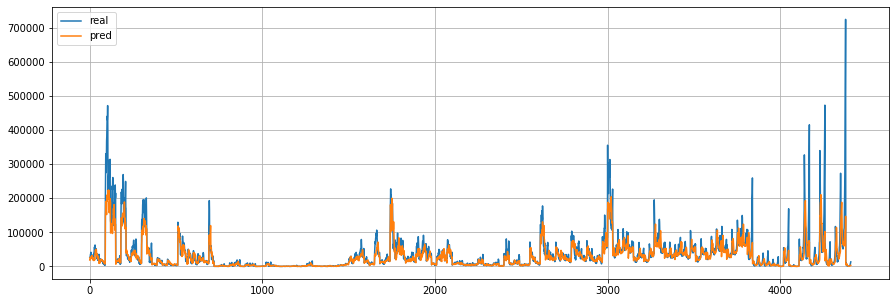

In [11]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Impressions'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

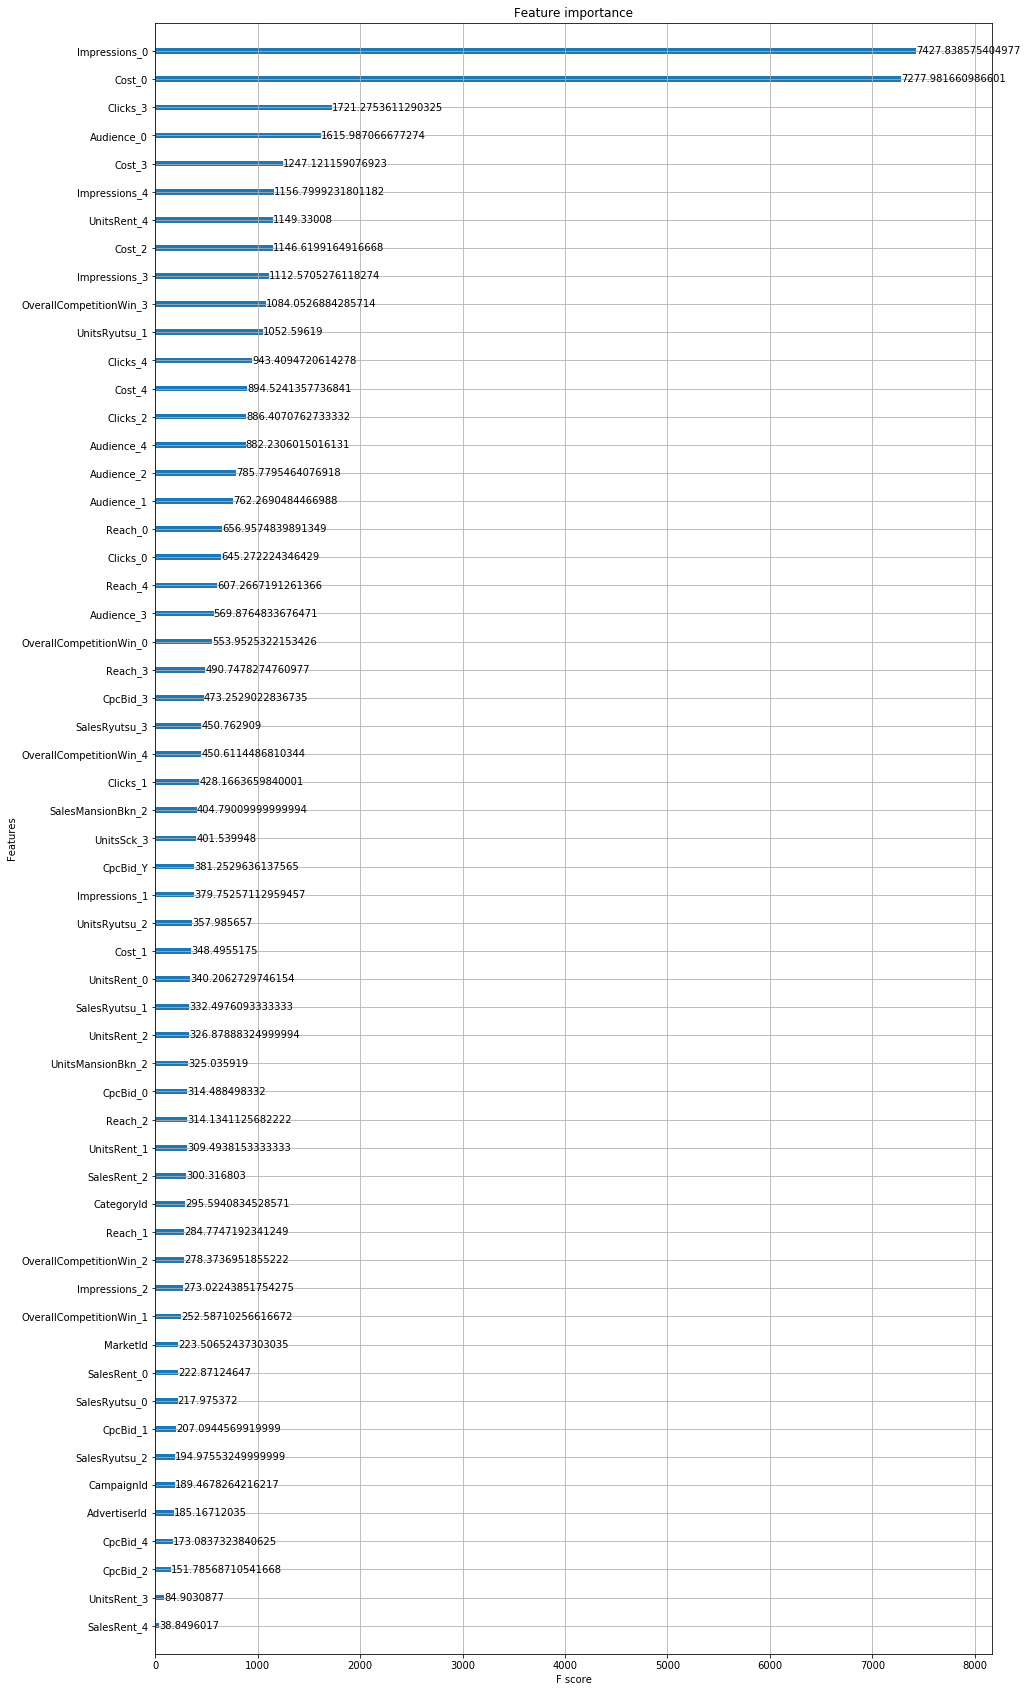

In [12]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [13]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['Impressions_0',
 'Cost_0',
 'Clicks_3',
 'Audience_0',
 'Cost_3',
 'Impressions_4',
 'UnitsRent_4',
 'Cost_2',
 'Impressions_3',
 'OverallCompetitionWin_3',
 'UnitsRyutsu_1',
 'Clicks_4',
 'Cost_4',
 'Clicks_2',
 'Audience_4',
 'Audience_2',
 'Audience_1',
 'Reach_0',
 'Clicks_0',
 'Reach_4',
 'Audience_3',
 'OverallCompetitionWin_0',
 'Reach_3',
 'CpcBid_3',
 'SalesRyutsu_3',
 'OverallCompetitionWin_4',
 'Clicks_1',
 'SalesMansionBkn_2',
 'UnitsSck_3',
 'CpcBid_Y',
 'Impressions_1',
 'UnitsRyutsu_2',
 'Cost_1',
 'UnitsRent_0',
 'SalesRyutsu_1',
 'UnitsRent_2',
 'UnitsMansionBkn_2',
 'CpcBid_0',
 'Reach_2',
 'UnitsRent_1',
 'SalesRent_2',
 'CategoryId',
 'Reach_1',
 'OverallCompetitionWin_2',
 'Impressions_2',
 'OverallCompetitionWin_1',
 'MarketId',
 'SalesRent_0',
 'SalesRyutsu_0',
 'CpcBid_1',
 'SalesRyutsu_2',
 'CampaignId',
 'AdvertiserId',
 'CpcBid_4',
 'CpcBid_2',
 'UnitsRent_3',
 'SalesRent_4']